In [1]:
import os
import pandas as pd
import datetime
from matplotlib import pyplot
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import CuDNNLSTM
from keras.layers import CuDNNGRU
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.layers import Bidirectional
from keras.layers import Lambda
from keras.layers import Dropout
from keras.layers import SimpleRNN
from keras.utils import generic_utils
from keras.utils import Sequence
from keras import regularizers
from keras import optimizers
from keras.callbacks import ModelCheckpoint
import tensorflow as tf
import numpy as np
import scipy 
import math
import h5py
import time
import copy
import sys
import feather
from sklearn.metrics import mean_absolute_error
from numpy.random import seed
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', -1)
seed(123)
from tensorflow import set_random_seed
set_random_seed(456)
np.set_printoptions(threshold=sys.maxsize)

Using TensorFlow backend.


In [2]:
import keras
print(os.getcwd())
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
tf.keras.backend.set_session(tf.Session(config=config))
from tensorflow.python.client import device_lib
#print(device_lib.list_local_devices())

/home/whsu014/dev/mlrig/Experiments


In [3]:
view_1hot_df = feather.read_dataframe("/home/whsu014/data/view_1hot_nona_len29_float_age_impute_and_True_HG_100096inds.feather")

print(view_1hot_df.columns)
print(view_1hot_df.shape)

print(view_1hot_df['CVD_ISOSORBRIDE_DINITRATE'].unique())
view_1hot_df = view_1hot_df.drop(['CVD_ISOSORBRIDE_DINITRATE'], axis=1)
print(view_1hot_df.shape)

Index(['VSIMPLE_INDEX_MASTER', 'QUARTER', 'AGE', 'SEX', 'NZDEP', 'ETHN_1',
       'ETHN_2', 'ETHN_3', 'ETHN_4', 'ETHN_5',
       ...
       'PT_DIABETES_YR', 'PT_ATRIAL_FIBRILLATION', 'PT_IMP_FATAL_CVD',
       'TRUE_HDL', 'TRUE_LDL', 'TRUE_TRI', 'TRUE_TCL', 'TRUE_TCHDL',
       'TRUE_HBA1C', 'TRUE_EGFR'],
      dtype='object', length=191)
(2902784, 191)
[0.]
(2902784, 190)


In [4]:
view_1hot_df.describe()

,VSIMPLE_INDEX_MASTER,QUARTER,AGE,SEX,NZDEP,ETHN_1,ETHN_2,ETHN_3,ETHN_4,ETHN_5,TEST,HDL,LDL,TRI,TCL,TCHDL,TESTED,DIED,LL_SIMVASTATIN,LL_BEZAFIBRATE,LL_ATORVASTATIN,LL_EZETIMIBE,LL_NICOTINIC_ACID,LL_ACIPIMOX,LL_CHOLESTYRAMINE,LL_COLESTIPOL_HYDROCHLORIDE,LL_PRAVASTATIN,LL_EZETIMIBE_WITH_SIMVASTATIN,LL_GEMFIBROZIL,LL_PDC,CVD_FELODIPINE,CVD_QUINAPRIL,CVD_METOPROLOL_SUCCINATE,CVD_CILAZAPRIL,CVD_ATENOLOL,CVD_BENDROFLUMETHIAZIDE,CVD_WARFARIN_SODIUM,CVD_FUROSEMIDE,CVD_CELIPROLOL,CVD_DILTIAZEM_HYDROCHLORIDE,CVD_ASPIRIN,CVD_NIFEDIPINE,CVD_CAPTOPRIL,CVD_DIPYRIDAMOLE,CVD_CANDESARTAN_CILEXETIL,CVD_INDAPAMIDE,CVD_ENALAPRIL_MALEATE,CVD_SOTALOL,CVD_GLYCERYL_TRINITRATE,CVD_ISOSORBIDE_MONONITRATE,CVD_PINDOLOL,CVD_CARVEDILOL,CVD_METHYLDOPA,CVD_LOSARTAN_POTASSIUM,CVD_VERAPAMIL_HYDROCHLORIDE,CVD_AMILORIDE_HYDROCHLORIDE,CVD_CLONIDINE_HYDROCHLORIDE,CVD_CLONIDINE,CVD_NADOLOL,CVD_PROPRANOLOL,CVD_AMLODIPINE,CVD_LABETALOL,CVD_LISINOPRIL,CVD_TRIAMTERENE,CVD_TIMOLOL,CVD_METOPROLOL_TARTRATE,CVD_ACEBUTOLOL,CVD_PERHEXILINE_MALEATE,CVD_CHLORTALIDONE,CVD_BUMETANIDE,CVD_PERINDOPRIL,CVD_TRANDOLAPRIL,CVD_CLOPIDOGREL,CVD_ISRADIPINE,CVD_RIVAROXABAN,CVD_DABIGATRAN,CVD_BISOPROLOL_FUMARATE,CVD_PRASUGREL,CVD_NICORANDIL,CVD_METOLAZONE,CVD_TICAGRELOR,CVD_HYDRALAZINE_HYDROCHLORIDE,CVD_HYDROCHLOROTHIAZIDE,OTHER_TENOXICAM,OTHER_PANTOPRAZOLE,OTHER_OMEPRAZOLE,OTHER_NAPROXEN_SODIUM,OTHER_DICLOFENAC_SODIUM,OTHER_METFORMIN_HYDROCHLORIDE,OTHER_SULINDAC,OTHER_GLICLAZIDE,OTHER_GLIPIZIDE,OTHER_INSULIN_ISOPHANE,OTHER_INSULIN_NEUTRAL,OTHER_KETOPROFEN,OTHER_IBUPROFEN,OTHER_INSULIN_ASPART,OTHER_PREDNISONE,OTHER_INDOMETHACIN,OTHER_NAPROXEN,OTHER_GLIBENCLAMIDE,OTHER_RANITIDINE,OTHER_PIROXICAM,OTHER_INSULIN_LISPRO,OTHER_TIAPROFENIC_ACID,OTHER_PIOGLITAZONE,OTHER_DEXAMETHASONE,OTHER_INSULIN_ZINC_SUSPENSION,OTHER_HYDROCORTISONE,OTHER_PREDNISOLONE,OTHER_TOLBUTAMIDE,OTHER_MEFENAMIC_ACID,OTHER_LANSOPRAZOLE,OTHER_METHYLPREDNISOLONE,OTHER_INSULIN_GLARGINE,OTHER_INSULIND_GLULISINE,OTHER_AMOXYCILLIN,OTHER_CLARITHROMYCIN,OTHER_INSULIN_LISPRO_PROTAMINE,OTHER_INSULIN_ASPART_PROTAMINE,OTHER_VILDAGLIPTIN,NUMBER_OF_DAYS,ACUTE_ADM,hx_broad_cvd,hx_athero_cvd,hx_chd_diags,hx_acs,hx_mi,hx_unst_angina,hx_angina,hx_other_chd,hx_chd_procs,hx_pci,hx_cabg,hx_other_chd_procs,hx_pvd_diags,hx_pvd_procs,hx_haemorrhagic_stroke,hx_cevd,hx_ischaemic_stroke,hx_tia,hx_other_cevd,hx_heart_failure,hx_atrial_fibrillation,mortality_broad_cvd_with_other,mortality_other_related_cvd_deaths,out_broad_cvd,out_athero_cvd,out_chd,out_mi,out_acs,out_unst_angina,out_angina,out_other_chd,out_pvd_diags,out_pvd_procs,out_pci_cabg,out_haemorrhagic_stroke,out_cevd,out_ischaemic_stroke,out_tia,out_other_cevd,out_heart_failure,out_atrial_fibrillation,HBA1C,TEST_HBA1C,TESTED_HBA1C,EGFR,TEST_EGFR,TESTED_EGFR,PT_SBP,PT_SBP2,PT_DBP,PT_DBP2,PT_SMOKING,PT_EN_TCHDL,PT_DIABETES,PT_FAMILY_HISTORY,PT_GEN_LIPID,PT_RENAL,PT_DIABETES_YR,PT_ATRIAL_FIBRILLATION,PT_IMP_FATAL_CVD
count,2.902784e+06,2.902784e+06,2.902784e+06,2.902784e+06,2.902784e+06,2.902784e+06,2.902784e+06,2.902784e+06,2.902784e+06,2.902784e+06,2.902784e+06,2.902784e+06,2.902784e+06,2.902784e+06,2.902784e+06,2.902784e+06,2.902784e+06,2.902784e+06,2.902784e+06,2.902784e+06,2.902784e+06,2.902784e+06,2.902784e+06,2.902784e+06,2.902784e+06,2.902784e+06,2.902784e+06,2.902784e+06,2.902784e+06,2.902784e+06,2.902784e+06,2.902784e+06,2.902784e+06,2.902784e+06,2.902784e+06,2.902784e+06,2.902784e+06,2.902784e+06,2.902784e+06,2.902784e+06,2.902784e+06,2.902784e+06,2.902784e+06,2.902784e+06,2.902784e+06,2.902784e+06,2.902784e+06,2.902784e+06,2.902784e+06,2.902784e+06,2.902784e+06,2.902784e+06,2.902784e+06,2.902784e+06,2.902784e+06,2.902784e+06,2.902784e+06,2.902784e+06,2.902784e+06,2.902784e+06,2.902784e+06,2.902784e+06,2.902784e+06,2.902784e+06,2.902784e+06,2.902784e+06,2.902784e+06,2.902784e+06,2.902784e+06,2.902784e+06,2.902784e+06,2.902784e+06,2.902784e+06,2.902784e+06,2.902784e+06,2.902784e+06,2.902784e+06,2.902784e+06,2.902784e+06,2.902784e+06,2.902784e+06,2.902784e+06,2.902784e+06,2.902784e+06,2.

In [5]:
print("Number of inds:", len(view_1hot_df['VSIMPLE_INDEX_MASTER'].unique()))
# set to length 28
print(view_1hot_df.shape[0]/29)
view_1hot_df = copy.deepcopy(view_1hot_df[view_1hot_df['QUARTER']!=0])
print(view_1hot_df.shape[0]/28)
# Take 90000 inds for train and validation set
# remove true values
# remove QUARTER
view_1hot_df = view_1hot_df.drop(['QUARTER'], axis=1)
train_v = copy.deepcopy(view_1hot_df.iloc[:(28*90000), :-7].values)
true_v = copy.deepcopy(view_1hot_df.iloc[:(28*90000), -7:].values)
print(train_v.shape)
print(train_v.shape[0]/28)
print(true_v.shape)
print(true_v.shape[0]/28)

Number of inds: 100096
100096.0
100096.0
(2520000, 182)
90000.0
(2520000, 7)
90000.0


In [6]:
print(view_1hot_df.columns.get_loc('TCHDL'))

14


In [7]:
mean_tchdl = []

num_of_inds = true_v.shape[0]//28

for i in range(num_of_inds):
    ################################
    # Use true TCHDL values
    ################################
    #ind_tchdl = []
    #ind_true_v = true_v[(i*28):((i+1)*28), :]
    # get prediction window
    #for j in range(8, 28):
    #    if len(ind_true_v[j, 4]) > 2:
    #        ind_tchdl.extend([float(x) for x in \
    #                          ind_true_v[j, 4][1:-1].split(', ')])
    #################################
    # Use interpolated TCHDL values
    #################################
    ind_v = train_v[(i*28):((i+1)*28), :]
    ind_tchdl = np.mean(ind_v[8:28, 14])
    mean_tchdl.append(ind_tchdl)
print(len(mean_tchdl))    

90000


In [8]:
print(mean_tchdl[-1])
mean_tchdl_v = np.array([mean_tchdl]).T
print(mean_tchdl_v.shape)

3.0537271938175388
(90000, 1)


In [9]:
# standardise data
# z = (X - u)/s
# u is the mean of the training samples
# s is the standard devidation of the training samples
scaler_x = StandardScaler()
scaled_train = scaler_x.fit_transform(train_v) 
scaler_y = StandardScaler()
y_train = scaler_y.fit_transform(mean_tchdl_v)

In [10]:
def setup_x(scaled_time_series):
    num_of_inds = scaled_time_series.shape[0]//28
    n_features = scaled_time_series.shape[1]
    
    _x = np.empty((num_of_inds, 
                   n_features+(n_features-1)*7), 
                   dtype='float')
    ###############################################
    # construct x  flatten times series 
    # to 1 row.
    ###############################################
    for i in range(num_of_inds):
        scaled_ind_v = copy.deepcopy(scaled_time_series[(i*28):((i+1)*28), :])
        _x[i, :n_features] = copy.deepcopy(scaled_ind_v[0, :])
        for j in range(1, 8):
            start_idx = (j-1)*(n_features-1)+n_features
            end_idx = start_idx + (n_features-1)
            _x[i, start_idx:end_idx] = copy.deepcopy(scaled_ind_v[j, 1:])
    return _x

In [11]:
x_train = setup_x(scaled_train)
print(x_train.shape)
print(y_train.shape)

(90000, 1449)
(90000, 1)


In [12]:
def setup_model(n_units, dropout_rate_1, dropout_rate_2):
    model = Sequential()
    model.add(Dense(n_units, activation='relu', 
                    #kernel_regularizer=regularizers.l2(0.01),
                    input_shape=(1449, ))) #1449, 1457
    model.add(Dropout(dropout_rate_1))
    model.add(Dense(n_units, activation='relu'))
                    #kernel_regularizer=regularizers.l2(0.01)))
    model.add(Dropout(dropout_rate_2))
    model.add(Dense(1)) 
                   #kernel_regularizer=regularizers.l2(0.01)))
    #sgdm = optimizers.SGD(lr=0.001, momentum=0.9, decay=1e-4)  #1e-4
    model.compile(loss='mae', optimizer='adam')
    return model

In [13]:
def fit_model(model, X_train, Y_train, b_size):
    val_weight = "MLP_val_weights.hdf5"
    val_checkpointer = ModelCheckpoint(filepath=val_weight,
                                         monitor='val_loss', verbose=1,
                                         save_best_only=True)
    history = model.fit(X_train, Y_train,
                        batch_size=b_size, 
                        epochs=100, 
                        validation_split=0.1, 
                        callbacks=[val_checkpointer], 
                        verbose=2, 
                        shuffle=False)
    pyplot.plot(history.history['loss'], label='train')
    pyplot.plot(history.history['val_loss'], label='validation')
    pyplot.legend()
    pyplot.show()
    return min(history.history['val_loss'])

9000
Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 27s - loss: 0.5246 - val_loss: 0.4447

Epoch 00001: val_loss improved from inf to 0.44466, saving model to MLP_val_weights.hdf5
Epoch 2/100
 - 3s - loss: 0.4447 - val_loss: 0.4269

Epoch 00002: val_loss improved from 0.44466 to 0.42690, saving model to MLP_val_weights.hdf5
Epoch 3/100
 - 3s - loss: 0.4322 - val_loss: 0.4203

Epoch 00003: val_loss improved from 0.42690 to 0.42029, saving model to MLP_val_weights.hdf5
Epoch 4/100
 - 3s - loss: 0.4270 - val_loss: 0.4229

Epoch 00004: val_loss did not improve from 0.42029
Epoch 5/100
 - 3s - loss: 0.4226 - val_loss: 0.4180

Epoch 00005: val_loss improved from 0.42029 to 0.41798, saving model to MLP_val_weights.hdf5
Epoch 6/100
 - 3s - loss: 0.4190 - val_loss: 0.4187

Epoch 00006: val_loss did not improve from 0.41798
Epoch 7/100
 - 3s - loss: 0.4167 - val_loss: 0.4174

Epoch 00007: val_loss improved from 0.41798 to 0.41745, saving model to MLP_val_weights.hdf5
Epoch 8/100

 - 3s - loss: 0.3643 - val_loss: 0.4188

Epoch 00075: val_loss did not improve from 0.41440
Epoch 76/100
 - 3s - loss: 0.3638 - val_loss: 0.4276

Epoch 00076: val_loss did not improve from 0.41440
Epoch 77/100
 - 3s - loss: 0.3638 - val_loss: 0.4186

Epoch 00077: val_loss did not improve from 0.41440
Epoch 78/100
 - 3s - loss: 0.3634 - val_loss: 0.4215

Epoch 00078: val_loss did not improve from 0.41440
Epoch 79/100
 - 3s - loss: 0.3627 - val_loss: 0.4191

Epoch 00079: val_loss did not improve from 0.41440
Epoch 80/100
 - 3s - loss: 0.3632 - val_loss: 0.4243

Epoch 00080: val_loss did not improve from 0.41440
Epoch 81/100
 - 3s - loss: 0.3622 - val_loss: 0.4174

Epoch 00081: val_loss did not improve from 0.41440
Epoch 82/100
 - 3s - loss: 0.3629 - val_loss: 0.4243

Epoch 00082: val_loss did not improve from 0.41440
Epoch 83/100
 - 3s - loss: 0.3625 - val_loss: 0.4210

Epoch 00083: val_loss did not improve from 0.41440
Epoch 84/100
 - 3s - loss: 0.3614 - val_loss: 0.4231

Epoch 00084: v

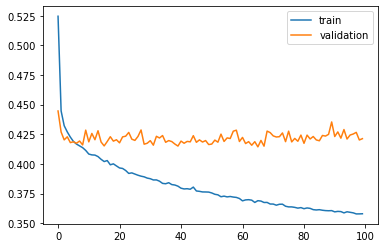

#################################
Number of units: 64
Batch size: 128
Fold: 0
best val loss: 0.4143983794848124
#################################
Time to train MLP:  313.0663638114929
Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 22s - loss: 0.5267 - val_loss: 0.4453

Epoch 00001: val_loss improved from inf to 0.44528, saving model to MLP_val_weights.hdf5
Epoch 2/100
 - 3s - loss: 0.4447 - val_loss: 0.4335

Epoch 00002: val_loss improved from 0.44528 to 0.43348, saving model to MLP_val_weights.hdf5
Epoch 3/100
 - 3s - loss: 0.4326 - val_loss: 0.4218

Epoch 00003: val_loss improved from 0.43348 to 0.42179, saving model to MLP_val_weights.hdf5
Epoch 4/100
 - 3s - loss: 0.4284 - val_loss: 0.4220

Epoch 00004: val_loss did not improve from 0.42179
Epoch 5/100
 - 3s - loss: 0.4231 - val_loss: 0.4214

Epoch 00005: val_loss improved from 0.42179 to 0.42136, saving model to MLP_val_weights.hdf5
Epoch 6/100
 - 3s - loss: 0.4215 - val_loss: 0.4154

Epoch 00006: val_loss improve

 - 3s - loss: 0.3653 - val_loss: 0.4279

Epoch 00075: val_loss did not improve from 0.41140
Epoch 76/100
 - 3s - loss: 0.3642 - val_loss: 0.4278

Epoch 00076: val_loss did not improve from 0.41140
Epoch 77/100
 - 3s - loss: 0.3652 - val_loss: 0.4188

Epoch 00077: val_loss did not improve from 0.41140
Epoch 78/100
 - 3s - loss: 0.3644 - val_loss: 0.4284

Epoch 00078: val_loss did not improve from 0.41140
Epoch 79/100
 - 3s - loss: 0.3632 - val_loss: 0.4315

Epoch 00079: val_loss did not improve from 0.41140
Epoch 80/100
 - 3s - loss: 0.3638 - val_loss: 0.4311

Epoch 00080: val_loss did not improve from 0.41140
Epoch 81/100
 - 3s - loss: 0.3638 - val_loss: 0.4302

Epoch 00081: val_loss did not improve from 0.41140
Epoch 82/100
 - 3s - loss: 0.3639 - val_loss: 0.4204

Epoch 00082: val_loss did not improve from 0.41140
Epoch 83/100
 - 3s - loss: 0.3623 - val_loss: 0.4280

Epoch 00083: val_loss did not improve from 0.41140
Epoch 84/100
 - 3s - loss: 0.3627 - val_loss: 0.4269

Epoch 00084: v

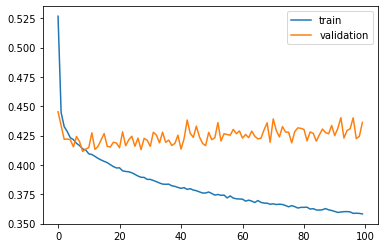

#################################
Number of units: 64
Batch size: 128
Fold: 1
best val loss: 0.4114016878604889
#################################
Time to train MLP:  307.1912531852722
Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 39s - loss: 0.5254 - val_loss: 0.4512

Epoch 00001: val_loss improved from inf to 0.45123, saving model to MLP_val_weights.hdf5
Epoch 2/100
 - 3s - loss: 0.4448 - val_loss: 0.4296

Epoch 00002: val_loss improved from 0.45123 to 0.42957, saving model to MLP_val_weights.hdf5
Epoch 3/100
 - 3s - loss: 0.4338 - val_loss: 0.4195

Epoch 00003: val_loss improved from 0.42957 to 0.41945, saving model to MLP_val_weights.hdf5
Epoch 4/100
 - 3s - loss: 0.4274 - val_loss: 0.4195

Epoch 00004: val_loss did not improve from 0.41945
Epoch 5/100
 - 3s - loss: 0.4225 - val_loss: 0.4213

Epoch 00005: val_loss did not improve from 0.41945
Epoch 6/100
 - 3s - loss: 0.4201 - val_loss: 0.4165

Epoch 00006: val_loss improved from 0.41945 to 0.41646, saving model to

 - 3s - loss: 0.3650 - val_loss: 0.4186

Epoch 00074: val_loss did not improve from 0.41019
Epoch 75/100
 - 3s - loss: 0.3649 - val_loss: 0.4283

Epoch 00075: val_loss did not improve from 0.41019
Epoch 76/100
 - 3s - loss: 0.3645 - val_loss: 0.4188

Epoch 00076: val_loss did not improve from 0.41019
Epoch 77/100
 - 3s - loss: 0.3642 - val_loss: 0.4188

Epoch 00077: val_loss did not improve from 0.41019
Epoch 78/100
 - 3s - loss: 0.3642 - val_loss: 0.4221

Epoch 00078: val_loss did not improve from 0.41019
Epoch 79/100
 - 3s - loss: 0.3628 - val_loss: 0.4186

Epoch 00079: val_loss did not improve from 0.41019
Epoch 80/100
 - 3s - loss: 0.3632 - val_loss: 0.4216

Epoch 00080: val_loss did not improve from 0.41019
Epoch 81/100
 - 3s - loss: 0.3624 - val_loss: 0.4292

Epoch 00081: val_loss did not improve from 0.41019
Epoch 82/100
 - 3s - loss: 0.3621 - val_loss: 0.4203

Epoch 00082: val_loss did not improve from 0.41019
Epoch 83/100
 - 3s - loss: 0.3627 - val_loss: 0.4246

Epoch 00083: v

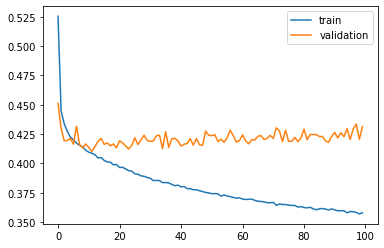

#################################
Number of units: 64
Batch size: 128
Fold: 2
best val loss: 0.4101881051063538
#################################
Time to train MLP:  322.07196402549744
Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 31s - loss: 0.5270 - val_loss: 0.4406

Epoch 00001: val_loss improved from inf to 0.44059, saving model to MLP_val_weights.hdf5
Epoch 2/100
 - 3s - loss: 0.4472 - val_loss: 0.4208

Epoch 00002: val_loss improved from 0.44059 to 0.42080, saving model to MLP_val_weights.hdf5
Epoch 3/100
 - 3s - loss: 0.4343 - val_loss: 0.4253

Epoch 00003: val_loss did not improve from 0.42080
Epoch 4/100
 - 3s - loss: 0.4282 - val_loss: 0.4264

Epoch 00004: val_loss did not improve from 0.42080
Epoch 5/100
 - 3s - loss: 0.4246 - val_loss: 0.4234

Epoch 00005: val_loss did not improve from 0.42080
Epoch 6/100
 - 3s - loss: 0.4208 - val_loss: 0.4184

Epoch 00006: val_loss improved from 0.42080 to 0.41844, saving model to MLP_val_weights.hdf5
Epoch 7/100
 - 3s -

 - 3s - loss: 0.3656 - val_loss: 0.4236

Epoch 00075: val_loss did not improve from 0.40924
Epoch 76/100
 - 3s - loss: 0.3671 - val_loss: 0.4232

Epoch 00076: val_loss did not improve from 0.40924
Epoch 77/100
 - 3s - loss: 0.3660 - val_loss: 0.4244

Epoch 00077: val_loss did not improve from 0.40924
Epoch 78/100
 - 3s - loss: 0.3647 - val_loss: 0.4200

Epoch 00078: val_loss did not improve from 0.40924
Epoch 79/100
 - 3s - loss: 0.3646 - val_loss: 0.4166

Epoch 00079: val_loss did not improve from 0.40924
Epoch 80/100
 - 3s - loss: 0.3660 - val_loss: 0.4162

Epoch 00080: val_loss did not improve from 0.40924
Epoch 81/100
 - 3s - loss: 0.3651 - val_loss: 0.4191

Epoch 00081: val_loss did not improve from 0.40924
Epoch 82/100
 - 3s - loss: 0.3648 - val_loss: 0.4211

Epoch 00082: val_loss did not improve from 0.40924
Epoch 83/100
 - 3s - loss: 0.3639 - val_loss: 0.4255

Epoch 00083: val_loss did not improve from 0.40924
Epoch 84/100
 - 3s - loss: 0.3640 - val_loss: 0.4250

Epoch 00084: v

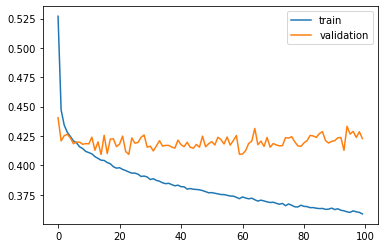

#################################
Number of units: 64
Batch size: 128
Fold: 3
best val loss: 0.4092375793192122
#################################
Time to train MLP:  321.6874010562897
Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 23s - loss: 0.5246 - val_loss: 0.4335

Epoch 00001: val_loss improved from inf to 0.43353, saving model to MLP_val_weights.hdf5
Epoch 2/100
 - 3s - loss: 0.4464 - val_loss: 0.4254

Epoch 00002: val_loss improved from 0.43353 to 0.42544, saving model to MLP_val_weights.hdf5
Epoch 3/100
 - 3s - loss: 0.4319 - val_loss: 0.4160

Epoch 00003: val_loss improved from 0.42544 to 0.41600, saving model to MLP_val_weights.hdf5
Epoch 4/100
 - 3s - loss: 0.4271 - val_loss: 0.4123

Epoch 00004: val_loss improved from 0.41600 to 0.41233, saving model to MLP_val_weights.hdf5
Epoch 5/100
 - 3s - loss: 0.4236 - val_loss: 0.4150

Epoch 00005: val_loss did not improve from 0.41233
Epoch 6/100
 - 3s - loss: 0.4204 - val_loss: 0.4120

Epoch 00006: val_loss improve

 - 3s - loss: 0.3663 - val_loss: 0.4205

Epoch 00073: val_loss did not improve from 0.40819
Epoch 74/100
 - 3s - loss: 0.3648 - val_loss: 0.4242

Epoch 00074: val_loss did not improve from 0.40819
Epoch 75/100
 - 3s - loss: 0.3658 - val_loss: 0.4205

Epoch 00075: val_loss did not improve from 0.40819
Epoch 76/100
 - 3s - loss: 0.3649 - val_loss: 0.4188

Epoch 00076: val_loss did not improve from 0.40819
Epoch 77/100
 - 3s - loss: 0.3637 - val_loss: 0.4187

Epoch 00077: val_loss did not improve from 0.40819
Epoch 78/100
 - 3s - loss: 0.3641 - val_loss: 0.4156

Epoch 00078: val_loss did not improve from 0.40819
Epoch 79/100
 - 3s - loss: 0.3633 - val_loss: 0.4302

Epoch 00079: val_loss did not improve from 0.40819
Epoch 80/100
 - 3s - loss: 0.3635 - val_loss: 0.4178

Epoch 00080: val_loss did not improve from 0.40819
Epoch 81/100
 - 3s - loss: 0.3635 - val_loss: 0.4193

Epoch 00081: val_loss did not improve from 0.40819
Epoch 82/100
 - 3s - loss: 0.3626 - val_loss: 0.4156

Epoch 00082: v

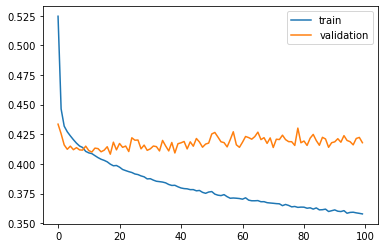

#################################
Number of units: 64
Batch size: 128
Fold: 4
best val loss: 0.4081935699780782
#################################
[[64, 128, 0, 0.4143983794848124], [64, 128, 1, 0.4114016878604889], [64, 128, 2, 0.4101881051063538], [64, 128, 3, 0.4092375793192122], [64, 128, 4, 0.4081935699780782]]
Time to train MLP:  309.4754309654236
Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 63s - loss: 0.5478 - val_loss: 0.4515

Epoch 00001: val_loss improved from inf to 0.45154, saving model to MLP_val_weights.hdf5
Epoch 2/100
 - 2s - loss: 0.4527 - val_loss: 0.4337

Epoch 00002: val_loss improved from 0.45154 to 0.43370, saving model to MLP_val_weights.hdf5
Epoch 3/100
 - 2s - loss: 0.4354 - val_loss: 0.4254

Epoch 00003: val_loss improved from 0.43370 to 0.42543, saving model to MLP_val_weights.hdf5
Epoch 4/100
 - 2s - loss: 0.4310 - val_loss: 0.4281

Epoch 00004: val_loss did not improve from 0.42543
Epoch 5/100
 - 2s - loss: 0.4234 - val_loss: 0.4212

Epoc

 - 2s - loss: 0.3652 - val_loss: 0.4214

Epoch 00071: val_loss did not improve from 0.41275
Epoch 72/100
 - 2s - loss: 0.3644 - val_loss: 0.4195

Epoch 00072: val_loss did not improve from 0.41275
Epoch 73/100
 - 2s - loss: 0.3648 - val_loss: 0.4181

Epoch 00073: val_loss did not improve from 0.41275
Epoch 74/100
 - 2s - loss: 0.3653 - val_loss: 0.4155

Epoch 00074: val_loss did not improve from 0.41275
Epoch 75/100
 - 2s - loss: 0.3648 - val_loss: 0.4220

Epoch 00075: val_loss did not improve from 0.41275
Epoch 76/100
 - 2s - loss: 0.3631 - val_loss: 0.4240

Epoch 00076: val_loss did not improve from 0.41275
Epoch 77/100
 - 2s - loss: 0.3638 - val_loss: 0.4215

Epoch 00077: val_loss did not improve from 0.41275
Epoch 78/100
 - 2s - loss: 0.3628 - val_loss: 0.4189

Epoch 00078: val_loss did not improve from 0.41275
Epoch 79/100
 - 2s - loss: 0.3638 - val_loss: 0.4204

Epoch 00079: val_loss did not improve from 0.41275
Epoch 80/100
 - 2s - loss: 0.3631 - val_loss: 0.4223

Epoch 00080: v

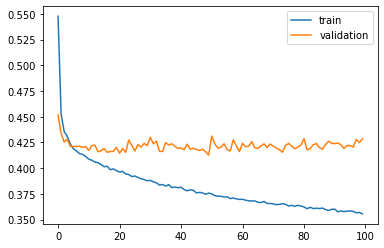

#################################
Number of units: 64
Batch size: 256
Fold: 0
best val loss: 0.41274582566155327
#################################
Time to train MLP:  249.9546525478363
Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 23s - loss: 0.5468 - val_loss: 0.4562

Epoch 00001: val_loss improved from inf to 0.45617, saving model to MLP_val_weights.hdf5
Epoch 2/100
 - 2s - loss: 0.4553 - val_loss: 0.4355

Epoch 00002: val_loss improved from 0.45617 to 0.43551, saving model to MLP_val_weights.hdf5
Epoch 3/100
 - 2s - loss: 0.4368 - val_loss: 0.4239

Epoch 00003: val_loss improved from 0.43551 to 0.42386, saving model to MLP_val_weights.hdf5
Epoch 4/100
 - 2s - loss: 0.4286 - val_loss: 0.4263

Epoch 00004: val_loss did not improve from 0.42386
Epoch 5/100
 - 2s - loss: 0.4226 - val_loss: 0.4268

Epoch 00005: val_loss did not improve from 0.42386
Epoch 6/100
 - 2s - loss: 0.4197 - val_loss: 0.4258

Epoch 00006: val_loss did not improve from 0.42386
Epoch 7/100
 - 2s -

 - 2s - loss: 0.3630 - val_loss: 0.4352

Epoch 00075: val_loss did not improve from 0.41493
Epoch 76/100
 - 2s - loss: 0.3642 - val_loss: 0.4307

Epoch 00076: val_loss did not improve from 0.41493
Epoch 77/100
 - 2s - loss: 0.3638 - val_loss: 0.4296

Epoch 00077: val_loss did not improve from 0.41493
Epoch 78/100
 - 2s - loss: 0.3629 - val_loss: 0.4213

Epoch 00078: val_loss did not improve from 0.41493
Epoch 79/100
 - 2s - loss: 0.3629 - val_loss: 0.4271

Epoch 00079: val_loss did not improve from 0.41493
Epoch 80/100
 - 2s - loss: 0.3634 - val_loss: 0.4242

Epoch 00080: val_loss did not improve from 0.41493
Epoch 81/100
 - 2s - loss: 0.3621 - val_loss: 0.4307

Epoch 00081: val_loss did not improve from 0.41493
Epoch 82/100
 - 2s - loss: 0.3617 - val_loss: 0.4237

Epoch 00082: val_loss did not improve from 0.41493
Epoch 83/100
 - 2s - loss: 0.3620 - val_loss: 0.4279

Epoch 00083: val_loss did not improve from 0.41493
Epoch 84/100
 - 2s - loss: 0.3619 - val_loss: 0.4279

Epoch 00084: v

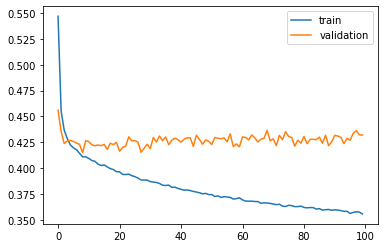

#################################
Number of units: 64
Batch size: 256
Fold: 1
best val loss: 0.4149344152079688
#################################
Time to train MLP:  205.98342180252075
Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 22s - loss: 0.5486 - val_loss: 0.4595

Epoch 00001: val_loss improved from inf to 0.45945, saving model to MLP_val_weights.hdf5
Epoch 2/100
 - 2s - loss: 0.4539 - val_loss: 0.4396

Epoch 00002: val_loss improved from 0.45945 to 0.43957, saving model to MLP_val_weights.hdf5
Epoch 3/100
 - 2s - loss: 0.4372 - val_loss: 0.4288

Epoch 00003: val_loss improved from 0.43957 to 0.42878, saving model to MLP_val_weights.hdf5
Epoch 4/100
 - 2s - loss: 0.4294 - val_loss: 0.4247

Epoch 00004: val_loss improved from 0.42878 to 0.42466, saving model to MLP_val_weights.hdf5
Epoch 5/100
 - 2s - loss: 0.4226 - val_loss: 0.4242

Epoch 00005: val_loss improved from 0.42466 to 0.42420, saving model to MLP_val_weights.hdf5
Epoch 6/100
 - 2s - loss: 0.4182 - val_


Epoch 00073: val_loss did not improve from 0.41236
Epoch 74/100
 - 2s - loss: 0.3641 - val_loss: 0.4158

Epoch 00074: val_loss did not improve from 0.41236
Epoch 75/100
 - 2s - loss: 0.3644 - val_loss: 0.4221

Epoch 00075: val_loss did not improve from 0.41236
Epoch 76/100
 - 2s - loss: 0.3632 - val_loss: 0.4156

Epoch 00076: val_loss did not improve from 0.41236
Epoch 77/100
 - 2s - loss: 0.3621 - val_loss: 0.4198

Epoch 00077: val_loss did not improve from 0.41236
Epoch 78/100
 - 2s - loss: 0.3634 - val_loss: 0.4195

Epoch 00078: val_loss did not improve from 0.41236
Epoch 79/100
 - 2s - loss: 0.3618 - val_loss: 0.4184

Epoch 00079: val_loss did not improve from 0.41236
Epoch 80/100
 - 2s - loss: 0.3622 - val_loss: 0.4192

Epoch 00080: val_loss did not improve from 0.41236
Epoch 81/100
 - 2s - loss: 0.3617 - val_loss: 0.4193

Epoch 00081: val_loss did not improve from 0.41236
Epoch 82/100
 - 2s - loss: 0.3621 - val_loss: 0.4260

Epoch 00082: val_loss did not improve from 0.41236
Epo

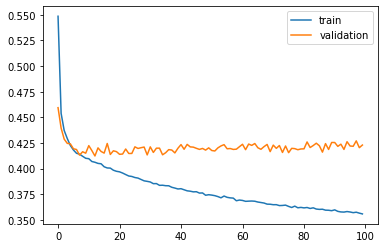

#################################
Number of units: 64
Batch size: 256
Fold: 2
best val loss: 0.4123612467447917
#################################
Time to train MLP:  209.19835090637207
Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 21s - loss: 0.5495 - val_loss: 0.4512

Epoch 00001: val_loss improved from inf to 0.45117, saving model to MLP_val_weights.hdf5
Epoch 2/100
 - 2s - loss: 0.4556 - val_loss: 0.4280

Epoch 00002: val_loss improved from 0.45117 to 0.42801, saving model to MLP_val_weights.hdf5
Epoch 3/100
 - 2s - loss: 0.4394 - val_loss: 0.4214

Epoch 00003: val_loss improved from 0.42801 to 0.42138, saving model to MLP_val_weights.hdf5
Epoch 4/100
 - 2s - loss: 0.4314 - val_loss: 0.4207

Epoch 00004: val_loss improved from 0.42138 to 0.42065, saving model to MLP_val_weights.hdf5
Epoch 5/100
 - 2s - loss: 0.4258 - val_loss: 0.4161

Epoch 00005: val_loss improved from 0.42065 to 0.41610, saving model to MLP_val_weights.hdf5
Epoch 6/100
 - 2s - loss: 0.4197 - val_

 - 2s - loss: 0.3647 - val_loss: 0.4201

Epoch 00075: val_loss did not improve from 0.40930
Epoch 76/100
 - 2s - loss: 0.3646 - val_loss: 0.4307

Epoch 00076: val_loss did not improve from 0.40930
Epoch 77/100
 - 2s - loss: 0.3647 - val_loss: 0.4210

Epoch 00077: val_loss did not improve from 0.40930
Epoch 78/100
 - 2s - loss: 0.3639 - val_loss: 0.4183

Epoch 00078: val_loss did not improve from 0.40930
Epoch 79/100
 - 2s - loss: 0.3630 - val_loss: 0.4247

Epoch 00079: val_loss did not improve from 0.40930
Epoch 80/100
 - 2s - loss: 0.3642 - val_loss: 0.4176

Epoch 00080: val_loss did not improve from 0.40930
Epoch 81/100
 - 2s - loss: 0.3634 - val_loss: 0.4228

Epoch 00081: val_loss did not improve from 0.40930
Epoch 82/100
 - 2s - loss: 0.3627 - val_loss: 0.4181

Epoch 00082: val_loss did not improve from 0.40930
Epoch 83/100
 - 2s - loss: 0.3611 - val_loss: 0.4202

Epoch 00083: val_loss did not improve from 0.40930
Epoch 84/100
 - 2s - loss: 0.3629 - val_loss: 0.4203

Epoch 00084: v

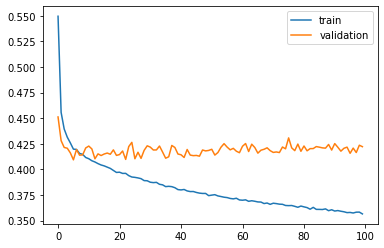

#################################
Number of units: 64
Batch size: 256
Fold: 3
best val loss: 0.4092991690635681
#################################
Time to train MLP:  206.79065036773682
Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 22s - loss: 0.5490 - val_loss: 0.4478

Epoch 00001: val_loss improved from inf to 0.44782, saving model to MLP_val_weights.hdf5
Epoch 2/100
 - 2s - loss: 0.4534 - val_loss: 0.4320

Epoch 00002: val_loss improved from 0.44782 to 0.43203, saving model to MLP_val_weights.hdf5
Epoch 3/100
 - 2s - loss: 0.4368 - val_loss: 0.4218

Epoch 00003: val_loss improved from 0.43203 to 0.42180, saving model to MLP_val_weights.hdf5
Epoch 4/100
 - 2s - loss: 0.4287 - val_loss: 0.4234

Epoch 00004: val_loss did not improve from 0.42180
Epoch 5/100
 - 2s - loss: 0.4238 - val_loss: 0.4153

Epoch 00005: val_loss improved from 0.42180 to 0.41528, saving model to MLP_val_weights.hdf5
Epoch 6/100
 - 2s - loss: 0.4196 - val_loss: 0.4134

Epoch 00006: val_loss improv

 - 2s - loss: 0.3639 - val_loss: 0.4223

Epoch 00075: val_loss did not improve from 0.40955
Epoch 76/100
 - 2s - loss: 0.3629 - val_loss: 0.4219

Epoch 00076: val_loss did not improve from 0.40955
Epoch 77/100
 - 2s - loss: 0.3631 - val_loss: 0.4230

Epoch 00077: val_loss did not improve from 0.40955
Epoch 78/100
 - 2s - loss: 0.3624 - val_loss: 0.4236

Epoch 00078: val_loss did not improve from 0.40955
Epoch 79/100
 - 2s - loss: 0.3625 - val_loss: 0.4234

Epoch 00079: val_loss did not improve from 0.40955
Epoch 80/100
 - 2s - loss: 0.3631 - val_loss: 0.4205

Epoch 00080: val_loss did not improve from 0.40955
Epoch 81/100
 - 2s - loss: 0.3620 - val_loss: 0.4233

Epoch 00081: val_loss did not improve from 0.40955
Epoch 82/100
 - 2s - loss: 0.3593 - val_loss: 0.4202

Epoch 00082: val_loss did not improve from 0.40955
Epoch 83/100
 - 2s - loss: 0.3614 - val_loss: 0.4205

Epoch 00083: val_loss did not improve from 0.40955
Epoch 84/100
 - 2s - loss: 0.3609 - val_loss: 0.4256

Epoch 00084: v

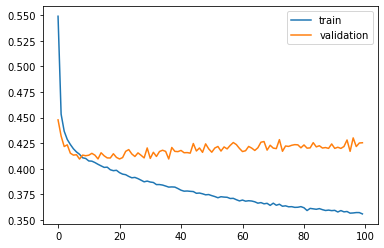

#################################
Number of units: 64
Batch size: 256
Fold: 4
best val loss: 0.40954885700013904
#################################
[[64, 128, 0, 0.4143983794848124], [64, 128, 1, 0.4114016878604889], [64, 128, 2, 0.4101881051063538], [64, 128, 3, 0.4092375793192122], [64, 128, 4, 0.4081935699780782], [64, 256, 0, 0.41274582566155327], [64, 256, 1, 0.4149344152079688], [64, 256, 2, 0.4123612467447917], [64, 256, 3, 0.4092991690635681], [64, 256, 4, 0.40954885700013904]]
Time to train MLP:  211.35945296287537
Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 23s - loss: 0.5059 - val_loss: 0.4312

Epoch 00001: val_loss improved from inf to 0.43120, saving model to MLP_val_weights.hdf5
Epoch 2/100
 - 3s - loss: 0.4336 - val_loss: 0.4235

Epoch 00002: val_loss improved from 0.43120 to 0.42353, saving model to MLP_val_weights.hdf5
Epoch 3/100
 - 3s - loss: 0.4244 - val_loss: 0.4239

Epoch 00003: val_loss did not improve from 0.42353
Epoch 4/100
 - 3s - loss: 0.4


Epoch 00071: val_loss did not improve from 0.41278
Epoch 72/100
 - 3s - loss: 0.3464 - val_loss: 0.4212

Epoch 00072: val_loss did not improve from 0.41278
Epoch 73/100
 - 3s - loss: 0.3460 - val_loss: 0.4247

Epoch 00073: val_loss did not improve from 0.41278
Epoch 74/100
 - 3s - loss: 0.3452 - val_loss: 0.4330

Epoch 00074: val_loss did not improve from 0.41278
Epoch 75/100
 - 3s - loss: 0.3440 - val_loss: 0.4284

Epoch 00075: val_loss did not improve from 0.41278
Epoch 76/100
 - 3s - loss: 0.3449 - val_loss: 0.4263

Epoch 00076: val_loss did not improve from 0.41278
Epoch 77/100
 - 3s - loss: 0.3442 - val_loss: 0.4314

Epoch 00077: val_loss did not improve from 0.41278
Epoch 78/100
 - 3s - loss: 0.3429 - val_loss: 0.4242

Epoch 00078: val_loss did not improve from 0.41278
Epoch 79/100
 - 3s - loss: 0.3432 - val_loss: 0.4245

Epoch 00079: val_loss did not improve from 0.41278
Epoch 80/100
 - 3s - loss: 0.3429 - val_loss: 0.4297

Epoch 00080: val_loss did not improve from 0.41278
Epo

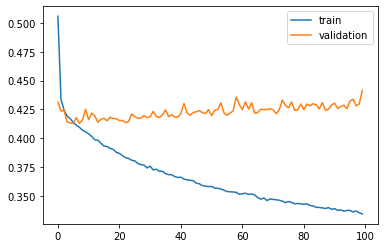

#################################
Number of units: 128
Batch size: 128
Fold: 0
best val loss: 0.41277814224031234
#################################
Time to train MLP:  324.1599769592285
Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 36s - loss: 0.5087 - val_loss: 0.4386

Epoch 00001: val_loss improved from inf to 0.43856, saving model to MLP_val_weights.hdf5
Epoch 2/100
 - 3s - loss: 0.4364 - val_loss: 0.4168

Epoch 00002: val_loss improved from 0.43856 to 0.41675, saving model to MLP_val_weights.hdf5
Epoch 3/100
 - 3s - loss: 0.4255 - val_loss: 0.4150

Epoch 00003: val_loss improved from 0.41675 to 0.41497, saving model to MLP_val_weights.hdf5
Epoch 4/100
 - 3s - loss: 0.4213 - val_loss: 0.4092

Epoch 00004: val_loss improved from 0.41497 to 0.40915, saving model to MLP_val_weights.hdf5
Epoch 5/100
 - 3s - loss: 0.4171 - val_loss: 0.4106

Epoch 00005: val_loss did not improve from 0.40915
Epoch 6/100
 - 3s - loss: 0.4151 - val_loss: 0.4094

Epoch 00006: val_loss did n


Epoch 00075: val_loss did not improve from 0.40915
Epoch 76/100
 - 3s - loss: 0.3457 - val_loss: 0.4328

Epoch 00076: val_loss did not improve from 0.40915
Epoch 77/100
 - 3s - loss: 0.3434 - val_loss: 0.4268

Epoch 00077: val_loss did not improve from 0.40915
Epoch 78/100
 - 3s - loss: 0.3432 - val_loss: 0.4310

Epoch 00078: val_loss did not improve from 0.40915
Epoch 79/100
 - 3s - loss: 0.3437 - val_loss: 0.4375

Epoch 00079: val_loss did not improve from 0.40915
Epoch 80/100
 - 3s - loss: 0.3434 - val_loss: 0.4260

Epoch 00080: val_loss did not improve from 0.40915
Epoch 81/100
 - 3s - loss: 0.3429 - val_loss: 0.4275

Epoch 00081: val_loss did not improve from 0.40915
Epoch 82/100
 - 3s - loss: 0.3410 - val_loss: 0.4289

Epoch 00082: val_loss did not improve from 0.40915
Epoch 83/100
 - 3s - loss: 0.3416 - val_loss: 0.4294

Epoch 00083: val_loss did not improve from 0.40915
Epoch 84/100
 - 3s - loss: 0.3416 - val_loss: 0.4297

Epoch 00084: val_loss did not improve from 0.40915
Epo

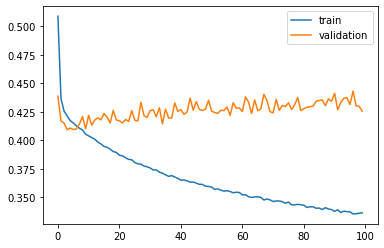

#################################
Number of units: 128
Batch size: 128
Fold: 1
best val loss: 0.40915396282407973
#################################
Time to train MLP:  336.8918447494507
Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 51s - loss: 0.5079 - val_loss: 0.4309

Epoch 00001: val_loss improved from inf to 0.43085, saving model to MLP_val_weights.hdf5
Epoch 2/100
 - 3s - loss: 0.4351 - val_loss: 0.4256

Epoch 00002: val_loss improved from 0.43085 to 0.42558, saving model to MLP_val_weights.hdf5
Epoch 3/100
 - 3s - loss: 0.4250 - val_loss: 0.4169

Epoch 00003: val_loss improved from 0.42558 to 0.41691, saving model to MLP_val_weights.hdf5
Epoch 4/100
 - 3s - loss: 0.4192 - val_loss: 0.4152

Epoch 00004: val_loss improved from 0.41691 to 0.41516, saving model to MLP_val_weights.hdf5
Epoch 5/100
 - 3s - loss: 0.4160 - val_loss: 0.4148

Epoch 00005: val_loss improved from 0.41516 to 0.41476, saving model to MLP_val_weights.hdf5
Epoch 6/100
 - 3s - loss: 0.4123 - val

 - 3s - loss: 0.3446 - val_loss: 0.4227

Epoch 00074: val_loss did not improve from 0.40993
Epoch 75/100
 - 3s - loss: 0.3454 - val_loss: 0.4257

Epoch 00075: val_loss did not improve from 0.40993
Epoch 76/100
 - 3s - loss: 0.3440 - val_loss: 0.4303

Epoch 00076: val_loss did not improve from 0.40993
Epoch 77/100
 - 3s - loss: 0.3431 - val_loss: 0.4279

Epoch 00077: val_loss did not improve from 0.40993
Epoch 78/100
 - 3s - loss: 0.3426 - val_loss: 0.4277

Epoch 00078: val_loss did not improve from 0.40993
Epoch 79/100
 - 3s - loss: 0.3417 - val_loss: 0.4269

Epoch 00079: val_loss did not improve from 0.40993
Epoch 80/100
 - 3s - loss: 0.3410 - val_loss: 0.4235

Epoch 00080: val_loss did not improve from 0.40993
Epoch 81/100
 - 3s - loss: 0.3421 - val_loss: 0.4259

Epoch 00081: val_loss did not improve from 0.40993
Epoch 82/100
 - 3s - loss: 0.3419 - val_loss: 0.4304

Epoch 00082: val_loss did not improve from 0.40993
Epoch 83/100
 - 3s - loss: 0.3414 - val_loss: 0.4261

Epoch 00083: v

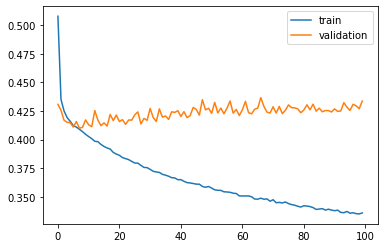

#################################
Number of units: 128
Batch size: 128
Fold: 2
best val loss: 0.40992913272645737
#################################
Time to train MLP:  350.9658372402191
Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 26s - loss: 0.5076 - val_loss: 0.4238

Epoch 00001: val_loss improved from inf to 0.42380, saving model to MLP_val_weights.hdf5
Epoch 2/100
 - 3s - loss: 0.4370 - val_loss: 0.4130

Epoch 00002: val_loss improved from 0.42380 to 0.41303, saving model to MLP_val_weights.hdf5
Epoch 3/100
 - 3s - loss: 0.4258 - val_loss: 0.4182

Epoch 00003: val_loss did not improve from 0.41303
Epoch 4/100
 - 3s - loss: 0.4205 - val_loss: 0.4063

Epoch 00004: val_loss improved from 0.41303 to 0.40634, saving model to MLP_val_weights.hdf5
Epoch 5/100
 - 3s - loss: 0.4165 - val_loss: 0.4098

Epoch 00005: val_loss did not improve from 0.40634
Epoch 6/100
 - 3s - loss: 0.4147 - val_loss: 0.4141

Epoch 00006: val_loss did not improve from 0.40634
Epoch 7/100
 - 3s 

 - 3s - loss: 0.3453 - val_loss: 0.4244

Epoch 00076: val_loss did not improve from 0.40634
Epoch 77/100
 - 3s - loss: 0.3452 - val_loss: 0.4324

Epoch 00077: val_loss did not improve from 0.40634
Epoch 78/100
 - 3s - loss: 0.3448 - val_loss: 0.4268

Epoch 00078: val_loss did not improve from 0.40634
Epoch 79/100
 - 3s - loss: 0.3445 - val_loss: 0.4209

Epoch 00079: val_loss did not improve from 0.40634
Epoch 80/100
 - 3s - loss: 0.3436 - val_loss: 0.4241

Epoch 00080: val_loss did not improve from 0.40634
Epoch 81/100
 - 3s - loss: 0.3425 - val_loss: 0.4225

Epoch 00081: val_loss did not improve from 0.40634
Epoch 82/100
 - 3s - loss: 0.3440 - val_loss: 0.4234

Epoch 00082: val_loss did not improve from 0.40634
Epoch 83/100
 - 3s - loss: 0.3420 - val_loss: 0.4219

Epoch 00083: val_loss did not improve from 0.40634
Epoch 84/100
 - 3s - loss: 0.3411 - val_loss: 0.4290

Epoch 00084: val_loss did not improve from 0.40634
Epoch 85/100
 - 3s - loss: 0.3412 - val_loss: 0.4239

Epoch 00085: v

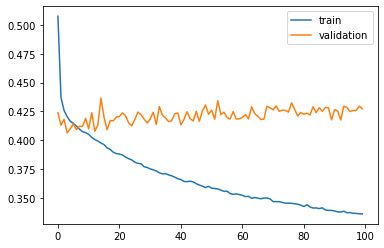

#################################
Number of units: 128
Batch size: 128
Fold: 3
best val loss: 0.40633863316641916
#################################
Time to train MLP:  334.3285849094391
Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 25s - loss: 0.5076 - val_loss: 0.4208

Epoch 00001: val_loss improved from inf to 0.42079, saving model to MLP_val_weights.hdf5
Epoch 2/100
 - 3s - loss: 0.4355 - val_loss: 0.4138

Epoch 00002: val_loss improved from 0.42079 to 0.41379, saving model to MLP_val_weights.hdf5
Epoch 3/100
 - 3s - loss: 0.4254 - val_loss: 0.4122

Epoch 00003: val_loss improved from 0.41379 to 0.41223, saving model to MLP_val_weights.hdf5
Epoch 4/100
 - 3s - loss: 0.4196 - val_loss: 0.4091

Epoch 00004: val_loss improved from 0.41223 to 0.40914, saving model to MLP_val_weights.hdf5
Epoch 5/100
 - 3s - loss: 0.4160 - val_loss: 0.4069

Epoch 00005: val_loss improved from 0.40914 to 0.40689, saving model to MLP_val_weights.hdf5
Epoch 6/100
 - 3s - loss: 0.4133 - val

 - 3s - loss: 0.3456 - val_loss: 0.4251

Epoch 00075: val_loss did not improve from 0.40689
Epoch 76/100
 - 3s - loss: 0.3445 - val_loss: 0.4289

Epoch 00076: val_loss did not improve from 0.40689
Epoch 77/100
 - 3s - loss: 0.3446 - val_loss: 0.4280

Epoch 00077: val_loss did not improve from 0.40689
Epoch 78/100
 - 3s - loss: 0.3433 - val_loss: 0.4219

Epoch 00078: val_loss did not improve from 0.40689
Epoch 79/100
 - 3s - loss: 0.3427 - val_loss: 0.4241

Epoch 00079: val_loss did not improve from 0.40689
Epoch 80/100
 - 3s - loss: 0.3444 - val_loss: 0.4267

Epoch 00080: val_loss did not improve from 0.40689
Epoch 81/100
 - 3s - loss: 0.3430 - val_loss: 0.4253

Epoch 00081: val_loss did not improve from 0.40689
Epoch 82/100
 - 3s - loss: 0.3420 - val_loss: 0.4269

Epoch 00082: val_loss did not improve from 0.40689
Epoch 83/100
 - 3s - loss: 0.3414 - val_loss: 0.4245

Epoch 00083: val_loss did not improve from 0.40689
Epoch 84/100
 - 3s - loss: 0.3394 - val_loss: 0.4225

Epoch 00084: v

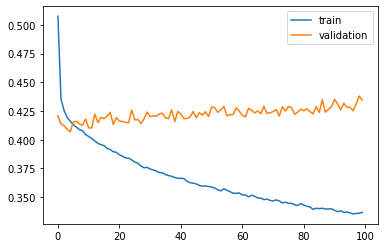

#################################
Number of units: 128
Batch size: 128
Fold: 4
best val loss: 0.4068948254585266
#################################
[[64, 128, 0, 0.4143983794848124], [64, 128, 1, 0.4114016878604889], [64, 128, 2, 0.4101881051063538], [64, 128, 3, 0.4092375793192122], [64, 128, 4, 0.4081935699780782], [64, 256, 0, 0.41274582566155327], [64, 256, 1, 0.4149344152079688], [64, 256, 2, 0.4123612467447917], [64, 256, 3, 0.4092991690635681], [64, 256, 4, 0.40954885700013904], [128, 128, 0, 0.41277814224031234], [128, 128, 1, 0.40915396282407973], [128, 128, 2, 0.40992913272645737], [128, 128, 3, 0.40633863316641916], [128, 128, 4, 0.4068948254585266]]
Time to train MLP:  328.083336353302
Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 48s - loss: 0.5253 - val_loss: 0.4466

Epoch 00001: val_loss improved from inf to 0.44661, saving model to MLP_val_weights.hdf5
Epoch 2/100
 - 2s - loss: 0.4385 - val_loss: 0.4288

Epoch 00002: val_loss improved from 0.44661 to 0.

 - 2s - loss: 0.3434 - val_loss: 0.4283

Epoch 00070: val_loss did not improve from 0.40997
Epoch 71/100
 - 2s - loss: 0.3417 - val_loss: 0.4344

Epoch 00071: val_loss did not improve from 0.40997
Epoch 72/100
 - 2s - loss: 0.3422 - val_loss: 0.4295

Epoch 00072: val_loss did not improve from 0.40997
Epoch 73/100
 - 2s - loss: 0.3415 - val_loss: 0.4276

Epoch 00073: val_loss did not improve from 0.40997
Epoch 74/100
 - 2s - loss: 0.3412 - val_loss: 0.4309

Epoch 00074: val_loss did not improve from 0.40997
Epoch 75/100
 - 2s - loss: 0.3410 - val_loss: 0.4293

Epoch 00075: val_loss did not improve from 0.40997
Epoch 76/100
 - 2s - loss: 0.3399 - val_loss: 0.4358

Epoch 00076: val_loss did not improve from 0.40997
Epoch 77/100
 - 2s - loss: 0.3407 - val_loss: 0.4269

Epoch 00077: val_loss did not improve from 0.40997
Epoch 78/100
 - 2s - loss: 0.3394 - val_loss: 0.4328

Epoch 00078: val_loss did not improve from 0.40997
Epoch 79/100
 - 2s - loss: 0.3377 - val_loss: 0.4267

Epoch 00079: v

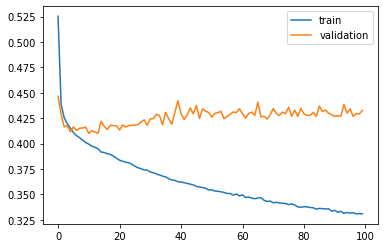

#################################
Number of units: 128
Batch size: 256
Fold: 0
best val loss: 0.409969370815489
#################################
Time to train MLP:  245.32634115219116
Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 32s - loss: 0.5263 - val_loss: 0.4397

Epoch 00001: val_loss improved from inf to 0.43966, saving model to MLP_val_weights.hdf5
Epoch 2/100
 - 2s - loss: 0.4421 - val_loss: 0.4280

Epoch 00002: val_loss improved from 0.43966 to 0.42798, saving model to MLP_val_weights.hdf5
Epoch 3/100
 - 2s - loss: 0.4265 - val_loss: 0.4276

Epoch 00003: val_loss improved from 0.42798 to 0.42761, saving model to MLP_val_weights.hdf5
Epoch 4/100
 - 2s - loss: 0.4200 - val_loss: 0.4332

Epoch 00004: val_loss did not improve from 0.42761
Epoch 5/100
 - 2s - loss: 0.4148 - val_loss: 0.4144

Epoch 00005: val_loss improved from 0.42761 to 0.41441, saving model to MLP_val_weights.hdf5
Epoch 6/100
 - 2s - loss: 0.4114 - val_loss: 0.4227

Epoch 00006: val_loss did no

 - 2s - loss: 0.3395 - val_loss: 0.4308

Epoch 00075: val_loss did not improve from 0.40853
Epoch 76/100
 - 2s - loss: 0.3385 - val_loss: 0.4318

Epoch 00076: val_loss did not improve from 0.40853
Epoch 77/100
 - 2s - loss: 0.3394 - val_loss: 0.4239

Epoch 00077: val_loss did not improve from 0.40853
Epoch 78/100
 - 2s - loss: 0.3373 - val_loss: 0.4318

Epoch 00078: val_loss did not improve from 0.40853
Epoch 79/100
 - 2s - loss: 0.3392 - val_loss: 0.4270

Epoch 00079: val_loss did not improve from 0.40853
Epoch 80/100
 - 2s - loss: 0.3378 - val_loss: 0.4356

Epoch 00080: val_loss did not improve from 0.40853
Epoch 81/100
 - 2s - loss: 0.3386 - val_loss: 0.4333

Epoch 00081: val_loss did not improve from 0.40853
Epoch 82/100
 - 2s - loss: 0.3365 - val_loss: 0.4239

Epoch 00082: val_loss did not improve from 0.40853
Epoch 83/100
 - 2s - loss: 0.3370 - val_loss: 0.4241

Epoch 00083: val_loss did not improve from 0.40853
Epoch 84/100
 - 2s - loss: 0.3357 - val_loss: 0.4208

Epoch 00084: v

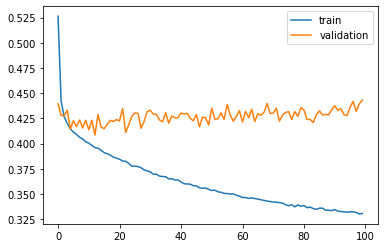

#################################
Number of units: 128
Batch size: 256
Fold: 1
best val loss: 0.4085315928724077
#################################
Time to train MLP:  227.92204117774963
Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 72s - loss: 0.5211 - val_loss: 0.4395

Epoch 00001: val_loss improved from inf to 0.43948, saving model to MLP_val_weights.hdf5
Epoch 2/100
 - 2s - loss: 0.4395 - val_loss: 0.4255

Epoch 00002: val_loss improved from 0.43948 to 0.42553, saving model to MLP_val_weights.hdf5
Epoch 3/100
 - 2s - loss: 0.4264 - val_loss: 0.4212

Epoch 00003: val_loss improved from 0.42553 to 0.42121, saving model to MLP_val_weights.hdf5
Epoch 4/100
 - 2s - loss: 0.4197 - val_loss: 0.4161

Epoch 00004: val_loss improved from 0.42121 to 0.41613, saving model to MLP_val_weights.hdf5
Epoch 5/100
 - 2s - loss: 0.4144 - val_loss: 0.4170

Epoch 00005: val_loss did not improve from 0.41613
Epoch 6/100
 - 2s - loss: 0.4110 - val_loss: 0.4143

Epoch 00006: val_loss impro

 - 2s - loss: 0.3406 - val_loss: 0.4302

Epoch 00074: val_loss did not improve from 0.41147
Epoch 75/100
 - 2s - loss: 0.3399 - val_loss: 0.4305

Epoch 00075: val_loss did not improve from 0.41147
Epoch 76/100
 - 2s - loss: 0.3406 - val_loss: 0.4269

Epoch 00076: val_loss did not improve from 0.41147
Epoch 77/100
 - 2s - loss: 0.3398 - val_loss: 0.4223

Epoch 00077: val_loss did not improve from 0.41147
Epoch 78/100
 - 2s - loss: 0.3391 - val_loss: 0.4264

Epoch 00078: val_loss did not improve from 0.41147
Epoch 79/100
 - 2s - loss: 0.3388 - val_loss: 0.4329

Epoch 00079: val_loss did not improve from 0.41147
Epoch 80/100
 - 2s - loss: 0.3371 - val_loss: 0.4282

Epoch 00080: val_loss did not improve from 0.41147
Epoch 81/100
 - 2s - loss: 0.3385 - val_loss: 0.4287

Epoch 00081: val_loss did not improve from 0.41147
Epoch 82/100
 - 2s - loss: 0.3372 - val_loss: 0.4288

Epoch 00082: val_loss did not improve from 0.41147
Epoch 83/100
 - 2s - loss: 0.3368 - val_loss: 0.4293

Epoch 00083: v

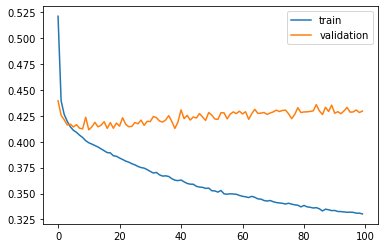

#################################
Number of units: 128
Batch size: 256
Fold: 2
best val loss: 0.4114747896194458
#################################
Time to train MLP:  269.95806860923767
Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 33s - loss: 0.5243 - val_loss: 0.4316

Epoch 00001: val_loss improved from inf to 0.43158, saving model to MLP_val_weights.hdf5
Epoch 2/100
 - 2s - loss: 0.4393 - val_loss: 0.4281

Epoch 00002: val_loss improved from 0.43158 to 0.42814, saving model to MLP_val_weights.hdf5
Epoch 3/100
 - 2s - loss: 0.4264 - val_loss: 0.4112

Epoch 00003: val_loss improved from 0.42814 to 0.41115, saving model to MLP_val_weights.hdf5
Epoch 4/100
 - 2s - loss: 0.4201 - val_loss: 0.4114

Epoch 00004: val_loss did not improve from 0.41115
Epoch 5/100
 - 2s - loss: 0.4157 - val_loss: 0.4057

Epoch 00005: val_loss improved from 0.41115 to 0.40572, saving model to MLP_val_weights.hdf5
Epoch 6/100
 - 2s - loss: 0.4118 - val_loss: 0.4091

Epoch 00006: val_loss did n

 - 2s - loss: 0.3410 - val_loss: 0.4219

Epoch 00075: val_loss did not improve from 0.40228
Epoch 76/100
 - 2s - loss: 0.3405 - val_loss: 0.4251

Epoch 00076: val_loss did not improve from 0.40228
Epoch 77/100
 - 2s - loss: 0.3395 - val_loss: 0.4256

Epoch 00077: val_loss did not improve from 0.40228
Epoch 78/100
 - 2s - loss: 0.3400 - val_loss: 0.4336

Epoch 00078: val_loss did not improve from 0.40228
Epoch 79/100
 - 2s - loss: 0.3389 - val_loss: 0.4255

Epoch 00079: val_loss did not improve from 0.40228
Epoch 80/100
 - 2s - loss: 0.3401 - val_loss: 0.4224

Epoch 00080: val_loss did not improve from 0.40228
Epoch 81/100
 - 2s - loss: 0.3372 - val_loss: 0.4236

Epoch 00081: val_loss did not improve from 0.40228
Epoch 82/100
 - 2s - loss: 0.3372 - val_loss: 0.4249

Epoch 00082: val_loss did not improve from 0.40228
Epoch 83/100
 - 2s - loss: 0.3382 - val_loss: 0.4298

Epoch 00083: val_loss did not improve from 0.40228
Epoch 84/100
 - 2s - loss: 0.3367 - val_loss: 0.4359

Epoch 00084: v

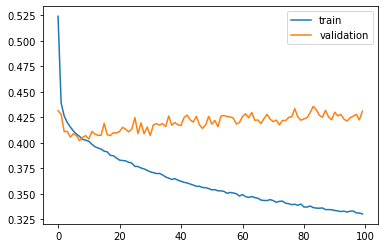

#################################
Number of units: 128
Batch size: 256
Fold: 3
best val loss: 0.40227914039293927
#################################
Time to train MLP:  230.50308418273926
Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 30s - loss: 0.5280 - val_loss: 0.4376

Epoch 00001: val_loss improved from inf to 0.43759, saving model to MLP_val_weights.hdf5
Epoch 2/100
 - 2s - loss: 0.4403 - val_loss: 0.4176

Epoch 00002: val_loss improved from 0.43759 to 0.41763, saving model to MLP_val_weights.hdf5
Epoch 3/100
 - 2s - loss: 0.4277 - val_loss: 0.4093

Epoch 00003: val_loss improved from 0.41763 to 0.40932, saving model to MLP_val_weights.hdf5
Epoch 4/100
 - 2s - loss: 0.4198 - val_loss: 0.4111

Epoch 00004: val_loss did not improve from 0.40932
Epoch 5/100
 - 2s - loss: 0.4149 - val_loss: 0.4109

Epoch 00005: val_loss did not improve from 0.40932
Epoch 6/100
 - 2s - loss: 0.4113 - val_loss: 0.4050

Epoch 00006: val_loss improved from 0.40932 to 0.40498, saving model

 - 2s - loss: 0.3399 - val_loss: 0.4338

Epoch 00075: val_loss did not improve from 0.40246
Epoch 76/100
 - 2s - loss: 0.3399 - val_loss: 0.4265

Epoch 00076: val_loss did not improve from 0.40246
Epoch 77/100
 - 2s - loss: 0.3397 - val_loss: 0.4262

Epoch 00077: val_loss did not improve from 0.40246
Epoch 78/100
 - 2s - loss: 0.3382 - val_loss: 0.4230

Epoch 00078: val_loss did not improve from 0.40246
Epoch 79/100
 - 2s - loss: 0.3386 - val_loss: 0.4238

Epoch 00079: val_loss did not improve from 0.40246
Epoch 80/100
 - 2s - loss: 0.3394 - val_loss: 0.4318

Epoch 00080: val_loss did not improve from 0.40246
Epoch 81/100
 - 2s - loss: 0.3377 - val_loss: 0.4314

Epoch 00081: val_loss did not improve from 0.40246
Epoch 82/100
 - 2s - loss: 0.3372 - val_loss: 0.4309

Epoch 00082: val_loss did not improve from 0.40246
Epoch 83/100
 - 2s - loss: 0.3370 - val_loss: 0.4272

Epoch 00083: val_loss did not improve from 0.40246
Epoch 84/100
 - 2s - loss: 0.3366 - val_loss: 0.4276

Epoch 00084: v

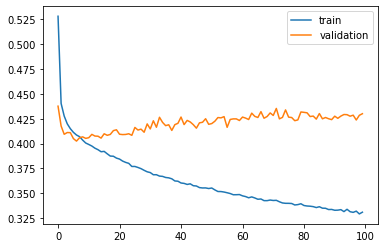

#################################
Number of units: 128
Batch size: 256
Fold: 4
best val loss: 0.402464359972212
#################################
[[64, 128, 0, 0.4143983794848124], [64, 128, 1, 0.4114016878604889], [64, 128, 2, 0.4101881051063538], [64, 128, 3, 0.4092375793192122], [64, 128, 4, 0.4081935699780782], [64, 256, 0, 0.41274582566155327], [64, 256, 1, 0.4149344152079688], [64, 256, 2, 0.4123612467447917], [64, 256, 3, 0.4092991690635681], [64, 256, 4, 0.40954885700013904], [128, 128, 0, 0.41277814224031234], [128, 128, 1, 0.40915396282407973], [128, 128, 2, 0.40992913272645737], [128, 128, 3, 0.40633863316641916], [128, 128, 4, 0.4068948254585266], [128, 256, 0, 0.409969370815489], [128, 256, 1, 0.4085315928724077], [128, 256, 2, 0.4114747896194458], [128, 256, 3, 0.40227914039293927], [128, 256, 4, 0.402464359972212]]
Time to train MLP:  227.5571539402008
Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 35s - loss: 0.4924 - val_loss: 0.4270

Epoch 00001: val_

 - 3s - loss: 0.3301 - val_loss: 0.4318

Epoch 00068: val_loss did not improve from 0.41307
Epoch 69/100
 - 3s - loss: 0.3298 - val_loss: 0.4281

Epoch 00069: val_loss did not improve from 0.41307
Epoch 70/100
 - 3s - loss: 0.3287 - val_loss: 0.4375

Epoch 00070: val_loss did not improve from 0.41307
Epoch 71/100
 - 3s - loss: 0.3268 - val_loss: 0.4315

Epoch 00071: val_loss did not improve from 0.41307
Epoch 72/100
 - 3s - loss: 0.3268 - val_loss: 0.4291

Epoch 00072: val_loss did not improve from 0.41307
Epoch 73/100
 - 3s - loss: 0.3261 - val_loss: 0.4322

Epoch 00073: val_loss did not improve from 0.41307
Epoch 74/100
 - 3s - loss: 0.3260 - val_loss: 0.4373

Epoch 00074: val_loss did not improve from 0.41307
Epoch 75/100
 - 3s - loss: 0.3254 - val_loss: 0.4279

Epoch 00075: val_loss did not improve from 0.41307
Epoch 76/100
 - 3s - loss: 0.3263 - val_loss: 0.4372

Epoch 00076: val_loss did not improve from 0.41307
Epoch 77/100
 - 3s - loss: 0.3250 - val_loss: 0.4275

Epoch 00077: v

 - 3s - loss: 0.3397 - val_loss: 0.4239

Epoch 00054: val_loss did not improve from 0.41077
Epoch 55/100
 - 3s - loss: 0.3394 - val_loss: 0.4294

Epoch 00055: val_loss did not improve from 0.41077
Epoch 56/100
 - 3s - loss: 0.3379 - val_loss: 0.4255

Epoch 00056: val_loss did not improve from 0.41077
Epoch 57/100
 - 3s - loss: 0.3369 - val_loss: 0.4233

Epoch 00057: val_loss did not improve from 0.41077
Epoch 58/100
 - 3s - loss: 0.3376 - val_loss: 0.4251

Epoch 00058: val_loss did not improve from 0.41077
Epoch 59/100
 - 3s - loss: 0.3370 - val_loss: 0.4281

Epoch 00059: val_loss did not improve from 0.41077
Epoch 60/100
 - 3s - loss: 0.3357 - val_loss: 0.4262

Epoch 00060: val_loss did not improve from 0.41077
Epoch 61/100
 - 3s - loss: 0.3352 - val_loss: 0.4271

Epoch 00061: val_loss did not improve from 0.41077
Epoch 62/100
 - 3s - loss: 0.3339 - val_loss: 0.4237

Epoch 00062: val_loss did not improve from 0.41077
Epoch 63/100
 - 3s - loss: 0.3331 - val_loss: 0.4262

Epoch 00063: v

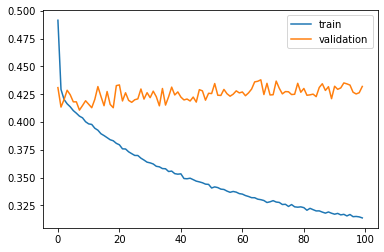

#################################
Number of units: 256
Batch size: 128
Fold: 1
best val loss: 0.4107674022515615
#################################
Time to train MLP:  427.43094873428345
Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 44s - loss: 0.4954 - val_loss: 0.4301

Epoch 00001: val_loss improved from inf to 0.43012, saving model to MLP_val_weights.hdf5
Epoch 2/100
 - 3s - loss: 0.4307 - val_loss: 0.4210

Epoch 00002: val_loss improved from 0.43012 to 0.42104, saving model to MLP_val_weights.hdf5
Epoch 3/100
 - 3s - loss: 0.4206 - val_loss: 0.4147

Epoch 00003: val_loss improved from 0.42104 to 0.41470, saving model to MLP_val_weights.hdf5
Epoch 4/100
 - 3s - loss: 0.4163 - val_loss: 0.4186

Epoch 00004: val_loss did not improve from 0.41470
Epoch 5/100
 - 3s - loss: 0.4121 - val_loss: 0.4131

Epoch 00005: val_loss improved from 0.41470 to 0.41310, saving model to MLP_val_weights.hdf5
Epoch 6/100
 - 3s - loss: 0.4104 - val_loss: 0.4123

Epoch 00006: val_loss impro


Epoch 00074: val_loss did not improve from 0.40850
Epoch 75/100
 - 3s - loss: 0.3256 - val_loss: 0.4343

Epoch 00075: val_loss did not improve from 0.40850
Epoch 76/100
 - 3s - loss: 0.3242 - val_loss: 0.4320

Epoch 00076: val_loss did not improve from 0.40850
Epoch 77/100
 - 3s - loss: 0.3237 - val_loss: 0.4307

Epoch 00077: val_loss did not improve from 0.40850
Epoch 78/100
 - 3s - loss: 0.3233 - val_loss: 0.4309

Epoch 00078: val_loss did not improve from 0.40850
Epoch 79/100
 - 3s - loss: 0.3222 - val_loss: 0.4329

Epoch 00079: val_loss did not improve from 0.40850
Epoch 80/100
 - 3s - loss: 0.3234 - val_loss: 0.4334

Epoch 00080: val_loss did not improve from 0.40850
Epoch 81/100
 - 3s - loss: 0.3230 - val_loss: 0.4291

Epoch 00081: val_loss did not improve from 0.40850
Epoch 82/100
 - 3s - loss: 0.3210 - val_loss: 0.4267

Epoch 00082: val_loss did not improve from 0.40850
Epoch 83/100
 - 3s - loss: 0.3202 - val_loss: 0.4337

Epoch 00083: val_loss did not improve from 0.40850
Epo

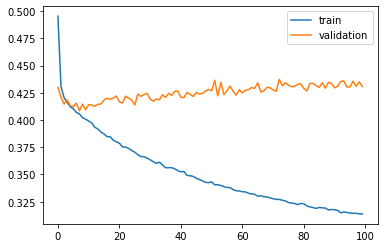

#################################
Number of units: 256
Batch size: 128
Fold: 2
best val loss: 0.4084950231181251
#################################
Time to train MLP:  361.75292706489563
Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 52s - loss: 0.4941 - val_loss: 0.4236

Epoch 00001: val_loss improved from inf to 0.42364, saving model to MLP_val_weights.hdf5
Epoch 2/100
 - 3s - loss: 0.4312 - val_loss: 0.4192

Epoch 00002: val_loss improved from 0.42364 to 0.41916, saving model to MLP_val_weights.hdf5
Epoch 3/100
 - 3s - loss: 0.4221 - val_loss: 0.4079

Epoch 00003: val_loss improved from 0.41916 to 0.40788, saving model to MLP_val_weights.hdf5
Epoch 4/100
 - 3s - loss: 0.4171 - val_loss: 0.4154

Epoch 00004: val_loss did not improve from 0.40788
Epoch 5/100
 - 3s - loss: 0.4136 - val_loss: 0.4119

Epoch 00005: val_loss did not improve from 0.40788
Epoch 6/100
 - 3s - loss: 0.4109 - val_loss: 0.4164

Epoch 00006: val_loss did not improve from 0.40788
Epoch 7/100
 - 3s 

 - 3s - loss: 0.3260 - val_loss: 0.4238

Epoch 00076: val_loss did not improve from 0.40788
Epoch 77/100
 - 3s - loss: 0.3255 - val_loss: 0.4204

Epoch 00077: val_loss did not improve from 0.40788
Epoch 78/100
 - 3s - loss: 0.3253 - val_loss: 0.4251

Epoch 00078: val_loss did not improve from 0.40788
Epoch 79/100
 - 3s - loss: 0.3239 - val_loss: 0.4238

Epoch 00079: val_loss did not improve from 0.40788
Epoch 80/100
 - 3s - loss: 0.3223 - val_loss: 0.4283

Epoch 00080: val_loss did not improve from 0.40788
Epoch 81/100
 - 3s - loss: 0.3215 - val_loss: 0.4363

Epoch 00081: val_loss did not improve from 0.40788
Epoch 82/100
 - 3s - loss: 0.3224 - val_loss: 0.4288

Epoch 00082: val_loss did not improve from 0.40788
Epoch 83/100
 - 3s - loss: 0.3229 - val_loss: 0.4286

Epoch 00083: val_loss did not improve from 0.40788
Epoch 84/100
 - 3s - loss: 0.3216 - val_loss: 0.4260

Epoch 00084: val_loss did not improve from 0.40788
Epoch 85/100
 - 3s - loss: 0.3211 - val_loss: 0.4260

Epoch 00085: v

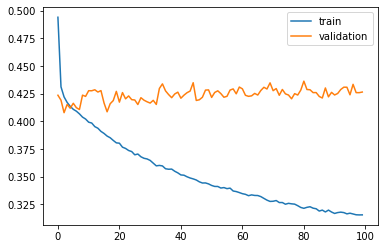

#################################
Number of units: 256
Batch size: 128
Fold: 3
best val loss: 0.40788395833969116
#################################
Time to train MLP:  370.45412015914917
Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 46s - loss: 0.4919 - val_loss: 0.4194

Epoch 00001: val_loss improved from inf to 0.41936, saving model to MLP_val_weights.hdf5
Epoch 2/100
 - 3s - loss: 0.4304 - val_loss: 0.4153

Epoch 00002: val_loss improved from 0.41936 to 0.41526, saving model to MLP_val_weights.hdf5
Epoch 3/100
 - 3s - loss: 0.4211 - val_loss: 0.4113

Epoch 00003: val_loss improved from 0.41526 to 0.41128, saving model to MLP_val_weights.hdf5
Epoch 4/100
 - 3s - loss: 0.4171 - val_loss: 0.4118

Epoch 00004: val_loss did not improve from 0.41128
Epoch 5/100
 - 3s - loss: 0.4128 - val_loss: 0.4101

Epoch 00005: val_loss improved from 0.41128 to 0.41013, saving model to MLP_val_weights.hdf5
Epoch 6/100
 - 3s - loss: 0.4102 - val_loss: 0.4079

Epoch 00006: val_loss impr

 - 3s - loss: 0.3272 - val_loss: 0.4265

Epoch 00075: val_loss did not improve from 0.40792
Epoch 76/100
 - 3s - loss: 0.3242 - val_loss: 0.4245

Epoch 00076: val_loss did not improve from 0.40792
Epoch 77/100
 - 3s - loss: 0.3247 - val_loss: 0.4261

Epoch 00077: val_loss did not improve from 0.40792
Epoch 78/100
 - 3s - loss: 0.3254 - val_loss: 0.4283

Epoch 00078: val_loss did not improve from 0.40792
Epoch 79/100
 - 3s - loss: 0.3231 - val_loss: 0.4289

Epoch 00079: val_loss did not improve from 0.40792
Epoch 80/100
 - 3s - loss: 0.3236 - val_loss: 0.4350

Epoch 00080: val_loss did not improve from 0.40792
Epoch 81/100
 - 3s - loss: 0.3233 - val_loss: 0.4263

Epoch 00081: val_loss did not improve from 0.40792
Epoch 82/100
 - 3s - loss: 0.3221 - val_loss: 0.4348

Epoch 00082: val_loss did not improve from 0.40792
Epoch 83/100
 - 3s - loss: 0.3213 - val_loss: 0.4268

Epoch 00083: val_loss did not improve from 0.40792
Epoch 84/100
 - 3s - loss: 0.3223 - val_loss: 0.4322

Epoch 00084: v

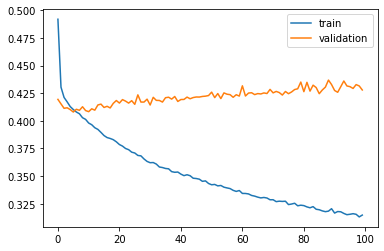

#################################
Number of units: 256
Batch size: 128
Fold: 4
best val loss: 0.4079195331997342
#################################
[[64, 128, 0, 0.4143983794848124], [64, 128, 1, 0.4114016878604889], [64, 128, 2, 0.4101881051063538], [64, 128, 3, 0.4092375793192122], [64, 128, 4, 0.4081935699780782], [64, 256, 0, 0.41274582566155327], [64, 256, 1, 0.4149344152079688], [64, 256, 2, 0.4123612467447917], [64, 256, 3, 0.4092991690635681], [64, 256, 4, 0.40954885700013904], [128, 128, 0, 0.41277814224031234], [128, 128, 1, 0.40915396282407973], [128, 128, 2, 0.40992913272645737], [128, 128, 3, 0.40633863316641916], [128, 128, 4, 0.4068948254585266], [128, 256, 0, 0.409969370815489], [128, 256, 1, 0.4085315928724077], [128, 256, 2, 0.4114747896194458], [128, 256, 3, 0.40227914039293927], [128, 256, 4, 0.402464359972212], [256, 128, 0, 0.4130744058556027], [256, 128, 1, 0.4107674022515615], [256, 128, 2, 0.4084950231181251], [256, 128, 3, 0.40788395833969116], [256, 128, 4, 0.

 - 2s - loss: 0.3219 - val_loss: 0.4284

Epoch 00066: val_loss did not improve from 0.40935
Epoch 67/100
 - 2s - loss: 0.3215 - val_loss: 0.4318

Epoch 00067: val_loss did not improve from 0.40935
Epoch 68/100
 - 2s - loss: 0.3205 - val_loss: 0.4339

Epoch 00068: val_loss did not improve from 0.40935
Epoch 69/100
 - 2s - loss: 0.3206 - val_loss: 0.4303

Epoch 00069: val_loss did not improve from 0.40935
Epoch 70/100
 - 2s - loss: 0.3184 - val_loss: 0.4315

Epoch 00070: val_loss did not improve from 0.40935
Epoch 71/100
 - 2s - loss: 0.3192 - val_loss: 0.4368

Epoch 00071: val_loss did not improve from 0.40935
Epoch 72/100
 - 2s - loss: 0.3199 - val_loss: 0.4393

Epoch 00072: val_loss did not improve from 0.40935
Epoch 73/100
 - 2s - loss: 0.3185 - val_loss: 0.4342

Epoch 00073: val_loss did not improve from 0.40935
Epoch 74/100
 - 2s - loss: 0.3179 - val_loss: 0.4265

Epoch 00074: val_loss did not improve from 0.40935
Epoch 75/100
 - 2s - loss: 0.3165 - val_loss: 0.4319

Epoch 00075: v

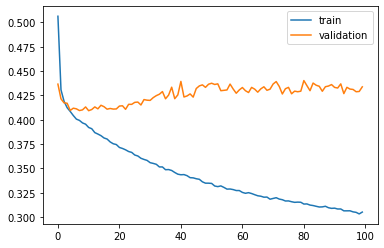

#################################
Number of units: 256
Batch size: 256
Fold: 0
best val loss: 0.4093503728972541
#################################
Time to train MLP:  233.68883204460144
Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 35s - loss: 0.5061 - val_loss: 0.4414

Epoch 00001: val_loss improved from inf to 0.44137, saving model to MLP_val_weights.hdf5
Epoch 2/100
 - 2s - loss: 0.4320 - val_loss: 0.4227

Epoch 00002: val_loss improved from 0.44137 to 0.42270, saving model to MLP_val_weights.hdf5
Epoch 3/100
 - 2s - loss: 0.4194 - val_loss: 0.4353

Epoch 00003: val_loss did not improve from 0.42270
Epoch 4/100
 - 2s - loss: 0.4138 - val_loss: 0.4236

Epoch 00004: val_loss did not improve from 0.42270
Epoch 5/100
 - 2s - loss: 0.4089 - val_loss: 0.4188

Epoch 00005: val_loss improved from 0.42270 to 0.41880, saving model to MLP_val_weights.hdf5
Epoch 6/100
 - 2s - loss: 0.4049 - val_loss: 0.4184

Epoch 00006: val_loss improved from 0.41880 to 0.41835, saving model 

 - 2s - loss: 0.3172 - val_loss: 0.4318

Epoch 00075: val_loss did not improve from 0.40813
Epoch 76/100
 - 2s - loss: 0.3153 - val_loss: 0.4353

Epoch 00076: val_loss did not improve from 0.40813
Epoch 77/100
 - 2s - loss: 0.3145 - val_loss: 0.4435

Epoch 00077: val_loss did not improve from 0.40813
Epoch 78/100
 - 2s - loss: 0.3158 - val_loss: 0.4376

Epoch 00078: val_loss did not improve from 0.40813
Epoch 79/100
 - 2s - loss: 0.3143 - val_loss: 0.4328

Epoch 00079: val_loss did not improve from 0.40813
Epoch 80/100
 - 2s - loss: 0.3128 - val_loss: 0.4319

Epoch 00080: val_loss did not improve from 0.40813
Epoch 81/100
 - 2s - loss: 0.3115 - val_loss: 0.4389

Epoch 00081: val_loss did not improve from 0.40813
Epoch 82/100
 - 2s - loss: 0.3121 - val_loss: 0.4384

Epoch 00082: val_loss did not improve from 0.40813
Epoch 83/100
 - 2s - loss: 0.3114 - val_loss: 0.4315

Epoch 00083: val_loss did not improve from 0.40813
Epoch 84/100
 - 2s - loss: 0.3124 - val_loss: 0.4352

Epoch 00084: v

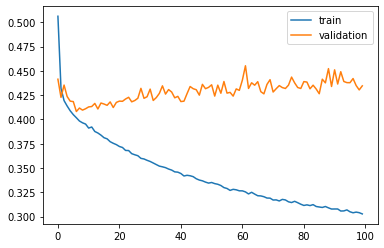

#################################
Number of units: 256
Batch size: 256
Fold: 1
best val loss: 0.4081264118088616
#################################
Time to train MLP:  240.99113178253174
Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 37s - loss: 0.5027 - val_loss: 0.4397

Epoch 00001: val_loss improved from inf to 0.43966, saving model to MLP_val_weights.hdf5
Epoch 2/100
 - 2s - loss: 0.4308 - val_loss: 0.4216

Epoch 00002: val_loss improved from 0.43966 to 0.42156, saving model to MLP_val_weights.hdf5
Epoch 3/100
 - 2s - loss: 0.4183 - val_loss: 0.4176

Epoch 00003: val_loss improved from 0.42156 to 0.41763, saving model to MLP_val_weights.hdf5
Epoch 4/100
 - 2s - loss: 0.4129 - val_loss: 0.4131

Epoch 00004: val_loss improved from 0.41763 to 0.41307, saving model to MLP_val_weights.hdf5
Epoch 5/100
 - 2s - loss: 0.4090 - val_loss: 0.4213

Epoch 00005: val_loss did not improve from 0.41307
Epoch 6/100
 - 2s - loss: 0.4036 - val_loss: 0.4197

Epoch 00006: val_loss did n


Epoch 00074: val_loss did not improve from 0.41034
Epoch 75/100
 - 2s - loss: 0.3159 - val_loss: 0.4310

Epoch 00075: val_loss did not improve from 0.41034
Epoch 76/100
 - 2s - loss: 0.3155 - val_loss: 0.4258

Epoch 00076: val_loss did not improve from 0.41034
Epoch 77/100
 - 2s - loss: 0.3153 - val_loss: 0.4326

Epoch 00077: val_loss did not improve from 0.41034
Epoch 78/100
 - 2s - loss: 0.3140 - val_loss: 0.4254

Epoch 00078: val_loss did not improve from 0.41034
Epoch 79/100
 - 2s - loss: 0.3135 - val_loss: 0.4271

Epoch 00079: val_loss did not improve from 0.41034
Epoch 80/100
 - 2s - loss: 0.3137 - val_loss: 0.4312

Epoch 00080: val_loss did not improve from 0.41034
Epoch 81/100
 - 2s - loss: 0.3125 - val_loss: 0.4322

Epoch 00081: val_loss did not improve from 0.41034
Epoch 82/100
 - 2s - loss: 0.3112 - val_loss: 0.4315

Epoch 00082: val_loss did not improve from 0.41034
Epoch 83/100
 - 2s - loss: 0.3119 - val_loss: 0.4283

Epoch 00083: val_loss did not improve from 0.41034
Epo

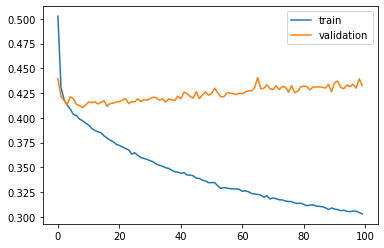

#################################
Number of units: 256
Batch size: 256
Fold: 2
best val loss: 0.41033960315916274
#################################
Time to train MLP:  245.71368408203125
Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 31s - loss: 0.5049 - val_loss: 0.4340

Epoch 00001: val_loss improved from inf to 0.43397, saving model to MLP_val_weights.hdf5
Epoch 2/100
 - 2s - loss: 0.4319 - val_loss: 0.4093

Epoch 00002: val_loss improved from 0.43397 to 0.40934, saving model to MLP_val_weights.hdf5
Epoch 3/100
 - 2s - loss: 0.4200 - val_loss: 0.4172

Epoch 00003: val_loss did not improve from 0.40934
Epoch 4/100
 - 2s - loss: 0.4130 - val_loss: 0.4002

Epoch 00004: val_loss improved from 0.40934 to 0.40023, saving model to MLP_val_weights.hdf5
Epoch 5/100
 - 2s - loss: 0.4095 - val_loss: 0.4072

Epoch 00005: val_loss did not improve from 0.40023
Epoch 6/100
 - 2s - loss: 0.4051 - val_loss: 0.4058

Epoch 00006: val_loss did not improve from 0.40023
Epoch 7/100
 - 2s

 - 2s - loss: 0.3148 - val_loss: 0.4267

Epoch 00076: val_loss did not improve from 0.40023
Epoch 77/100
 - 2s - loss: 0.3157 - val_loss: 0.4253

Epoch 00077: val_loss did not improve from 0.40023
Epoch 78/100
 - 2s - loss: 0.3149 - val_loss: 0.4310

Epoch 00078: val_loss did not improve from 0.40023
Epoch 79/100
 - 2s - loss: 0.3141 - val_loss: 0.4264

Epoch 00079: val_loss did not improve from 0.40023
Epoch 80/100
 - 2s - loss: 0.3135 - val_loss: 0.4234

Epoch 00080: val_loss did not improve from 0.40023
Epoch 81/100
 - 2s - loss: 0.3128 - val_loss: 0.4299

Epoch 00081: val_loss did not improve from 0.40023
Epoch 82/100
 - 2s - loss: 0.3127 - val_loss: 0.4287

Epoch 00082: val_loss did not improve from 0.40023
Epoch 83/100
 - 2s - loss: 0.3126 - val_loss: 0.4325

Epoch 00083: val_loss did not improve from 0.40023
Epoch 84/100
 - 2s - loss: 0.3119 - val_loss: 0.4267

Epoch 00084: val_loss did not improve from 0.40023
Epoch 85/100
 - 2s - loss: 0.3121 - val_loss: 0.4305

Epoch 00085: v

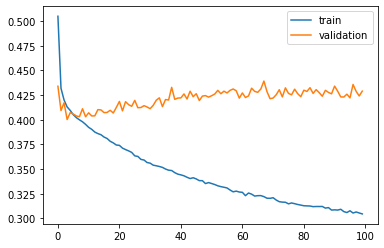

#################################
Number of units: 256
Batch size: 256
Fold: 3
best val loss: 0.40023042911953394
#################################
Time to train MLP:  238.20736575126648
Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 39s - loss: 0.5049 - val_loss: 0.4308

Epoch 00001: val_loss improved from inf to 0.43076, saving model to MLP_val_weights.hdf5
Epoch 2/100
 - 2s - loss: 0.4311 - val_loss: 0.4125

Epoch 00002: val_loss improved from 0.43076 to 0.41253, saving model to MLP_val_weights.hdf5
Epoch 3/100
 - 2s - loss: 0.4193 - val_loss: 0.4085

Epoch 00003: val_loss improved from 0.41253 to 0.40849, saving model to MLP_val_weights.hdf5
Epoch 4/100
 - 2s - loss: 0.4129 - val_loss: 0.4078

Epoch 00004: val_loss improved from 0.40849 to 0.40785, saving model to MLP_val_weights.hdf5
Epoch 5/100
 - 2s - loss: 0.4079 - val_loss: 0.4097

Epoch 00005: val_loss did not improve from 0.40785
Epoch 6/100
 - 2s - loss: 0.4041 - val_loss: 0.4045

Epoch 00006: val_loss impr

 - 2s - loss: 0.3165 - val_loss: 0.4329

Epoch 00075: val_loss did not improve from 0.40452
Epoch 76/100
 - 2s - loss: 0.3163 - val_loss: 0.4351

Epoch 00076: val_loss did not improve from 0.40452
Epoch 77/100
 - 2s - loss: 0.3160 - val_loss: 0.4362

Epoch 00077: val_loss did not improve from 0.40452
Epoch 78/100
 - 2s - loss: 0.3149 - val_loss: 0.4342

Epoch 00078: val_loss did not improve from 0.40452
Epoch 79/100
 - 2s - loss: 0.3129 - val_loss: 0.4374

Epoch 00079: val_loss did not improve from 0.40452
Epoch 80/100
 - 2s - loss: 0.3130 - val_loss: 0.4336

Epoch 00080: val_loss did not improve from 0.40452
Epoch 81/100
 - 2s - loss: 0.3131 - val_loss: 0.4400

Epoch 00081: val_loss did not improve from 0.40452
Epoch 82/100
 - 2s - loss: 0.3118 - val_loss: 0.4319

Epoch 00082: val_loss did not improve from 0.40452
Epoch 83/100
 - 2s - loss: 0.3118 - val_loss: 0.4317

Epoch 00083: val_loss did not improve from 0.40452
Epoch 84/100
 - 2s - loss: 0.3114 - val_loss: 0.4297

Epoch 00084: v

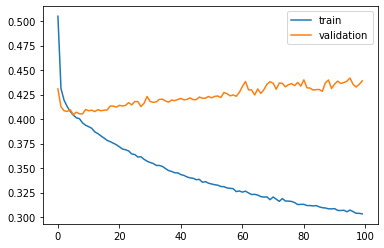

#################################
Number of units: 256
Batch size: 256
Fold: 4
best val loss: 0.40451891824934216
#################################
[[64, 128, 0, 0.4143983794848124], [64, 128, 1, 0.4114016878604889], [64, 128, 2, 0.4101881051063538], [64, 128, 3, 0.4092375793192122], [64, 128, 4, 0.4081935699780782], [64, 256, 0, 0.41274582566155327], [64, 256, 1, 0.4149344152079688], [64, 256, 2, 0.4123612467447917], [64, 256, 3, 0.4092991690635681], [64, 256, 4, 0.40954885700013904], [128, 128, 0, 0.41277814224031234], [128, 128, 1, 0.40915396282407973], [128, 128, 2, 0.40992913272645737], [128, 128, 3, 0.40633863316641916], [128, 128, 4, 0.4068948254585266], [128, 256, 0, 0.409969370815489], [128, 256, 1, 0.4085315928724077], [128, 256, 2, 0.4114747896194458], [128, 256, 3, 0.40227914039293927], [128, 256, 4, 0.402464359972212], [256, 128, 0, 0.4130744058556027], [256, 128, 1, 0.4107674022515615], [256, 128, 2, 0.4084950231181251], [256, 128, 3, 0.40788395833969116], [256, 128, 4, 0

 - 3s - loss: 0.3138 - val_loss: 0.4330

Epoch 00066: val_loss did not improve from 0.41547
Epoch 67/100
 - 3s - loss: 0.3124 - val_loss: 0.4359

Epoch 00067: val_loss did not improve from 0.41547
Epoch 68/100
 - 3s - loss: 0.3129 - val_loss: 0.4332

Epoch 00068: val_loss did not improve from 0.41547
Epoch 69/100
 - 3s - loss: 0.3133 - val_loss: 0.4453

Epoch 00069: val_loss did not improve from 0.41547
Epoch 70/100
 - 3s - loss: 0.3113 - val_loss: 0.4345

Epoch 00070: val_loss did not improve from 0.41547
Epoch 71/100
 - 3s - loss: 0.3116 - val_loss: 0.4305

Epoch 00071: val_loss did not improve from 0.41547
Epoch 72/100
 - 3s - loss: 0.3106 - val_loss: 0.4414

Epoch 00072: val_loss did not improve from 0.41547
Epoch 73/100
 - 3s - loss: 0.3098 - val_loss: 0.4410

Epoch 00073: val_loss did not improve from 0.41547
Epoch 74/100
 - 3s - loss: 0.3099 - val_loss: 0.4327

Epoch 00074: val_loss did not improve from 0.41547
Epoch 75/100
 - 3s - loss: 0.3080 - val_loss: 0.4438

Epoch 00075: v

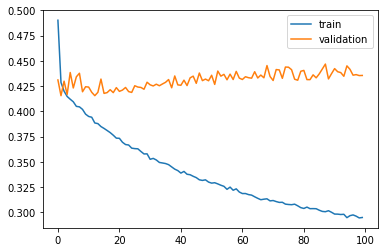

#################################
Number of units: 512
Batch size: 128
Fold: 0
best val loss: 0.4154743059741126
#################################
Time to train MLP:  369.80781865119934
Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 52s - loss: 0.4884 - val_loss: 0.4200

Epoch 00001: val_loss improved from inf to 0.41999, saving model to MLP_val_weights.hdf5
Epoch 2/100
 - 3s - loss: 0.4291 - val_loss: 0.4199

Epoch 00002: val_loss improved from 0.41999 to 0.41990, saving model to MLP_val_weights.hdf5
Epoch 3/100
 - 3s - loss: 0.4207 - val_loss: 0.4139

Epoch 00003: val_loss improved from 0.41990 to 0.41391, saving model to MLP_val_weights.hdf5
Epoch 4/100
 - 3s - loss: 0.4155 - val_loss: 0.4133

Epoch 00004: val_loss improved from 0.41391 to 0.41331, saving model to MLP_val_weights.hdf5
Epoch 5/100
 - 3s - loss: 0.4127 - val_loss: 0.4148

Epoch 00005: val_loss did not improve from 0.41331
Epoch 6/100
 - 4s - loss: 0.4104 - val_loss: 0.4181

Epoch 00006: val_loss did n


Epoch 00074: val_loss did not improve from 0.41173
Epoch 75/100
 - 3s - loss: 0.3098 - val_loss: 0.4271

Epoch 00075: val_loss did not improve from 0.41173
Epoch 76/100
 - 4s - loss: 0.3079 - val_loss: 0.4269

Epoch 00076: val_loss did not improve from 0.41173
Epoch 77/100
 - 3s - loss: 0.3055 - val_loss: 0.4348

Epoch 00077: val_loss did not improve from 0.41173
Epoch 78/100
 - 4s - loss: 0.3085 - val_loss: 0.4323

Epoch 00078: val_loss did not improve from 0.41173
Epoch 79/100
 - 3s - loss: 0.3097 - val_loss: 0.4265

Epoch 00079: val_loss did not improve from 0.41173
Epoch 80/100
 - 4s - loss: 0.3049 - val_loss: 0.4300

Epoch 00080: val_loss did not improve from 0.41173
Epoch 81/100
 - 3s - loss: 0.3054 - val_loss: 0.4328

Epoch 00081: val_loss did not improve from 0.41173
Epoch 82/100
 - 4s - loss: 0.3051 - val_loss: 0.4319

Epoch 00082: val_loss did not improve from 0.41173
Epoch 83/100
 - 3s - loss: 0.3031 - val_loss: 0.4305

Epoch 00083: val_loss did not improve from 0.41173
Epo

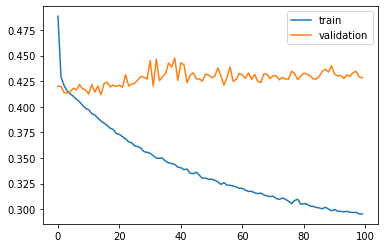

#################################
Number of units: 512
Batch size: 128
Fold: 1
best val loss: 0.411733580244912
#################################
Time to train MLP:  395.54144644737244
Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 32s - loss: 0.4807 - val_loss: 0.4283

Epoch 00001: val_loss improved from inf to 0.42826, saving model to MLP_val_weights.hdf5
Epoch 2/100
 - 4s - loss: 0.4266 - val_loss: 0.4207

Epoch 00002: val_loss improved from 0.42826 to 0.42067, saving model to MLP_val_weights.hdf5
Epoch 3/100
 - 3s - loss: 0.4198 - val_loss: 0.4155

Epoch 00003: val_loss improved from 0.42067 to 0.41551, saving model to MLP_val_weights.hdf5
Epoch 4/100
 - 3s - loss: 0.4142 - val_loss: 0.4149

Epoch 00004: val_loss improved from 0.41551 to 0.41487, saving model to MLP_val_weights.hdf5
Epoch 5/100
 - 3s - loss: 0.4122 - val_loss: 0.4209

Epoch 00005: val_loss did not improve from 0.41487
Epoch 6/100
 - 3s - loss: 0.4085 - val_loss: 0.4178

Epoch 00006: val_loss did no

 - 3s - loss: 0.3091 - val_loss: 0.4318

Epoch 00075: val_loss did not improve from 0.41158
Epoch 76/100
 - 3s - loss: 0.3067 - val_loss: 0.4347

Epoch 00076: val_loss did not improve from 0.41158
Epoch 77/100
 - 4s - loss: 0.3076 - val_loss: 0.4311

Epoch 00077: val_loss did not improve from 0.41158
Epoch 78/100
 - 3s - loss: 0.3068 - val_loss: 0.4353

Epoch 00078: val_loss did not improve from 0.41158
Epoch 79/100
 - 3s - loss: 0.3055 - val_loss: 0.4319

Epoch 00079: val_loss did not improve from 0.41158
Epoch 80/100
 - 3s - loss: 0.3055 - val_loss: 0.4311

Epoch 00080: val_loss did not improve from 0.41158
Epoch 81/100
 - 3s - loss: 0.3060 - val_loss: 0.4312

Epoch 00081: val_loss did not improve from 0.41158
Epoch 82/100
 - 3s - loss: 0.3028 - val_loss: 0.4334

Epoch 00082: val_loss did not improve from 0.41158
Epoch 83/100
 - 3s - loss: 0.3037 - val_loss: 0.4399

Epoch 00083: val_loss did not improve from 0.41158
Epoch 84/100
 - 3s - loss: 0.3022 - val_loss: 0.4360

Epoch 00084: v

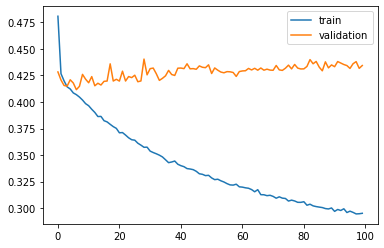

#################################
Number of units: 512
Batch size: 128
Fold: 2
best val loss: 0.41157531526353625
#################################
Time to train MLP:  377.5635483264923
Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 46s - loss: 0.4880 - val_loss: 0.4326

Epoch 00001: val_loss improved from inf to 0.43259, saving model to MLP_val_weights.hdf5
Epoch 2/100
 - 4s - loss: 0.4289 - val_loss: 0.4299

Epoch 00002: val_loss improved from 0.43259 to 0.42995, saving model to MLP_val_weights.hdf5
Epoch 3/100
 - 4s - loss: 0.4210 - val_loss: 0.4223

Epoch 00003: val_loss improved from 0.42995 to 0.42233, saving model to MLP_val_weights.hdf5
Epoch 4/100
 - 4s - loss: 0.4164 - val_loss: 0.4116

Epoch 00004: val_loss improved from 0.42233 to 0.41165, saving model to MLP_val_weights.hdf5
Epoch 5/100
 - 4s - loss: 0.4135 - val_loss: 0.4151

Epoch 00005: val_loss did not improve from 0.41165
Epoch 6/100
 - 4s - loss: 0.4091 - val_loss: 0.4254

Epoch 00006: val_loss did n


Epoch 00075: val_loss did not improve from 0.41165
Epoch 76/100
 - 3s - loss: 0.3084 - val_loss: 0.4388

Epoch 00076: val_loss did not improve from 0.41165
Epoch 77/100
 - 4s - loss: 0.3066 - val_loss: 0.4422

Epoch 00077: val_loss did not improve from 0.41165
Epoch 78/100
 - 4s - loss: 0.3063 - val_loss: 0.4270

Epoch 00078: val_loss did not improve from 0.41165
Epoch 79/100
 - 4s - loss: 0.3062 - val_loss: 0.4326

Epoch 00079: val_loss did not improve from 0.41165
Epoch 80/100
 - 3s - loss: 0.3065 - val_loss: 0.4298

Epoch 00080: val_loss did not improve from 0.41165
Epoch 81/100
 - 3s - loss: 0.3059 - val_loss: 0.4451

Epoch 00081: val_loss did not improve from 0.41165
Epoch 82/100
 - 3s - loss: 0.3053 - val_loss: 0.4378

Epoch 00082: val_loss did not improve from 0.41165
Epoch 83/100
 - 3s - loss: 0.3032 - val_loss: 0.4410

Epoch 00083: val_loss did not improve from 0.41165
Epoch 84/100
 - 4s - loss: 0.3024 - val_loss: 0.4422

Epoch 00084: val_loss did not improve from 0.41165
Epo

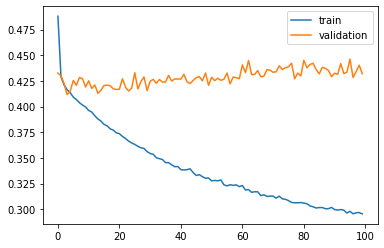

#################################
Number of units: 512
Batch size: 128
Fold: 3
best val loss: 0.41164508159955343
#################################
Time to train MLP:  396.59190487861633
Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 43s - loss: 0.4839 - val_loss: 0.4209

Epoch 00001: val_loss improved from inf to 0.42093, saving model to MLP_val_weights.hdf5
Epoch 2/100
 - 3s - loss: 0.4288 - val_loss: 0.4157

Epoch 00002: val_loss improved from 0.42093 to 0.41566, saving model to MLP_val_weights.hdf5
Epoch 3/100
 - 4s - loss: 0.4205 - val_loss: 0.4131

Epoch 00003: val_loss improved from 0.41566 to 0.41311, saving model to MLP_val_weights.hdf5
Epoch 4/100
 - 3s - loss: 0.4159 - val_loss: 0.4107

Epoch 00004: val_loss improved from 0.41311 to 0.41072, saving model to MLP_val_weights.hdf5
Epoch 5/100
 - 3s - loss: 0.4122 - val_loss: 0.4099

Epoch 00005: val_loss improved from 0.41072 to 0.40993, saving model to MLP_val_weights.hdf5
Epoch 6/100
 - 3s - loss: 0.4082 - va


Epoch 00074: val_loss did not improve from 0.40991
Epoch 75/100
 - 3s - loss: 0.3087 - val_loss: 0.4253

Epoch 00075: val_loss did not improve from 0.40991
Epoch 76/100
 - 3s - loss: 0.3078 - val_loss: 0.4245

Epoch 00076: val_loss did not improve from 0.40991
Epoch 77/100
 - 3s - loss: 0.3085 - val_loss: 0.4278

Epoch 00077: val_loss did not improve from 0.40991
Epoch 78/100
 - 3s - loss: 0.3073 - val_loss: 0.4330

Epoch 00078: val_loss did not improve from 0.40991
Epoch 79/100
 - 3s - loss: 0.3057 - val_loss: 0.4259

Epoch 00079: val_loss did not improve from 0.40991
Epoch 80/100
 - 3s - loss: 0.3063 - val_loss: 0.4329

Epoch 00080: val_loss did not improve from 0.40991
Epoch 81/100
 - 4s - loss: 0.3040 - val_loss: 0.4287

Epoch 00081: val_loss did not improve from 0.40991
Epoch 82/100
 - 4s - loss: 0.3050 - val_loss: 0.4300

Epoch 00082: val_loss did not improve from 0.40991
Epoch 83/100
 - 4s - loss: 0.3027 - val_loss: 0.4274

Epoch 00083: val_loss did not improve from 0.40991
Epo

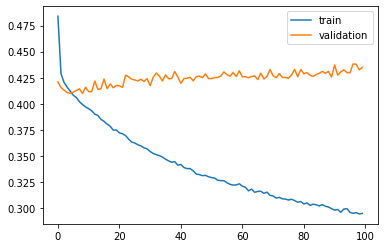

#################################
Number of units: 512
Batch size: 128
Fold: 4
best val loss: 0.40991216251585216
#################################
[[64, 128, 0, 0.4143983794848124], [64, 128, 1, 0.4114016878604889], [64, 128, 2, 0.4101881051063538], [64, 128, 3, 0.4092375793192122], [64, 128, 4, 0.4081935699780782], [64, 256, 0, 0.41274582566155327], [64, 256, 1, 0.4149344152079688], [64, 256, 2, 0.4123612467447917], [64, 256, 3, 0.4092991690635681], [64, 256, 4, 0.40954885700013904], [128, 128, 0, 0.41277814224031234], [128, 128, 1, 0.40915396282407973], [128, 128, 2, 0.40992913272645737], [128, 128, 3, 0.40633863316641916], [128, 128, 4, 0.4068948254585266], [128, 256, 0, 0.409969370815489], [128, 256, 1, 0.4085315928724077], [128, 256, 2, 0.4114747896194458], [128, 256, 3, 0.40227914039293927], [128, 256, 4, 0.402464359972212], [256, 128, 0, 0.4130744058556027], [256, 128, 1, 0.4107674022515615], [256, 128, 2, 0.4084950231181251], [256, 128, 3, 0.40788395833969116], [256, 128, 4, 0

 - 2s - loss: 0.3004 - val_loss: 0.4376

Epoch 00064: val_loss did not improve from 0.41022
Epoch 65/100
 - 2s - loss: 0.3007 - val_loss: 0.4409


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 - 2s - loss: 0.2977 - val_loss: 0.4455

Epoch 00067: val_loss did not improve from 0.41022
Epoch 68/100
 - 2s - loss: 0.2980 - val_loss: 0.4406

Epoch 00068: val_loss did not improve from 0.41022
Epoch 69/100
 - 2s - loss: 0.2976 - val_loss: 0.4327

Epoch 00069: val_loss did not improve from 0.41022
Epoch 70/100
 - 2s - loss: 0.2975 - val_loss: 0.4369

Epoch 00070: val_loss did not improve from 0.41022
Epoch 71/100
 - 2s - loss: 0.2947 - val_loss: 0.4401

Epoch 00071: val_loss did not improve from 0.41022
Epoch 72/100
 - 2s - loss: 0.2957 - val_loss: 0.4334

Epoch 00072: val_loss did not improve from 0.41022
Epoch 73/100
 - 2s - loss: 0.2950 - val_loss: 0.4330

Epoch 00073: val_loss did not improve from 0.41022
Epoch 74/100
 - 2s - loss: 0.2943 - val_loss: 0.4355

Epoch 00074: val_loss did not improve from 0.41022
Epoch 75/100
 - 2s - loss: 0.2917 - val_loss: 0.4419

Epoch 00075: val_loss did not improve from 0.41022
Epoch 76/100
 - 2s - loss: 0.2912 - val_loss: 0.4401

Epoch 00076: v

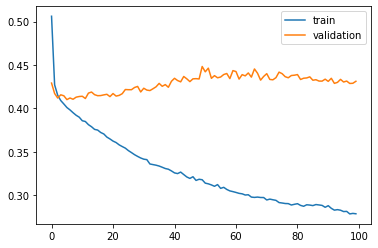

#################################
Number of units: 512
Batch size: 256
Fold: 0
best val loss: 0.4102210602495405
#################################
Time to train MLP:  307.54604959487915
Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 29s - loss: 0.5110 - val_loss: 0.4315

Epoch 00001: val_loss improved from inf to 0.43153, saving model to MLP_val_weights.hdf5
Epoch 2/100
 - 2s - loss: 0.4291 - val_loss: 0.4193

Epoch 00002: val_loss improved from 0.43153 to 0.41932, saving model to MLP_val_weights.hdf5
Epoch 3/100
 - 2s - loss: 0.4170 - val_loss: 0.4109

Epoch 00003: val_loss improved from 0.41932 to 0.41086, saving model to MLP_val_weights.hdf5
Epoch 4/100
 - 2s - loss: 0.4105 - val_loss: 0.4095

Epoch 00004: val_loss improved from 0.41086 to 0.40955, saving model to MLP_val_weights.hdf5
Epoch 5/100
 - 2s - loss: 0.4054 - val_loss: 0.4176

Epoch 00005: val_loss did not improve from 0.40955
Epoch 6/100
 - 2s - loss: 0.4022 - val_loss: 0.4147

Epoch 00006: val_loss did n


Epoch 00074: val_loss did not improve from 0.40689
Epoch 75/100
 - 2s - loss: 0.2977 - val_loss: 0.4635

Epoch 00075: val_loss did not improve from 0.40689
Epoch 76/100
 - 2s - loss: 0.2949 - val_loss: 0.4444

Epoch 00076: val_loss did not improve from 0.40689
Epoch 77/100
 - 2s - loss: 0.2925 - val_loss: 0.4544

Epoch 00077: val_loss did not improve from 0.40689
Epoch 78/100
 - 2s - loss: 0.2906 - val_loss: 0.4548

Epoch 00078: val_loss did not improve from 0.40689
Epoch 79/100
 - 2s - loss: 0.2893 - val_loss: 0.4444

Epoch 00079: val_loss did not improve from 0.40689
Epoch 80/100
 - 2s - loss: 0.2886 - val_loss: 0.4500

Epoch 00080: val_loss did not improve from 0.40689
Epoch 81/100
 - 2s - loss: 0.2903 - val_loss: 0.4455

Epoch 00081: val_loss did not improve from 0.40689
Epoch 82/100
 - 2s - loss: 0.2894 - val_loss: 0.4496

Epoch 00082: val_loss did not improve from 0.40689
Epoch 83/100
 - 2s - loss: 0.2871 - val_loss: 0.4554

Epoch 00083: val_loss did not improve from 0.40689
Epo

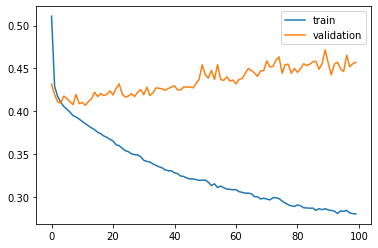

#################################
Number of units: 512
Batch size: 256
Fold: 1
best val loss: 0.4068857502407498
#################################
Time to train MLP:  250.6252338886261
Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 29s - loss: 0.5014 - val_loss: 0.4351

Epoch 00001: val_loss improved from inf to 0.43505, saving model to MLP_val_weights.hdf5
Epoch 2/100
 - 2s - loss: 0.4273 - val_loss: 0.4179

Epoch 00002: val_loss improved from 0.43505 to 0.41788, saving model to MLP_val_weights.hdf5
Epoch 3/100
 - 2s - loss: 0.4162 - val_loss: 0.4166

Epoch 00003: val_loss improved from 0.41788 to 0.41660, saving model to MLP_val_weights.hdf5
Epoch 4/100
 - 2s - loss: 0.4095 - val_loss: 0.4187

Epoch 00004: val_loss did not improve from 0.41660
Epoch 5/100
 - 2s - loss: 0.4050 - val_loss: 0.4140

Epoch 00005: val_loss improved from 0.41660 to 0.41398, saving model to MLP_val_weights.hdf5
Epoch 6/100
 - 2s - loss: 0.4018 - val_loss: 0.4125

Epoch 00006: val_loss improv

 - 2s - loss: 0.2966 - val_loss: 0.4355

Epoch 00075: val_loss did not improve from 0.41252
Epoch 76/100
 - 2s - loss: 0.2940 - val_loss: 0.4360

Epoch 00076: val_loss did not improve from 0.41252
Epoch 77/100
 - 2s - loss: 0.2923 - val_loss: 0.4301

Epoch 00077: val_loss did not improve from 0.41252
Epoch 78/100
 - 2s - loss: 0.2894 - val_loss: 0.4333

Epoch 00078: val_loss did not improve from 0.41252
Epoch 79/100
 - 2s - loss: 0.2886 - val_loss: 0.4359

Epoch 00079: val_loss did not improve from 0.41252
Epoch 80/100
 - 2s - loss: 0.2898 - val_loss: 0.4329

Epoch 00080: val_loss did not improve from 0.41252
Epoch 81/100
 - 2s - loss: 0.2887 - val_loss: 0.4373

Epoch 00081: val_loss did not improve from 0.41252
Epoch 82/100
 - 2s - loss: 0.2894 - val_loss: 0.4343

Epoch 00082: val_loss did not improve from 0.41252
Epoch 83/100
 - 2s - loss: 0.2879 - val_loss: 0.4338

Epoch 00083: val_loss did not improve from 0.41252
Epoch 84/100
 - 2s - loss: 0.2846 - val_loss: 0.4282

Epoch 00084: v

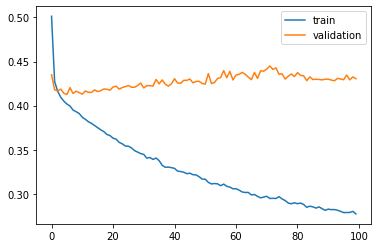

#################################
Number of units: 512
Batch size: 256
Fold: 2
best val loss: 0.41252297910054525
#################################
Time to train MLP:  249.5110318660736
Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 30s - loss: 0.4976 - val_loss: 0.4254

Epoch 00001: val_loss improved from inf to 0.42536, saving model to MLP_val_weights.hdf5
Epoch 2/100
 - 2s - loss: 0.4277 - val_loss: 0.4126

Epoch 00002: val_loss improved from 0.42536 to 0.41262, saving model to MLP_val_weights.hdf5
Epoch 3/100
 - 2s - loss: 0.4175 - val_loss: 0.4067

Epoch 00003: val_loss improved from 0.41262 to 0.40666, saving model to MLP_val_weights.hdf5
Epoch 4/100
 - 2s - loss: 0.4110 - val_loss: 0.4045

Epoch 00004: val_loss improved from 0.40666 to 0.40455, saving model to MLP_val_weights.hdf5
Epoch 5/100
 - 2s - loss: 0.4074 - val_loss: 0.4030

Epoch 00005: val_loss improved from 0.40455 to 0.40299, saving model to MLP_val_weights.hdf5
Epoch 6/100
 - 2s - loss: 0.4020 - val

 - 2s - loss: 0.2960 - val_loss: 0.4233

Epoch 00074: val_loss did not improve from 0.40106
Epoch 75/100
 - 2s - loss: 0.2942 - val_loss: 0.4245

Epoch 00075: val_loss did not improve from 0.40106
Epoch 76/100
 - 2s - loss: 0.2919 - val_loss: 0.4203

Epoch 00076: val_loss did not improve from 0.40106
Epoch 77/100
 - 2s - loss: 0.2908 - val_loss: 0.4285

Epoch 00077: val_loss did not improve from 0.40106
Epoch 78/100
 - 2s - loss: 0.2910 - val_loss: 0.4267

Epoch 00078: val_loss did not improve from 0.40106
Epoch 79/100
 - 2s - loss: 0.2907 - val_loss: 0.4224

Epoch 00079: val_loss did not improve from 0.40106
Epoch 80/100
 - 2s - loss: 0.2893 - val_loss: 0.4279

Epoch 00080: val_loss did not improve from 0.40106
Epoch 81/100
 - 2s - loss: 0.2890 - val_loss: 0.4211

Epoch 00081: val_loss did not improve from 0.40106
Epoch 82/100
 - 2s - loss: 0.2889 - val_loss: 0.4239

Epoch 00082: val_loss did not improve from 0.40106
Epoch 83/100
 - 2s - loss: 0.2863 - val_loss: 0.4298

Epoch 00083: v

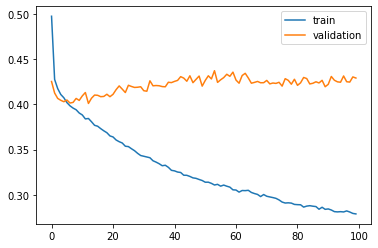

#################################
Number of units: 512
Batch size: 256
Fold: 3
best val loss: 0.40105973715252347
#################################
Time to train MLP:  247.7338306903839
Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 29s - loss: 0.4921 - val_loss: 0.4172

Epoch 00001: val_loss improved from inf to 0.41722, saving model to MLP_val_weights.hdf5
Epoch 2/100
 - 2s - loss: 0.4262 - val_loss: 0.4135

Epoch 00002: val_loss improved from 0.41722 to 0.41346, saving model to MLP_val_weights.hdf5
Epoch 3/100
 - 2s - loss: 0.4154 - val_loss: 0.4063

Epoch 00003: val_loss improved from 0.41346 to 0.40631, saving model to MLP_val_weights.hdf5
Epoch 4/100
 - 2s - loss: 0.4099 - val_loss: 0.4070

Epoch 00004: val_loss did not improve from 0.40631
Epoch 5/100
 - 2s - loss: 0.4053 - val_loss: 0.4078

Epoch 00005: val_loss did not improve from 0.40631
Epoch 6/100
 - 2s - loss: 0.4014 - val_loss: 0.4070

Epoch 00006: val_loss did not improve from 0.40631
Epoch 7/100
 - 2s 

 - 2s - loss: 0.2923 - val_loss: 0.4314

Epoch 00076: val_loss did not improve from 0.40631
Epoch 77/100
 - 2s - loss: 0.2898 - val_loss: 0.4362

Epoch 00077: val_loss did not improve from 0.40631
Epoch 78/100
 - 2s - loss: 0.2921 - val_loss: 0.4365

Epoch 00078: val_loss did not improve from 0.40631
Epoch 79/100
 - 2s - loss: 0.2897 - val_loss: 0.4370

Epoch 00079: val_loss did not improve from 0.40631
Epoch 80/100
 - 2s - loss: 0.2903 - val_loss: 0.4347

Epoch 00080: val_loss did not improve from 0.40631
Epoch 81/100
 - 2s - loss: 0.2895 - val_loss: 0.4416

Epoch 00081: val_loss did not improve from 0.40631
Epoch 82/100
 - 2s - loss: 0.2881 - val_loss: 0.4330

Epoch 00082: val_loss did not improve from 0.40631
Epoch 83/100
 - 2s - loss: 0.2890 - val_loss: 0.4375

Epoch 00083: val_loss did not improve from 0.40631
Epoch 84/100
 - 2s - loss: 0.2880 - val_loss: 0.4355

Epoch 00084: val_loss did not improve from 0.40631
Epoch 85/100
 - 2s - loss: 0.2880 - val_loss: 0.4365

Epoch 00085: v

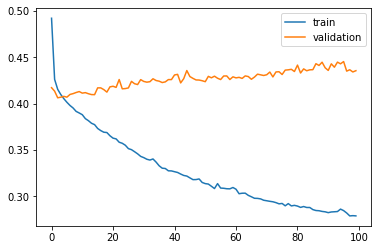

#################################
Number of units: 512
Batch size: 256
Fold: 4
best val loss: 0.4063125110202365
#################################
[[64, 128, 0, 0.4143983794848124], [64, 128, 1, 0.4114016878604889], [64, 128, 2, 0.4101881051063538], [64, 128, 3, 0.4092375793192122], [64, 128, 4, 0.4081935699780782], [64, 256, 0, 0.41274582566155327], [64, 256, 1, 0.4149344152079688], [64, 256, 2, 0.4123612467447917], [64, 256, 3, 0.4092991690635681], [64, 256, 4, 0.40954885700013904], [128, 128, 0, 0.41277814224031234], [128, 128, 1, 0.40915396282407973], [128, 128, 2, 0.40992913272645737], [128, 128, 3, 0.40633863316641916], [128, 128, 4, 0.4068948254585266], [128, 256, 0, 0.409969370815489], [128, 256, 1, 0.4085315928724077], [128, 256, 2, 0.4114747896194458], [128, 256, 3, 0.40227914039293927], [128, 256, 4, 0.402464359972212], [256, 128, 0, 0.4130744058556027], [256, 128, 1, 0.4107674022515615], [256, 128, 2, 0.4084950231181251], [256, 128, 3, 0.40788395833969116], [256, 128, 4, 0.


Epoch 00060: val_loss did not improve from 0.41969
Epoch 61/100
 - 4s - loss: 0.3125 - val_loss: 0.4351

Epoch 00061: val_loss did not improve from 0.41969
Epoch 62/100
 - 4s - loss: 0.3103 - val_loss: 0.4310

Epoch 00062: val_loss did not improve from 0.41969
Epoch 63/100
 - 4s - loss: 0.3095 - val_loss: 0.4362

Epoch 00063: val_loss did not improve from 0.41969
Epoch 64/100
 - 4s - loss: 0.3070 - val_loss: 0.4372

Epoch 00064: val_loss did not improve from 0.41969
Epoch 65/100
 - 4s - loss: 0.3058 - val_loss: 0.4371

Epoch 00065: val_loss did not improve from 0.41969
Epoch 66/100
 - 4s - loss: 0.3065 - val_loss: 0.4463

Epoch 00066: val_loss did not improve from 0.41969
Epoch 67/100
 - 4s - loss: 0.3041 - val_loss: 0.4448

Epoch 00067: val_loss did not improve from 0.41969
Epoch 68/100
 - 4s - loss: 0.3032 - val_loss: 0.4444

Epoch 00068: val_loss did not improve from 0.41969
Epoch 69/100
 - 4s - loss: 0.3050 - val_loss: 0.4512

Epoch 00069: val_loss did not improve from 0.41969
Epo

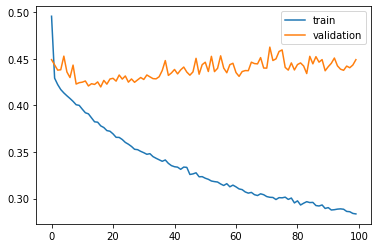

#################################
Number of units: 1024
Batch size: 128
Fold: 0
best val loss: 0.4196872142155965
#################################
Time to train MLP:  429.03459429740906
Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 31s - loss: 0.4902 - val_loss: 0.4206

Epoch 00001: val_loss improved from inf to 0.42062, saving model to MLP_val_weights.hdf5
Epoch 2/100
 - 4s - loss: 0.4296 - val_loss: 0.4228

Epoch 00002: val_loss did not improve from 0.42062
Epoch 3/100
 - 4s - loss: 0.4214 - val_loss: 0.4126

Epoch 00003: val_loss improved from 0.42062 to 0.41263, saving model to MLP_val_weights.hdf5
Epoch 4/100
 - 4s - loss: 0.4165 - val_loss: 0.4163

Epoch 00004: val_loss did not improve from 0.41263
Epoch 5/100
 - 4s - loss: 0.4137 - val_loss: 0.4156

Epoch 00005: val_loss did not improve from 0.41263
Epoch 6/100
 - 4s - loss: 0.4100 - val_loss: 0.4143

Epoch 00006: val_loss did not improve from 0.41263
Epoch 7/100
 - 4s - loss: 0.4073 - val_loss: 0.4246

Epoch 

 - 4s - loss: 0.3006 - val_loss: 0.4345

Epoch 00076: val_loss did not improve from 0.41049
Epoch 77/100
 - 4s - loss: 0.2994 - val_loss: 0.4421

Epoch 00077: val_loss did not improve from 0.41049
Epoch 78/100
 - 4s - loss: 0.2993 - val_loss: 0.4468

Epoch 00078: val_loss did not improve from 0.41049
Epoch 79/100
 - 4s - loss: 0.2986 - val_loss: 0.4464

Epoch 00079: val_loss did not improve from 0.41049
Epoch 80/100
 - 4s - loss: 0.2978 - val_loss: 0.4374

Epoch 00080: val_loss did not improve from 0.41049
Epoch 81/100
 - 4s - loss: 0.2991 - val_loss: 0.4467

Epoch 00081: val_loss did not improve from 0.41049
Epoch 82/100
 - 4s - loss: 0.2976 - val_loss: 0.4492

Epoch 00082: val_loss did not improve from 0.41049
Epoch 83/100
 - 4s - loss: 0.2950 - val_loss: 0.4459

Epoch 00083: val_loss did not improve from 0.41049
Epoch 84/100
 - 4s - loss: 0.2939 - val_loss: 0.4403

Epoch 00084: val_loss did not improve from 0.41049
Epoch 85/100
 - 4s - loss: 0.2926 - val_loss: 0.4477

Epoch 00085: v

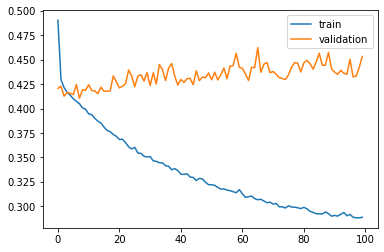

#################################
Number of units: 1024
Batch size: 128
Fold: 1
best val loss: 0.41049165405167476
#################################
Time to train MLP:  434.82595777511597
Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 31s - loss: 0.4876 - val_loss: 0.4359

Epoch 00001: val_loss improved from inf to 0.43587, saving model to MLP_val_weights.hdf5
Epoch 2/100
 - 4s - loss: 0.4306 - val_loss: 0.4258

Epoch 00002: val_loss improved from 0.43587 to 0.42580, saving model to MLP_val_weights.hdf5
Epoch 3/100
 - 4s - loss: 0.4208 - val_loss: 0.4285

Epoch 00003: val_loss did not improve from 0.42580
Epoch 4/100
 - 4s - loss: 0.4156 - val_loss: 0.4234

Epoch 00004: val_loss improved from 0.42580 to 0.42343, saving model to MLP_val_weights.hdf5
Epoch 5/100
 - 4s - loss: 0.4128 - val_loss: 0.4252

Epoch 00005: val_loss did not improve from 0.42343
Epoch 6/100
 - 4s - loss: 0.4112 - val_loss: 0.4217

Epoch 00006: val_loss improved from 0.42343 to 0.42170, saving mode

 - 4s - loss: 0.2998 - val_loss: 0.4369

Epoch 00074: val_loss did not improve from 0.41800
Epoch 75/100
 - 4s - loss: 0.3004 - val_loss: 0.4372

Epoch 00075: val_loss did not improve from 0.41800
Epoch 76/100
 - 4s - loss: 0.2985 - val_loss: 0.4373

Epoch 00076: val_loss did not improve from 0.41800
Epoch 77/100
 - 4s - loss: 0.2997 - val_loss: 0.4443

Epoch 00077: val_loss did not improve from 0.41800
Epoch 78/100
 - 4s - loss: 0.3004 - val_loss: 0.4428

Epoch 00078: val_loss did not improve from 0.41800
Epoch 79/100
 - 4s - loss: 0.2951 - val_loss: 0.4461

Epoch 00079: val_loss did not improve from 0.41800
Epoch 80/100
 - 4s - loss: 0.2957 - val_loss: 0.4423

Epoch 00080: val_loss did not improve from 0.41800
Epoch 81/100
 - 4s - loss: 0.2961 - val_loss: 0.4401

Epoch 00081: val_loss did not improve from 0.41800
Epoch 82/100
 - 4s - loss: 0.2961 - val_loss: 0.4345

Epoch 00082: val_loss did not improve from 0.41800
Epoch 83/100
 - 4s - loss: 0.2947 - val_loss: 0.4417

Epoch 00083: v

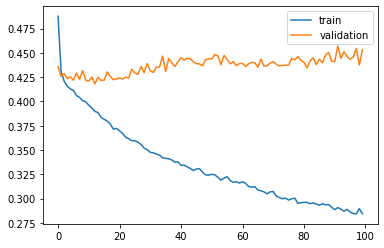

#################################
Number of units: 1024
Batch size: 128
Fold: 2
best val loss: 0.41800133853488497
#################################
Time to train MLP:  430.20585107803345
Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 41s - loss: 0.4860 - val_loss: 0.4308

Epoch 00001: val_loss improved from inf to 0.43084, saving model to MLP_val_weights.hdf5
Epoch 2/100
 - 4s - loss: 0.4300 - val_loss: 0.4234

Epoch 00002: val_loss improved from 0.43084 to 0.42343, saving model to MLP_val_weights.hdf5
Epoch 3/100
 - 4s - loss: 0.4220 - val_loss: 0.4164

Epoch 00003: val_loss improved from 0.42343 to 0.41639, saving model to MLP_val_weights.hdf5
Epoch 4/100
 - 4s - loss: 0.4175 - val_loss: 0.4339

Epoch 00004: val_loss did not improve from 0.41639
Epoch 5/100
 - 4s - loss: 0.4135 - val_loss: 0.4069

Epoch 00005: val_loss improved from 0.41639 to 0.40695, saving model to MLP_val_weights.hdf5
Epoch 6/100
 - 4s - loss: 0.4103 - val_loss: 0.4140

Epoch 00006: val_loss did


Epoch 00075: val_loss did not improve from 0.40695
Epoch 76/100
 - 4s - loss: 0.3012 - val_loss: 0.4339

Epoch 00076: val_loss did not improve from 0.40695
Epoch 77/100
 - 4s - loss: 0.3031 - val_loss: 0.4402

Epoch 00077: val_loss did not improve from 0.40695
Epoch 78/100
 - 4s - loss: 0.2999 - val_loss: 0.4311

Epoch 00078: val_loss did not improve from 0.40695
Epoch 79/100
 - 4s - loss: 0.2979 - val_loss: 0.4315

Epoch 00079: val_loss did not improve from 0.40695
Epoch 80/100
 - 4s - loss: 0.2958 - val_loss: 0.4419

Epoch 00080: val_loss did not improve from 0.40695
Epoch 81/100
 - 4s - loss: 0.2974 - val_loss: 0.4321

Epoch 00081: val_loss did not improve from 0.40695
Epoch 82/100
 - 4s - loss: 0.2979 - val_loss: 0.4421

Epoch 00082: val_loss did not improve from 0.40695
Epoch 83/100
 - 4s - loss: 0.2957 - val_loss: 0.4350

Epoch 00083: val_loss did not improve from 0.40695
Epoch 84/100
 - 4s - loss: 0.2939 - val_loss: 0.4319

Epoch 00084: val_loss did not improve from 0.40695
Epo

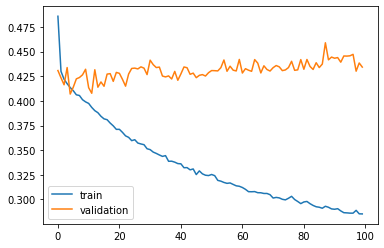

#################################
Number of units: 1024
Batch size: 128
Fold: 3
best val loss: 0.40694885926776464
#################################
Time to train MLP:  442.28964161872864
Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 31s - loss: 0.4855 - val_loss: 0.4293

Epoch 00001: val_loss improved from inf to 0.42934, saving model to MLP_val_weights.hdf5
Epoch 2/100
 - 4s - loss: 0.4290 - val_loss: 0.4202

Epoch 00002: val_loss improved from 0.42934 to 0.42017, saving model to MLP_val_weights.hdf5
Epoch 3/100
 - 4s - loss: 0.4199 - val_loss: 0.4197

Epoch 00003: val_loss improved from 0.42017 to 0.41969, saving model to MLP_val_weights.hdf5
Epoch 4/100
 - 4s - loss: 0.4171 - val_loss: 0.4242

Epoch 00004: val_loss did not improve from 0.41969
Epoch 5/100
 - 4s - loss: 0.4130 - val_loss: 0.4273

Epoch 00005: val_loss did not improve from 0.41969
Epoch 6/100
 - 4s - loss: 0.4093 - val_loss: 0.4165

Epoch 00006: val_loss improved from 0.41969 to 0.41651, saving mode


Epoch 00074: val_loss did not improve from 0.41255
Epoch 75/100
 - 4s - loss: 0.3049 - val_loss: 0.4342

Epoch 00075: val_loss did not improve from 0.41255
Epoch 76/100
 - 4s - loss: 0.3025 - val_loss: 0.4393

Epoch 00076: val_loss did not improve from 0.41255
Epoch 77/100
 - 4s - loss: 0.3004 - val_loss: 0.4332

Epoch 00077: val_loss did not improve from 0.41255
Epoch 78/100
 - 4s - loss: 0.3021 - val_loss: 0.4322

Epoch 00078: val_loss did not improve from 0.41255
Epoch 79/100
 - 4s - loss: 0.3000 - val_loss: 0.4329

Epoch 00079: val_loss did not improve from 0.41255
Epoch 80/100
 - 4s - loss: 0.2964 - val_loss: 0.4314

Epoch 00080: val_loss did not improve from 0.41255
Epoch 81/100
 - 4s - loss: 0.2982 - val_loss: 0.4366

Epoch 00081: val_loss did not improve from 0.41255
Epoch 82/100
 - 4s - loss: 0.2965 - val_loss: 0.4359

Epoch 00082: val_loss did not improve from 0.41255
Epoch 83/100
 - 4s - loss: 0.2962 - val_loss: 0.4363

Epoch 00083: val_loss did not improve from 0.41255
Epo

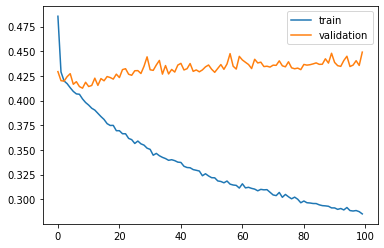

#################################
Number of units: 1024
Batch size: 128
Fold: 4
best val loss: 0.41255153375201753
#################################
[[64, 128, 0, 0.4143983794848124], [64, 128, 1, 0.4114016878604889], [64, 128, 2, 0.4101881051063538], [64, 128, 3, 0.4092375793192122], [64, 128, 4, 0.4081935699780782], [64, 256, 0, 0.41274582566155327], [64, 256, 1, 0.4149344152079688], [64, 256, 2, 0.4123612467447917], [64, 256, 3, 0.4092991690635681], [64, 256, 4, 0.40954885700013904], [128, 128, 0, 0.41277814224031234], [128, 128, 1, 0.40915396282407973], [128, 128, 2, 0.40992913272645737], [128, 128, 3, 0.40633863316641916], [128, 128, 4, 0.4068948254585266], [128, 256, 0, 0.409969370815489], [128, 256, 1, 0.4085315928724077], [128, 256, 2, 0.4114747896194458], [128, 256, 3, 0.40227914039293927], [128, 256, 4, 0.402464359972212], [256, 128, 0, 0.4130744058556027], [256, 128, 1, 0.4107674022515615], [256, 128, 2, 0.4084950231181251], [256, 128, 3, 0.40788395833969116], [256, 128, 4, 


Epoch 00059: val_loss did not improve from 0.41212
Epoch 60/100
 - 2s - loss: 0.2935 - val_loss: 0.4414

Epoch 00060: val_loss did not improve from 0.41212
Epoch 61/100
 - 2s - loss: 0.2921 - val_loss: 0.4423

Epoch 00061: val_loss did not improve from 0.41212
Epoch 62/100
 - 2s - loss: 0.2906 - val_loss: 0.4420

Epoch 00062: val_loss did not improve from 0.41212
Epoch 63/100
 - 2s - loss: 0.2898 - val_loss: 0.4362

Epoch 00063: val_loss did not improve from 0.41212
Epoch 64/100
 - 2s - loss: 0.2917 - val_loss: 0.4378

Epoch 00064: val_loss did not improve from 0.41212
Epoch 65/100
 - 2s - loss: 0.2894 - val_loss: 0.4363

Epoch 00065: val_loss did not improve from 0.41212
Epoch 66/100
 - 2s - loss: 0.2899 - val_loss: 0.4344

Epoch 00066: val_loss did not improve from 0.41212
Epoch 67/100
 - 2s - loss: 0.2860 - val_loss: 0.4361

Epoch 00067: val_loss did not improve from 0.41212
Epoch 68/100
 - 2s - loss: 0.2860 - val_loss: 0.4337

Epoch 00068: val_loss did not improve from 0.41212
Epo

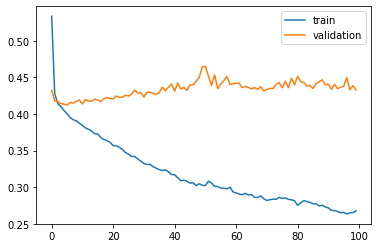

#################################
Number of units: 1024
Batch size: 256
Fold: 0
best val loss: 0.4121195867061615
#################################
Time to train MLP:  281.97823190689087
Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 31s - loss: 0.5143 - val_loss: 0.4358

Epoch 00001: val_loss improved from inf to 0.43577, saving model to MLP_val_weights.hdf5
Epoch 2/100
 - 3s - loss: 0.4274 - val_loss: 0.4164

Epoch 00002: val_loss improved from 0.43577 to 0.41642, saving model to MLP_val_weights.hdf5
Epoch 3/100
 - 3s - loss: 0.4160 - val_loss: 0.4180

Epoch 00003: val_loss did not improve from 0.41642
Epoch 4/100
 - 3s - loss: 0.4093 - val_loss: 0.4120

Epoch 00004: val_loss improved from 0.41642 to 0.41195, saving model to MLP_val_weights.hdf5
Epoch 5/100
 - 3s - loss: 0.4054 - val_loss: 0.4125

Epoch 00005: val_loss did not improve from 0.41195
Epoch 6/100
 - 3s - loss: 0.4002 - val_loss: 0.4077

Epoch 00006: val_loss improved from 0.41195 to 0.40770, saving model


Epoch 00075: val_loss did not improve from 0.40770
Epoch 76/100
 - 3s - loss: 0.2807 - val_loss: 0.4655

Epoch 00076: val_loss did not improve from 0.40770
Epoch 77/100
 - 3s - loss: 0.2820 - val_loss: 0.4751

Epoch 00077: val_loss did not improve from 0.40770
Epoch 78/100
 - 3s - loss: 0.2810 - val_loss: 0.4625

Epoch 00078: val_loss did not improve from 0.40770
Epoch 79/100
 - 3s - loss: 0.2809 - val_loss: 0.4519

Epoch 00079: val_loss did not improve from 0.40770
Epoch 80/100
 - 3s - loss: 0.2744 - val_loss: 0.4578

Epoch 00080: val_loss did not improve from 0.40770
Epoch 81/100
 - 3s - loss: 0.2752 - val_loss: 0.4581

Epoch 00081: val_loss did not improve from 0.40770
Epoch 82/100
 - 3s - loss: 0.2728 - val_loss: 0.4461

Epoch 00082: val_loss did not improve from 0.40770
Epoch 83/100
 - 3s - loss: 0.2709 - val_loss: 0.4589

Epoch 00083: val_loss did not improve from 0.40770
Epoch 84/100
 - 3s - loss: 0.2719 - val_loss: 0.4662

Epoch 00084: val_loss did not improve from 0.40770
Epo

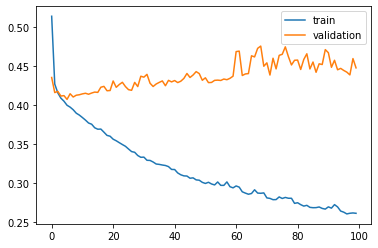

#################################
Number of units: 1024
Batch size: 256
Fold: 1
best val loss: 0.4076982309553358
#################################
Time to train MLP:  288.2973110675812
Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 32s - loss: 0.5060 - val_loss: 0.4310

Epoch 00001: val_loss improved from inf to 0.43104, saving model to MLP_val_weights.hdf5
Epoch 2/100
 - 3s - loss: 0.4246 - val_loss: 0.4179

Epoch 00002: val_loss improved from 0.43104 to 0.41788, saving model to MLP_val_weights.hdf5
Epoch 3/100
 - 3s - loss: 0.4149 - val_loss: 0.4179

Epoch 00003: val_loss did not improve from 0.41788
Epoch 4/100
 - 3s - loss: 0.4100 - val_loss: 0.4155

Epoch 00004: val_loss improved from 0.41788 to 0.41550, saving model to MLP_val_weights.hdf5
Epoch 5/100
 - 3s - loss: 0.4031 - val_loss: 0.4138

Epoch 00005: val_loss improved from 0.41550 to 0.41383, saving model to MLP_val_weights.hdf5
Epoch 6/100
 - 3s - loss: 0.3990 - val_loss: 0.4146

Epoch 00006: val_loss did n

 - 2s - loss: 0.2833 - val_loss: 0.4334

Epoch 00075: val_loss did not improve from 0.41295
Epoch 76/100
 - 2s - loss: 0.2770 - val_loss: 0.4347

Epoch 00076: val_loss did not improve from 0.41295
Epoch 77/100
 - 2s - loss: 0.2746 - val_loss: 0.4319

Epoch 00077: val_loss did not improve from 0.41295
Epoch 78/100
 - 2s - loss: 0.2728 - val_loss: 0.4302

Epoch 00078: val_loss did not improve from 0.41295
Epoch 79/100
 - 2s - loss: 0.2715 - val_loss: 0.4351

Epoch 00079: val_loss did not improve from 0.41295
Epoch 80/100
 - 2s - loss: 0.2725 - val_loss: 0.4336

Epoch 00080: val_loss did not improve from 0.41295
Epoch 81/100
 - 2s - loss: 0.2726 - val_loss: 0.4364

Epoch 00081: val_loss did not improve from 0.41295
Epoch 82/100
 - 3s - loss: 0.2733 - val_loss: 0.4337

Epoch 00082: val_loss did not improve from 0.41295
Epoch 83/100
 - 3s - loss: 0.2750 - val_loss: 0.4353

Epoch 00083: val_loss did not improve from 0.41295
Epoch 84/100
 - 3s - loss: 0.2727 - val_loss: 0.4349

Epoch 00084: v

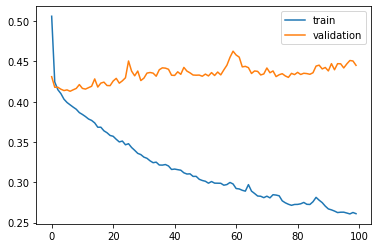

#################################
Number of units: 1024
Batch size: 256
Fold: 2
best val loss: 0.4129462646643321
#################################
Time to train MLP:  286.70223689079285
Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 31s - loss: 0.5164 - val_loss: 0.4250

Epoch 00001: val_loss improved from inf to 0.42496, saving model to MLP_val_weights.hdf5
Epoch 2/100
 - 2s - loss: 0.4278 - val_loss: 0.4133

Epoch 00002: val_loss improved from 0.42496 to 0.41327, saving model to MLP_val_weights.hdf5
Epoch 3/100
 - 2s - loss: 0.4168 - val_loss: 0.4124

Epoch 00003: val_loss improved from 0.41327 to 0.41236, saving model to MLP_val_weights.hdf5
Epoch 4/100
 - 3s - loss: 0.4099 - val_loss: 0.4033

Epoch 00004: val_loss improved from 0.41236 to 0.40332, saving model to MLP_val_weights.hdf5
Epoch 5/100
 - 2s - loss: 0.4056 - val_loss: 0.4044

Epoch 00005: val_loss did not improve from 0.40332
Epoch 6/100
 - 2s - loss: 0.4009 - val_loss: 0.4097

Epoch 00006: val_loss did 


Epoch 00075: val_loss did not improve from 0.40332
Epoch 76/100
 - 2s - loss: 0.2758 - val_loss: 0.4297

Epoch 00076: val_loss did not improve from 0.40332
Epoch 77/100
 - 3s - loss: 0.2753 - val_loss: 0.4329

Epoch 00077: val_loss did not improve from 0.40332
Epoch 78/100
 - 2s - loss: 0.2752 - val_loss: 0.4347

Epoch 00078: val_loss did not improve from 0.40332
Epoch 79/100
 - 2s - loss: 0.2722 - val_loss: 0.4279

Epoch 00079: val_loss did not improve from 0.40332
Epoch 80/100
 - 2s - loss: 0.2724 - val_loss: 0.4259

Epoch 00080: val_loss did not improve from 0.40332
Epoch 81/100
 - 2s - loss: 0.2714 - val_loss: 0.4286

Epoch 00081: val_loss did not improve from 0.40332
Epoch 82/100
 - 2s - loss: 0.2723 - val_loss: 0.4282

Epoch 00082: val_loss did not improve from 0.40332
Epoch 83/100
 - 2s - loss: 0.2723 - val_loss: 0.4359

Epoch 00083: val_loss did not improve from 0.40332
Epoch 84/100
 - 2s - loss: 0.2706 - val_loss: 0.4348

Epoch 00084: val_loss did not improve from 0.40332
Epo

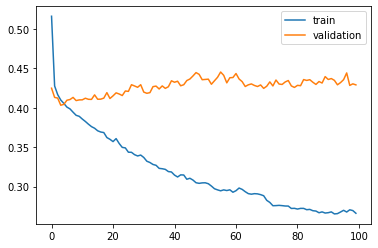

#################################
Number of units: 1024
Batch size: 256
Fold: 3
best val loss: 0.4033245387342241
#################################
Time to train MLP:  282.9765536785126
Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 31s - loss: 0.5174 - val_loss: 0.4257

Epoch 00001: val_loss improved from inf to 0.42572, saving model to MLP_val_weights.hdf5
Epoch 2/100
 - 2s - loss: 0.4272 - val_loss: 0.4189

Epoch 00002: val_loss improved from 0.42572 to 0.41888, saving model to MLP_val_weights.hdf5
Epoch 3/100
 - 2s - loss: 0.4149 - val_loss: 0.4114

Epoch 00003: val_loss improved from 0.41888 to 0.41144, saving model to MLP_val_weights.hdf5
Epoch 4/100
 - 2s - loss: 0.4095 - val_loss: 0.4148

Epoch 00004: val_loss did not improve from 0.41144
Epoch 5/100
 - 2s - loss: 0.4041 - val_loss: 0.4102

Epoch 00005: val_loss improved from 0.41144 to 0.41024, saving model to MLP_val_weights.hdf5
Epoch 6/100
 - 2s - loss: 0.4006 - val_loss: 0.4121

Epoch 00006: val_loss did n


Epoch 00075: val_loss did not improve from 0.41024
Epoch 76/100
 - 2s - loss: 0.2789 - val_loss: 0.4443

Epoch 00076: val_loss did not improve from 0.41024
Epoch 77/100
 - 2s - loss: 0.2791 - val_loss: 0.4560

Epoch 00077: val_loss did not improve from 0.41024
Epoch 78/100
 - 2s - loss: 0.2800 - val_loss: 0.4444

Epoch 00078: val_loss did not improve from 0.41024
Epoch 79/100
 - 2s - loss: 0.2816 - val_loss: 0.4470

Epoch 00079: val_loss did not improve from 0.41024
Epoch 80/100
 - 2s - loss: 0.2780 - val_loss: 0.4453

Epoch 00080: val_loss did not improve from 0.41024
Epoch 81/100
 - 2s - loss: 0.2828 - val_loss: 0.4387

Epoch 00081: val_loss did not improve from 0.41024
Epoch 82/100
 - 2s - loss: 0.2768 - val_loss: 0.4405

Epoch 00082: val_loss did not improve from 0.41024
Epoch 83/100
 - 2s - loss: 0.2812 - val_loss: 0.4358

Epoch 00083: val_loss did not improve from 0.41024
Epoch 84/100
 - 2s - loss: 0.2780 - val_loss: 0.4339

Epoch 00084: val_loss did not improve from 0.41024
Epo

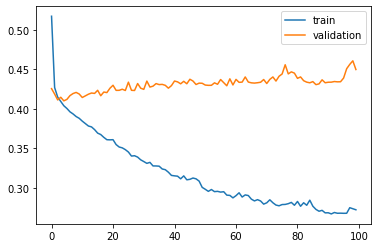

#################################
Number of units: 1024
Batch size: 256
Fold: 4
best val loss: 0.4102448157204522
#################################
[[64, 128, 0, 0.4143983794848124], [64, 128, 1, 0.4114016878604889], [64, 128, 2, 0.4101881051063538], [64, 128, 3, 0.4092375793192122], [64, 128, 4, 0.4081935699780782], [64, 256, 0, 0.41274582566155327], [64, 256, 1, 0.4149344152079688], [64, 256, 2, 0.4123612467447917], [64, 256, 3, 0.4092991690635681], [64, 256, 4, 0.40954885700013904], [128, 128, 0, 0.41277814224031234], [128, 128, 1, 0.40915396282407973], [128, 128, 2, 0.40992913272645737], [128, 128, 3, 0.40633863316641916], [128, 128, 4, 0.4068948254585266], [128, 256, 0, 0.409969370815489], [128, 256, 1, 0.4085315928724077], [128, 256, 2, 0.4114747896194458], [128, 256, 3, 0.40227914039293927], [128, 256, 4, 0.402464359972212], [256, 128, 0, 0.4130744058556027], [256, 128, 1, 0.4107674022515615], [256, 128, 2, 0.4084950231181251], [256, 128, 3, 0.40788395833969116], [256, 128, 4, 0

In [22]:
from numpy.random import seed
seed(2)
from tensorflow import set_random_seed
set_random_seed(2)

num_per_fold = x_train.shape[0]//10
print(num_per_fold)

units_list = [64, 128, 256, 512, 1024]# [8, 16, 32, 64, 128]
batch_size_list = [128, 256] #[512, 1024, 2048] #[128, 256, 512, 1024, 2048]

start_time = time.time()

exp_record = []

for n_units in units_list:
    for b_size in batch_size_list:
        for f in range(5):#10
            #start = f*num_per_fold
            end = (f+1)*num_per_fold
            train1_x = x_train[:end, ]
            train2_x = x_train[end:, ]
            train_x_mlp = np.append(train2_x, train1_x, axis=0) #new obj
            train1_y = y_train[:end, ]
            train2_y = y_train[end:, ]
            train_y_mlp = np.append(train2_y, train1_y, axis=0)

            start_time_inner = time.time()
            with tf.Session(config = tf.ConfigProto(log_device_placement = True)):
                seed(1)
                set_random_seed(1)
                model = setup_model(n_units, 0.25, 0.25)
                v_loss = fit_model(model, train_x_mlp,
                                   train_y_mlp, b_size)
                print("#################################")
                print("Number of units:", n_units)
                print("Batch size:", b_size)
                print("Fold:", f)
                print("best val loss:", v_loss)
                exp_record.append([n_units, b_size, f, v_loss])
                print("#################################")
            if (f==4):
                print(exp_record)
            end_time = time.time()
            print("Time to train MLP: ", time.time() - start_time_inner)
print("Entire process took: ", time.time() - start_time)

print("Experiment record:")
print(exp_record)

In [23]:
#exp_record = [[256, 128, 0, 0.4181921254793803], [256, 128, 1, 0.41392930693096586], [256, 128, 2, 0.41352690209282766], [256, 128, 3, 0.41044004991319444], [256, 128, 4, 0.40839054359330074], [256, 256, 0, 0.41712053820821976], [256, 256, 1, 0.41326970418294273], [256, 256, 2, 0.4126927588250902], [256, 256, 3, 0.40249974740876093], [256, 256, 4, 0.4092540219624837], [256, 512, 0, 0.4180781000190311], [256, 512, 1, 0.41272810400856863], [256, 512, 2, 0.4130118726624383], [256, 512, 3, 0.4043361015849643], [256, 512, 4, 0.41233868871794804], [256, 1024, 0, 0.42470460081100464], [256, 1024, 1, 0.4148659051789178], [256, 1024, 2, 0.413696536593967], [256, 1024, 3, 0.4090125660366482], [256, 1024, 4, 0.4104899652004242], [256, 2048, 0, 0.4223843531873491], [256, 2048, 1, 0.41779777002334595], [256, 2048, 2, 0.42145742728975083], [256, 2048, 3, 0.409669627878401], [256, 2048, 4, 0.4162793987062242], [512, 128, 0, 0.42340454382366605], [512, 128, 1, 0.41417210732565984], [512, 128, 2, 0.41662925820880464], [512, 128, 3, 0.41143868870205347], [512, 128, 4, 0.4111231329176161], [512, 256, 0, 0.417803515513738], [512, 256, 1, 0.4155055482652452], [512, 256, 2, 0.41380404074986776], [512, 256, 3, 0.4023575717608134], [512, 256, 4, 0.40978617389996846], [512, 512, 0, 0.4204557643731435], [512, 512, 1, 0.41912202972835966], [512, 512, 2, 0.41246501241789923], [512, 512, 3, 0.4035640990469191], [512, 512, 4, 0.4128174678749508], [512, 1024, 0, 0.4232236155403985], [512, 1024, 1, 0.4158491341802809], [512, 1024, 2, 0.4157241357432471], [512, 1024, 3, 0.4061613963180118], [512, 1024, 4, 0.41554672214719984], [512, 2048, 0, 0.4258451512919532], [512, 2048, 1, 0.4209722838136885], [512, 2048, 2, 0.42472765352990893], [512, 2048, 3, 0.41450725200441146], [512, 2048, 4, 0.4210363691382938], [1024, 128, 0, 0.42695660225550336], [1024, 128, 1, 0.416806053770913], [1024, 128, 2, 0.42002821644147237], [1024, 128, 3, 0.4158343187438117], [1024, 128, 4, 0.41393871519300673], [1024, 256, 0, 0.4206898342238532], [1024, 256, 1, 0.41405825090408327], [1024, 256, 2, 0.41935524662335716], [1024, 256, 3, 0.4064217465453678], [1024, 256, 4, 0.4150205192036099], [1024, 512, 0, 0.4206249733236101], [1024, 512, 1, 0.41506470425923664], [1024, 512, 2, 0.4169338222079807], [1024, 512, 3, 0.40536283564567566], [1024, 512, 4, 0.4124235230286916], [1024, 1024, 0, 0.4238303425576952], [1024, 1024, 1, 0.41690259801016916], [1024, 1024, 2, 0.41674665914641484], [1024, 1024, 3, 0.40718043133947585], [1024, 1024, 4, 0.4152604450384776], [1024, 2048, 0, 0.4300396858586205], [1024, 2048, 1, 0.4266932406425476], [1024, 2048, 2, 0.4239716788927714], [1024, 2048, 3, 0.4191103452046712], [1024, 2048, 4, 0.42024023180537756]]
complete_v = np.array(exp_record)
print(complete_v.shape)

val_loss_list = []
for i in range(10):
    h_params = complete_v[(i*5):((i+1)*5), :]
    print("###############################")
    print("Units:", h_params[0, 0])
    print("Batch size:", h_params[0, 1])
    #print("Val loss (mean):", np.mean(h_params[:, 3]))
    #print("Val loss (std):", np.std(h_params[:, 3]))
    print("Val loss (mean):", 
          np.round(np.mean(h_params[:, 3]), decimals=5))
    print("Val loss (std):", 
          np.round(np.std(h_params[:, 3]), decimals=5))
    print("###############################")
    val_loss_list.append(np.mean(h_params[:, 3]))
print(min(val_loss_list))

(50, 4)
###############################
Units: 64.0
Batch size: 128.0
Val loss (mean): 0.41068
Val loss (std): 0.00214
###############################
###############################
Units: 64.0
Batch size: 256.0
Val loss (mean): 0.41178
Val loss (std): 0.00211
###############################
###############################
Units: 128.0
Batch size: 128.0
Val loss (mean): 0.40902
Val loss (std): 0.00231
###############################
###############################
Units: 128.0
Batch size: 256.0
Val loss (mean): 0.40694
Val loss (std): 0.00385
###############################
###############################
Units: 256.0
Batch size: 128.0
Val loss (mean): 0.40963
Val loss (std): 0.00202
###############################
###############################
Units: 256.0
Batch size: 256.0
Val loss (mean): 0.40651
Val loss (std): 0.00371
###############################
###############################
Units: 512.0
Batch size: 128.0
Val loss (mean): 0.41207
Val loss (std): 0.00183
##################

In [14]:
###########################
# generate random numbers
# for dropout rate
###########################
from numpy.random import seed
seed(112)
# dropout rate for 1st dropout
# layer 1, 2(between 0.0 and 0.5)
# seed 111 for mean TCHDL 
# Extend because of edge case in layer 2
# seed 112 for mean TCHDL layer 1 (between 0.0, 0.5) layer 2 between (0.5, 1.0)
dropout_rate_1_list = []
for i in range(25):
    dropout_rate_1_list.append(np.random.uniform(0.0, 0.5))
# dropout rate for 2nd dropout
# layer (between 0.0 and 0.5)
dropout_rate_2_list = []
for i in range(25):
    dropout_rate_2_list.append(np.random.uniform(0.5, 1.0))
print(min(dropout_rate_1_list))
print(max(dropout_rate_1_list))
print(min(dropout_rate_2_list))
print(max(dropout_rate_2_list))
print(dropout_rate_1_list)
print(dropout_rate_2_list)

0.0012780158616721993
0.4905996388603758
0.5225040861638903
0.9928342799563638
[0.18752856443664256, 0.3201523099613221, 0.4750082897025835, 0.03783860235103076, 0.38846482935906024, 0.41637288128092964, 0.027402870141204128, 0.4088386910876341, 0.44267572903638336, 0.3611732554036228, 0.0012780158616721993, 0.4905996388603758, 0.17170992538358082, 0.047379944088102144, 0.19732129434741763, 0.002472462405860354, 0.36835341513363445, 0.47790343474278035, 0.4103046856572887, 0.17249149804310943, 0.1892722289026565, 0.39238180748494084, 0.04311575651871297, 0.27303696890041906, 0.08111301014441535]
[0.6450348628460724, 0.5225040861638903, 0.6660938786649698, 0.868266608120274, 0.9196057426053866, 0.8546808073064938, 0.5942005583054051, 0.9928342799563638, 0.6940016540227223, 0.7515772409619305, 0.881765162651011, 0.8418662247501874, 0.8609786907012036, 0.6070760453819448, 0.8815462894869308, 0.5376080776907113, 0.8054453508528189, 0.7128152123280982, 0.6171755435019305, 0.7745143587906921

In [15]:
dropout_rate_1_list = [0.17249149804310943, 0.1892722289026565, 0.39238180748494084, 0.04311575651871297, 0.27303696890041906, 0.08111301014441535]
dropout_rate_2_list = [0.7745143587906921, 0.7884498762400916, 0.7740081291875598, 0.5774557497867832, 0.8162807405267526, 0.5545717087158022]
print(len(dropout_rate_1_list) == len(dropout_rate_2_list))

True


9000
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 2s - loss: 0.5638 - val_loss: 0.4434

Epoch 00001: val_loss improved from inf to 0.44340, saving model to MLP_val_weights.hdf5
Epoch 2/100
 - 1s - loss: 0.4663 - val_loss: 0.4260

Epoch 00002: val_loss improved from 0.44340 to 0.42598, saving model to MLP_val_weights.hdf5
Epoch 3/100
 - 1s - loss: 0.4544 - val_loss: 0.4182

Epoch 00003: val_loss improved from 0.42598 to 0.41823, saving model to MLP_val_weights.hdf5
Epoch 4/100
 - 1s - loss: 0.4463 - val_loss: 0.4154

Epoch 00004: val_loss improved from 0.41823 to 0.41543, saving model to MLP_val_weights.hdf5
Epoch 5/100
 - 1s - loss: 0.4419 - val_loss: 0.4121

Epoch 00005: val_loss improved from 0.41543 to 0.41206, saving model to MLP_va

 - 1s - loss: 0.3626 - val_loss: 0.4282

Epoch 00067: val_loss did not improve from 0.41005
Epoch 68/100
 - 1s - loss: 0.3625 - val_loss: 0.4295

Epoch 00068: val_loss did not improve from 0.41005
Epoch 69/100
 - 1s - loss: 0.3604 - val_loss: 0.4330

Epoch 00069: val_loss did not improve from 0.41005
Epoch 70/100
 - 1s - loss: 0.3606 - val_loss: 0.4323

Epoch 00070: val_loss did not improve from 0.41005
Epoch 71/100
 - 1s - loss: 0.3603 - val_loss: 0.4328

Epoch 00071: val_loss did not improve from 0.41005
Epoch 72/100
 - 1s - loss: 0.3599 - val_loss: 0.4285

Epoch 00072: val_loss did not improve from 0.41005
Epoch 73/100
 - 1s - loss: 0.3606 - val_loss: 0.4308

Epoch 00073: val_loss did not improve from 0.41005
Epoch 74/100
 - 1s - loss: 0.3590 - val_loss: 0.4291

Epoch 00074: val_loss did not improve from 0.41005
Epoch 75/100
 - 1s - loss: 0.3578 - val_loss: 0.4305

Epoch 00075: val_loss did not improve from 0.41005
Epoch 76/100
 - 1s - loss: 0.3575 - val_loss: 0.4313

Epoch 00076: v

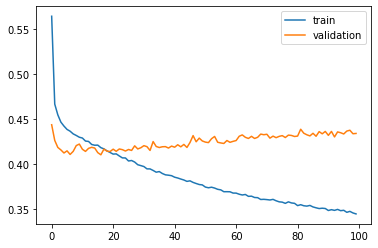

#################################
Number of units: 256
Batch size: 256
Dropout rate 1: 0.17249149804310943
Dropout rate 2: 0.7745143587906921
Fold: 0
Best val loss: 0.41004832951227826
#################################
Time to train MLP:  109.40728425979614
Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 1s - loss: 0.5664 - val_loss: 0.4341

Epoch 00001: val_loss improved from inf to 0.43413, saving model to MLP_val_weights.hdf5
Epoch 2/100
 - 1s - loss: 0.4665 - val_loss: 0.4257

Epoch 00002: val_loss improved from 0.43413 to 0.42567, saving model to MLP_val_weights.hdf5
Epoch 3/100
 - 1s - loss: 0.4548 - val_loss: 0.4311

Epoch 00003: val_loss did not improve from 0.42567
Epoch 4/100
 - 1s - loss: 0.4475 - val_loss: 0.4230

Epoch 00004: val_loss improved from 0.42567 to 0.42300, saving model to MLP_val_weights.hdf5
Epoch 5/100
 - 1s - loss: 0.4426 - val_loss: 0.4165

Epoch 00005: val_loss improved from 0.42300 to 0.41655, saving model to MLP_val_weights.hdf5
Epoch 6/1

 - 1s - loss: 0.3594 - val_loss: 0.4255

Epoch 00074: val_loss did not improve from 0.40810
Epoch 75/100
 - 1s - loss: 0.3577 - val_loss: 0.4269

Epoch 00075: val_loss did not improve from 0.40810
Epoch 76/100
 - 1s - loss: 0.3583 - val_loss: 0.4219

Epoch 00076: val_loss did not improve from 0.40810
Epoch 77/100
 - 1s - loss: 0.3570 - val_loss: 0.4275

Epoch 00077: val_loss did not improve from 0.40810
Epoch 78/100
 - 1s - loss: 0.3570 - val_loss: 0.4248

Epoch 00078: val_loss did not improve from 0.40810
Epoch 79/100
 - 1s - loss: 0.3553 - val_loss: 0.4231

Epoch 00079: val_loss did not improve from 0.40810
Epoch 80/100
 - 1s - loss: 0.3564 - val_loss: 0.4231

Epoch 00080: val_loss did not improve from 0.40810
Epoch 81/100
 - 1s - loss: 0.3559 - val_loss: 0.4272

Epoch 00081: val_loss did not improve from 0.40810
Epoch 82/100
 - 1s - loss: 0.3542 - val_loss: 0.4304

Epoch 00082: val_loss did not improve from 0.40810
Epoch 83/100
 - 1s - loss: 0.3547 - val_loss: 0.4258

Epoch 00083: v

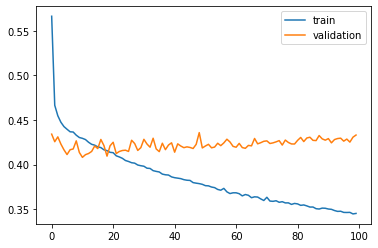

#################################
Number of units: 256
Batch size: 256
Dropout rate 1: 0.17249149804310943
Dropout rate 2: 0.7745143587906921
Fold: 1
Best val loss: 0.4080996023548974
#################################
Time to train MLP:  108.86472177505493
Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 1s - loss: 0.5625 - val_loss: 0.4409

Epoch 00001: val_loss improved from inf to 0.44087, saving model to MLP_val_weights.hdf5
Epoch 2/100
 - 1s - loss: 0.4655 - val_loss: 0.4183

Epoch 00002: val_loss improved from 0.44087 to 0.41834, saving model to MLP_val_weights.hdf5
Epoch 3/100
 - 1s - loss: 0.4510 - val_loss: 0.4144

Epoch 00003: val_loss improved from 0.41834 to 0.41438, saving model to MLP_val_weights.hdf5
Epoch 4/100
 - 1s - loss: 0.4454 - val_loss: 0.4168

Epoch 00004: val_loss did not improve from 0.41438
Epoch 5/100
 - 1s - loss: 0.4422 - val_loss: 0.4151

Epoch 00005: val_loss did not improve from 0.41438
Epoch 6/100
 - 1s - loss: 0.4380 - val_loss: 0.4171



Epoch 00073: val_loss did not improve from 0.41256
Epoch 74/100
 - 1s - loss: 0.3608 - val_loss: 0.4312

Epoch 00074: val_loss did not improve from 0.41256
Epoch 75/100
 - 1s - loss: 0.3600 - val_loss: 0.4298

Epoch 00075: val_loss did not improve from 0.41256
Epoch 76/100
 - 1s - loss: 0.3580 - val_loss: 0.4315

Epoch 00076: val_loss did not improve from 0.41256
Epoch 77/100
 - 1s - loss: 0.3583 - val_loss: 0.4361

Epoch 00077: val_loss did not improve from 0.41256
Epoch 78/100
 - 1s - loss: 0.3578 - val_loss: 0.4347

Epoch 00078: val_loss did not improve from 0.41256
Epoch 79/100
 - 1s - loss: 0.3576 - val_loss: 0.4351

Epoch 00079: val_loss did not improve from 0.41256
Epoch 80/100
 - 1s - loss: 0.3564 - val_loss: 0.4334

Epoch 00080: val_loss did not improve from 0.41256
Epoch 81/100
 - 1s - loss: 0.3562 - val_loss: 0.4327

Epoch 00081: val_loss did not improve from 0.41256
Epoch 82/100
 - 1s - loss: 0.3560 - val_loss: 0.4326

Epoch 00082: val_loss did not improve from 0.41256
Epo

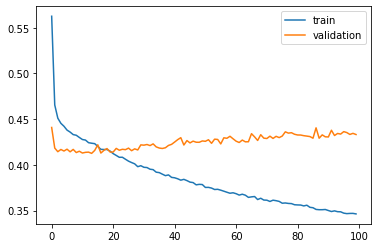

#################################
Number of units: 256
Batch size: 256
Dropout rate 1: 0.17249149804310943
Dropout rate 2: 0.7745143587906921
Fold: 2
Best val loss: 0.4125597271919251
#################################
Time to train MLP:  109.59219193458557
Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 1s - loss: 0.5681 - val_loss: 0.4384

Epoch 00001: val_loss improved from inf to 0.43844, saving model to MLP_val_weights.hdf5
Epoch 2/100
 - 1s - loss: 0.4690 - val_loss: 0.4292

Epoch 00002: val_loss improved from 0.43844 to 0.42923, saving model to MLP_val_weights.hdf5
Epoch 3/100
 - 1s - loss: 0.4543 - val_loss: 0.4143

Epoch 00003: val_loss improved from 0.42923 to 0.41432, saving model to MLP_val_weights.hdf5
Epoch 4/100
 - 1s - loss: 0.4470 - val_loss: 0.4146

Epoch 00004: val_loss did not improve from 0.41432
Epoch 5/100
 - 1s - loss: 0.4432 - val_loss: 0.4105

Epoch 00005: val_loss improved from 0.41432 to 0.41047, saving model to MLP_val_weights.hdf5
Epoch 6/10

 - 1s - loss: 0.3611 - val_loss: 0.4307

Epoch 00073: val_loss did not improve from 0.40100
Epoch 74/100
 - 1s - loss: 0.3595 - val_loss: 0.4228

Epoch 00074: val_loss did not improve from 0.40100
Epoch 75/100
 - 1s - loss: 0.3593 - val_loss: 0.4233

Epoch 00075: val_loss did not improve from 0.40100
Epoch 76/100
 - 1s - loss: 0.3590 - val_loss: 0.4249

Epoch 00076: val_loss did not improve from 0.40100
Epoch 77/100
 - 1s - loss: 0.3588 - val_loss: 0.4306

Epoch 00077: val_loss did not improve from 0.40100
Epoch 78/100
 - 1s - loss: 0.3574 - val_loss: 0.4294

Epoch 00078: val_loss did not improve from 0.40100
Epoch 79/100
 - 1s - loss: 0.3561 - val_loss: 0.4276

Epoch 00079: val_loss did not improve from 0.40100
Epoch 80/100
 - 1s - loss: 0.3566 - val_loss: 0.4257

Epoch 00080: val_loss did not improve from 0.40100
Epoch 81/100
 - 1s - loss: 0.3560 - val_loss: 0.4267

Epoch 00081: val_loss did not improve from 0.40100
Epoch 82/100
 - 1s - loss: 0.3534 - val_loss: 0.4280

Epoch 00082: v

Exception ignored in: <bound method BaseSession._Callable.__del__ of <tensorflow.python.client.session.BaseSession._Callable object at 0x7fb2303c4f60>>
Traceback (most recent call last):
  File "/home/whsu014/.conda/envs/whsuphd/lib/python3.6/site-packages/tensorflow/python/client/session.py", line 1455, in __del__
    self._session._session, self._handle, status)
  File "/home/whsu014/.conda/envs/whsuphd/lib/python3.6/site-packages/tensorflow/python/framework/errors_impl.py", line 528, in __exit__
    c_api.TF_GetCode(self.status.status))
tensorflow.python.framework.errors_impl.CancelledError: Session has been closed.
Exception ignored in: <bound method BaseSession._Callable.__del__ of <tensorflow.python.client.session.BaseSession._Callable object at 0x7fb230164dd8>>
Traceback (most recent call last):
  File "/home/whsu014/.conda/envs/whsuphd/lib/python3.6/site-packages/tensorflow/python/client/session.py", line 1455, in __del__
    self._session._session, self._handle, status)
  File

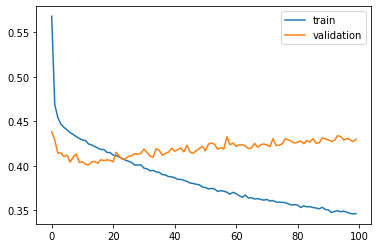

#################################
Number of units: 256
Batch size: 256
Dropout rate 1: 0.17249149804310943
Dropout rate 2: 0.7745143587906921
Fold: 3
Best val loss: 0.40099650237295364
#################################
Time to train MLP:  111.33892869949341
Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 2s - loss: 0.5645 - val_loss: 0.4306

Epoch 00001: val_loss improved from inf to 0.43062, saving model to MLP_val_weights.hdf5
Epoch 2/100
 - 1s - loss: 0.4669 - val_loss: 0.4155

Epoch 00002: val_loss improved from 0.43062 to 0.41548, saving model to MLP_val_weights.hdf5
Epoch 3/100
 - 1s - loss: 0.4543 - val_loss: 0.4095

Epoch 00003: val_loss improved from 0.41548 to 0.40954, saving model to MLP_val_weights.hdf5
Epoch 4/100
 - 1s - loss: 0.4464 - val_loss: 0.4143

Epoch 00004: val_loss did not improve from 0.40954
Epoch 5/100
 - 1s - loss: 0.4432 - val_loss: 0.4134

Epoch 00005: val_loss did not improve from 0.40954
Epoch 6/100
 - 1s - loss: 0.4388 - val_loss: 0.4113

 - 1s - loss: 0.3583 - val_loss: 0.4295

Epoch 00075: val_loss did not improve from 0.40650
Epoch 76/100
 - 1s - loss: 0.3584 - val_loss: 0.4333

Epoch 00076: val_loss did not improve from 0.40650
Epoch 77/100
 - 1s - loss: 0.3573 - val_loss: 0.4340

Epoch 00077: val_loss did not improve from 0.40650
Epoch 78/100
 - 1s - loss: 0.3568 - val_loss: 0.4334

Epoch 00078: val_loss did not improve from 0.40650
Epoch 79/100
 - 1s - loss: 0.3567 - val_loss: 0.4336

Epoch 00079: val_loss did not improve from 0.40650
Epoch 80/100
 - 1s - loss: 0.3567 - val_loss: 0.4321

Epoch 00080: val_loss did not improve from 0.40650
Epoch 81/100
 - 1s - loss: 0.3567 - val_loss: 0.4324

Epoch 00081: val_loss did not improve from 0.40650
Epoch 82/100
 - 1s - loss: 0.3563 - val_loss: 0.4342

Epoch 00082: val_loss did not improve from 0.40650
Epoch 83/100
 - 1s - loss: 0.3533 - val_loss: 0.4402

Epoch 00083: val_loss did not improve from 0.40650
Epoch 84/100
 - 1s - loss: 0.3541 - val_loss: 0.4321

Epoch 00084: v

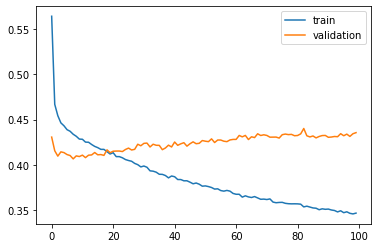

#################################
Number of units: 256
Batch size: 256
Dropout rate 1: 0.17249149804310943
Dropout rate 2: 0.7745143587906921
Fold: 4
Best val loss: 0.4064964518547058
#################################
[[256, 256, 0.17249149804310943, 0.7745143587906921, 0, 0.41004832951227826], [256, 256, 0.17249149804310943, 0.7745143587906921, 1, 0.4080996023548974], [256, 256, 0.17249149804310943, 0.7745143587906921, 2, 0.4125597271919251], [256, 256, 0.17249149804310943, 0.7745143587906921, 3, 0.40099650237295364], [256, 256, 0.17249149804310943, 0.7745143587906921, 4, 0.4064964518547058]]
Time to train MLP:  112.10854148864746
Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 2s - loss: 0.5718 - val_loss: 0.4490

Epoch 00001: val_loss improved from inf to 0.44902, saving model to MLP_val_weights.hdf5
Epoch 2/100
 - 1s - loss: 0.4675 - val_loss: 0.4242

Epoch 00002: val_loss improved from 0.44902 to 0.42418, saving model to MLP_val_weights.hdf5
Epoch 3/100
 - 1s - los

 - 1s - loss: 0.3671 - val_loss: 0.4292

Epoch 00070: val_loss did not improve from 0.41171
Epoch 71/100
 - 1s - loss: 0.3671 - val_loss: 0.4337

Epoch 00071: val_loss did not improve from 0.41171
Epoch 72/100
 - 1s - loss: 0.3665 - val_loss: 0.4298

Epoch 00072: val_loss did not improve from 0.41171
Epoch 73/100
 - 1s - loss: 0.3664 - val_loss: 0.4281

Epoch 00073: val_loss did not improve from 0.41171
Epoch 74/100
 - 1s - loss: 0.3652 - val_loss: 0.4287

Epoch 00074: val_loss did not improve from 0.41171
Epoch 75/100
 - 1s - loss: 0.3642 - val_loss: 0.4286

Epoch 00075: val_loss did not improve from 0.41171
Epoch 76/100
 - 1s - loss: 0.3646 - val_loss: 0.4270

Epoch 00076: val_loss did not improve from 0.41171
Epoch 77/100
 - 1s - loss: 0.3629 - val_loss: 0.4300

Epoch 00077: val_loss did not improve from 0.41171
Epoch 78/100
 - 1s - loss: 0.3627 - val_loss: 0.4292

Epoch 00078: val_loss did not improve from 0.41171
Epoch 79/100
 - 1s - loss: 0.3611 - val_loss: 0.4332

Epoch 00079: v

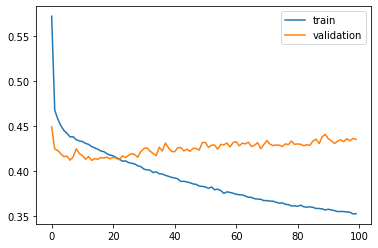

#################################
Number of units: 256
Batch size: 256
Dropout rate 1: 0.1892722289026565
Dropout rate 2: 0.7884498762400916
Fold: 0
Best val loss: 0.4117125610775418
#################################
Time to train MLP:  112.5783224105835
Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 2s - loss: 0.5727 - val_loss: 0.4396

Epoch 00001: val_loss improved from inf to 0.43964, saving model to MLP_val_weights.hdf5
Epoch 2/100
 - 1s - loss: 0.4683 - val_loss: 0.4240

Epoch 00002: val_loss improved from 0.43964 to 0.42404, saving model to MLP_val_weights.hdf5
Epoch 3/100
 - 1s - loss: 0.4569 - val_loss: 0.4190

Epoch 00003: val_loss improved from 0.42404 to 0.41901, saving model to MLP_val_weights.hdf5
Epoch 4/100
 - 1s - loss: 0.4509 - val_loss: 0.4234

Epoch 00004: val_loss did not improve from 0.41901
Epoch 5/100
 - 1s - loss: 0.4457 - val_loss: 0.4103

Epoch 00005: val_loss improved from 0.41901 to 0.41035, saving model to MLP_val_weights.hdf5
Epoch 6/100


 - 1s - loss: 0.3643 - val_loss: 0.4218

Epoch 00075: val_loss did not improve from 0.41035
Epoch 76/100
 - 1s - loss: 0.3639 - val_loss: 0.4254

Epoch 00076: val_loss did not improve from 0.41035
Epoch 77/100
 - 1s - loss: 0.3651 - val_loss: 0.4237

Epoch 00077: val_loss did not improve from 0.41035
Epoch 78/100
 - 1s - loss: 0.3635 - val_loss: 0.4276

Epoch 00078: val_loss did not improve from 0.41035
Epoch 79/100
 - 1s - loss: 0.3623 - val_loss: 0.4250

Epoch 00079: val_loss did not improve from 0.41035
Epoch 80/100
 - 1s - loss: 0.3628 - val_loss: 0.4255

Epoch 00080: val_loss did not improve from 0.41035
Epoch 81/100
 - 1s - loss: 0.3636 - val_loss: 0.4269

Epoch 00081: val_loss did not improve from 0.41035
Epoch 82/100
 - 1s - loss: 0.3618 - val_loss: 0.4269

Epoch 00082: val_loss did not improve from 0.41035
Epoch 83/100
 - 1s - loss: 0.3609 - val_loss: 0.4247

Epoch 00083: val_loss did not improve from 0.41035
Epoch 84/100
 - 1s - loss: 0.3607 - val_loss: 0.4235

Epoch 00084: v

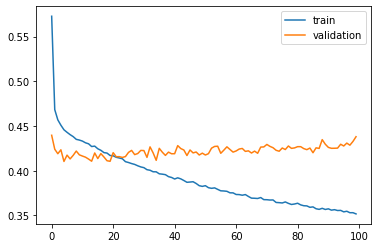

#################################
Number of units: 256
Batch size: 256
Dropout rate 1: 0.1892722289026565
Dropout rate 2: 0.7884498762400916
Fold: 1
Best val loss: 0.4103484870592753
#################################
Time to train MLP:  113.11991310119629
Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 2s - loss: 0.5722 - val_loss: 0.4409

Epoch 00001: val_loss improved from inf to 0.44092, saving model to MLP_val_weights.hdf5
Epoch 2/100
 - 1s - loss: 0.4692 - val_loss: 0.4242

Epoch 00002: val_loss improved from 0.44092 to 0.42415, saving model to MLP_val_weights.hdf5
Epoch 3/100
 - 1s - loss: 0.4558 - val_loss: 0.4159

Epoch 00003: val_loss improved from 0.42415 to 0.41589, saving model to MLP_val_weights.hdf5
Epoch 4/100
 - 1s - loss: 0.4488 - val_loss: 0.4176

Epoch 00004: val_loss did not improve from 0.41589
Epoch 5/100
 - 1s - loss: 0.4466 - val_loss: 0.4197

Epoch 00005: val_loss did not improve from 0.41589
Epoch 6/100
 - 1s - loss: 0.4419 - val_loss: 0.4123




Epoch 00074: val_loss did not improve from 0.41095
Epoch 75/100
 - 1s - loss: 0.3648 - val_loss: 0.4306

Epoch 00075: val_loss did not improve from 0.41095
Epoch 76/100
 - 1s - loss: 0.3637 - val_loss: 0.4328

Epoch 00076: val_loss did not improve from 0.41095
Epoch 77/100
 - 1s - loss: 0.3642 - val_loss: 0.4348

Epoch 00077: val_loss did not improve from 0.41095
Epoch 78/100
 - 1s - loss: 0.3638 - val_loss: 0.4336

Epoch 00078: val_loss did not improve from 0.41095
Epoch 79/100
 - 1s - loss: 0.3630 - val_loss: 0.4357

Epoch 00079: val_loss did not improve from 0.41095
Epoch 80/100
 - 1s - loss: 0.3615 - val_loss: 0.4353

Epoch 00080: val_loss did not improve from 0.41095
Epoch 81/100
 - 1s - loss: 0.3617 - val_loss: 0.4369

Epoch 00081: val_loss did not improve from 0.41095
Epoch 82/100
 - 1s - loss: 0.3604 - val_loss: 0.4315

Epoch 00082: val_loss did not improve from 0.41095
Epoch 83/100
 - 1s - loss: 0.3612 - val_loss: 0.4320

Epoch 00083: val_loss did not improve from 0.41095
Epo

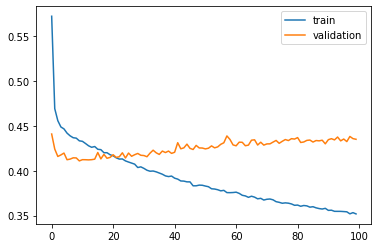

#################################
Number of units: 256
Batch size: 256
Dropout rate 1: 0.1892722289026565
Dropout rate 2: 0.7884498762400916
Fold: 2
Best val loss: 0.4109499293963114
#################################
Time to train MLP:  114.53820395469666
Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 3s - loss: 0.5751 - val_loss: 0.4388

Epoch 00001: val_loss improved from inf to 0.43882, saving model to MLP_val_weights.hdf5
Epoch 2/100
 - 1s - loss: 0.4719 - val_loss: 0.4253

Epoch 00002: val_loss improved from 0.43882 to 0.42532, saving model to MLP_val_weights.hdf5
Epoch 3/100
 - 1s - loss: 0.4572 - val_loss: 0.4161

Epoch 00003: val_loss improved from 0.42532 to 0.41615, saving model to MLP_val_weights.hdf5
Epoch 4/100
 - 1s - loss: 0.4501 - val_loss: 0.4117

Epoch 00004: val_loss improved from 0.41615 to 0.41167, saving model to MLP_val_weights.hdf5
Epoch 5/100
 - 1s - loss: 0.4462 - val_loss: 0.4137

Epoch 00005: val_loss did not improve from 0.41167
Epoch 6/100


Epoch 00073: val_loss did not improve from 0.40154
Epoch 74/100
 - 1s - loss: 0.3663 - val_loss: 0.4215

Epoch 00074: val_loss did not improve from 0.40154
Epoch 75/100
 - 1s - loss: 0.3652 - val_loss: 0.4214

Epoch 00075: val_loss did not improve from 0.40154
Epoch 76/100
 - 1s - loss: 0.3647 - val_loss: 0.4275

Epoch 00076: val_loss did not improve from 0.40154
Epoch 77/100
 - 1s - loss: 0.3640 - val_loss: 0.4245

Epoch 00077: val_loss did not improve from 0.40154
Epoch 78/100
 - 1s - loss: 0.3634 - val_loss: 0.4250

Epoch 00078: val_loss did not improve from 0.40154
Epoch 79/100
 - 1s - loss: 0.3633 - val_loss: 0.4288

Epoch 00079: val_loss did not improve from 0.40154
Epoch 80/100
 - 1s - loss: 0.3624 - val_loss: 0.4338

Epoch 00080: val_loss did not improve from 0.40154
Epoch 81/100
 - 1s - loss: 0.3619 - val_loss: 0.4266

Epoch 00081: val_loss did not improve from 0.40154
Epoch 82/100
 - 1s - loss: 0.3611 - val_loss: 0.4243

Epoch 00082: val_loss did not improve from 0.40154
Epo

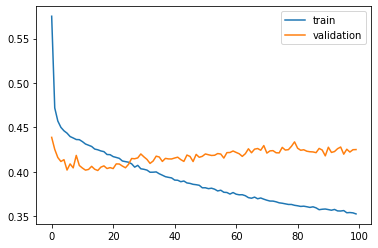

#################################
Number of units: 256
Batch size: 256
Dropout rate 1: 0.1892722289026565
Dropout rate 2: 0.7884498762400916
Fold: 3
Best val loss: 0.40154000367058645
#################################
Time to train MLP:  114.47722673416138
Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 3s - loss: 0.5746 - val_loss: 0.4265

Epoch 00001: val_loss improved from inf to 0.42655, saving model to MLP_val_weights.hdf5
Epoch 2/100
 - 1s - loss: 0.4716 - val_loss: 0.4159

Epoch 00002: val_loss improved from 0.42655 to 0.41587, saving model to MLP_val_weights.hdf5
Epoch 3/100
 - 1s - loss: 0.4565 - val_loss: 0.4110

Epoch 00003: val_loss improved from 0.41587 to 0.41095, saving model to MLP_val_weights.hdf5
Epoch 4/100
 - 1s - loss: 0.4505 - val_loss: 0.4094

Epoch 00004: val_loss improved from 0.41095 to 0.40935, saving model to MLP_val_weights.hdf5
Epoch 5/100
 - 1s - loss: 0.4465 - val_loss: 0.4123

Epoch 00005: val_loss did not improve from 0.40935
Epoch 6/10

 - 1s - loss: 0.3659 - val_loss: 0.4241

Epoch 00074: val_loss did not improve from 0.40714
Epoch 75/100
 - 1s - loss: 0.3645 - val_loss: 0.4257

Epoch 00075: val_loss did not improve from 0.40714
Epoch 76/100
 - 1s - loss: 0.3635 - val_loss: 0.4287

Epoch 00076: val_loss did not improve from 0.40714
Epoch 77/100
 - 1s - loss: 0.3633 - val_loss: 0.4279

Epoch 00077: val_loss did not improve from 0.40714
Epoch 78/100
 - 1s - loss: 0.3629 - val_loss: 0.4308

Epoch 00078: val_loss did not improve from 0.40714
Epoch 79/100
 - 1s - loss: 0.3619 - val_loss: 0.4292

Epoch 00079: val_loss did not improve from 0.40714
Epoch 80/100
 - 1s - loss: 0.3634 - val_loss: 0.4264

Epoch 00080: val_loss did not improve from 0.40714
Epoch 81/100
 - 1s - loss: 0.3621 - val_loss: 0.4284

Epoch 00081: val_loss did not improve from 0.40714
Epoch 82/100
 - 1s - loss: 0.3613 - val_loss: 0.4319

Epoch 00082: val_loss did not improve from 0.40714
Epoch 83/100
 - 1s - loss: 0.3595 - val_loss: 0.4372

Epoch 00083: v

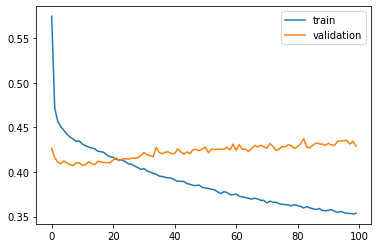

#################################
Number of units: 256
Batch size: 256
Dropout rate 1: 0.1892722289026565
Dropout rate 2: 0.7884498762400916
Fold: 4
Best val loss: 0.40713567855623034
#################################
[[256, 256, 0.17249149804310943, 0.7745143587906921, 0, 0.41004832951227826], [256, 256, 0.17249149804310943, 0.7745143587906921, 1, 0.4080996023548974], [256, 256, 0.17249149804310943, 0.7745143587906921, 2, 0.4125597271919251], [256, 256, 0.17249149804310943, 0.7745143587906921, 3, 0.40099650237295364], [256, 256, 0.17249149804310943, 0.7745143587906921, 4, 0.4064964518547058], [256, 256, 0.1892722289026565, 0.7884498762400916, 0, 0.4117125610775418], [256, 256, 0.1892722289026565, 0.7884498762400916, 1, 0.4103484870592753], [256, 256, 0.1892722289026565, 0.7884498762400916, 2, 0.4109499293963114], [256, 256, 0.1892722289026565, 0.7884498762400916, 3, 0.40154000367058645], [256, 256, 0.1892722289026565, 0.7884498762400916, 4, 0.40713567855623034]]
Time to train MLP:  11

 - 1s - loss: 0.3985 - val_loss: 0.4193

Epoch 00066: val_loss did not improve from 0.41145
Epoch 67/100
 - 1s - loss: 0.3966 - val_loss: 0.4269

Epoch 00067: val_loss did not improve from 0.41145
Epoch 68/100
 - 1s - loss: 0.3980 - val_loss: 0.4358

Epoch 00068: val_loss did not improve from 0.41145
Epoch 69/100
 - 1s - loss: 0.3970 - val_loss: 0.4239

Epoch 00069: val_loss did not improve from 0.41145
Epoch 70/100
 - 1s - loss: 0.3969 - val_loss: 0.4252

Epoch 00070: val_loss did not improve from 0.41145
Epoch 71/100
 - 1s - loss: 0.3956 - val_loss: 0.4239

Epoch 00071: val_loss did not improve from 0.41145
Epoch 72/100
 - 1s - loss: 0.3965 - val_loss: 0.4202

Epoch 00072: val_loss did not improve from 0.41145
Epoch 73/100
 - 1s - loss: 0.3943 - val_loss: 0.4248

Epoch 00073: val_loss did not improve from 0.41145
Epoch 74/100
 - 1s - loss: 0.3943 - val_loss: 0.4298

Epoch 00074: val_loss did not improve from 0.41145
Epoch 75/100
 - 1s - loss: 0.3936 - val_loss: 0.4294

Epoch 00075: v

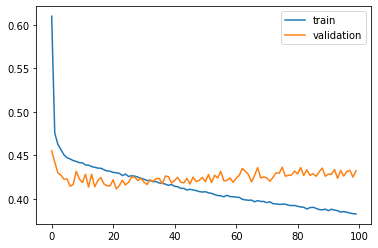

#################################
Number of units: 256
Batch size: 256
Dropout rate 1: 0.39238180748494084
Dropout rate 2: 0.7740081291875598
Fold: 0
Best val loss: 0.411446877890163
#################################
Time to train MLP:  117.7753677368164
Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 3s - loss: 0.6157 - val_loss: 0.4628

Epoch 00001: val_loss improved from inf to 0.46281, saving model to MLP_val_weights.hdf5
Epoch 2/100
 - 1s - loss: 0.4773 - val_loss: 0.4386

Epoch 00002: val_loss improved from 0.46281 to 0.43859, saving model to MLP_val_weights.hdf5
Epoch 3/100
 - 1s - loss: 0.4637 - val_loss: 0.4378

Epoch 00003: val_loss improved from 0.43859 to 0.43783, saving model to MLP_val_weights.hdf5
Epoch 4/100
 - 1s - loss: 0.4564 - val_loss: 0.4279

Epoch 00004: val_loss improved from 0.43783 to 0.42795, saving model to MLP_val_weights.hdf5
Epoch 5/100
 - 1s - loss: 0.4513 - val_loss: 0.4187

Epoch 00005: val_loss improved from 0.42795 to 0.41871, saving 

 - 1s - loss: 0.3945 - val_loss: 0.4140

Epoch 00073: val_loss did not improve from 0.41290
Epoch 74/100
 - 1s - loss: 0.3939 - val_loss: 0.4162

Epoch 00074: val_loss did not improve from 0.41290
Epoch 75/100
 - 1s - loss: 0.3932 - val_loss: 0.4216

Epoch 00075: val_loss did not improve from 0.41290
Epoch 76/100
 - 1s - loss: 0.3942 - val_loss: 0.4164

Epoch 00076: val_loss did not improve from 0.41290
Epoch 77/100
 - 1s - loss: 0.3925 - val_loss: 0.4151

Epoch 00077: val_loss did not improve from 0.41290
Epoch 78/100
 - 1s - loss: 0.3921 - val_loss: 0.4191

Epoch 00078: val_loss did not improve from 0.41290
Epoch 79/100
 - 1s - loss: 0.3919 - val_loss: 0.4169

Epoch 00079: val_loss did not improve from 0.41290
Epoch 80/100
 - 1s - loss: 0.3919 - val_loss: 0.4188

Epoch 00080: val_loss did not improve from 0.41290
Epoch 81/100
 - 1s - loss: 0.3917 - val_loss: 0.4268

Epoch 00081: val_loss did not improve from 0.41290
Epoch 82/100
 - 1s - loss: 0.3898 - val_loss: 0.4140

Epoch 00082: v

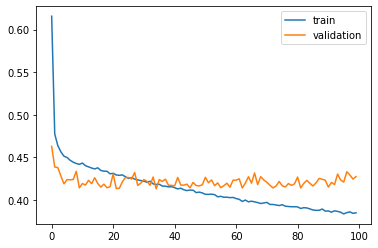

#################################
Number of units: 256
Batch size: 256
Dropout rate 1: 0.39238180748494084
Dropout rate 2: 0.7740081291875598
Fold: 1
Best val loss: 0.4129042013221317
#################################
Time to train MLP:  118.39948773384094
Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 3s - loss: 0.6099 - val_loss: 0.4509

Epoch 00001: val_loss improved from inf to 0.45087, saving model to MLP_val_weights.hdf5
Epoch 2/100
 - 1s - loss: 0.4763 - val_loss: 0.4299

Epoch 00002: val_loss improved from 0.45087 to 0.42994, saving model to MLP_val_weights.hdf5
Epoch 3/100
 - 1s - loss: 0.4632 - val_loss: 0.4243

Epoch 00003: val_loss improved from 0.42994 to 0.42431, saving model to MLP_val_weights.hdf5
Epoch 4/100
 - 1s - loss: 0.4549 - val_loss: 0.4221

Epoch 00004: val_loss improved from 0.42431 to 0.42209, saving model to MLP_val_weights.hdf5
Epoch 5/100
 - 1s - loss: 0.4510 - val_loss: 0.4226

Epoch 00005: val_loss did not improve from 0.42209
Epoch 6/10


Epoch 00073: val_loss did not improve from 0.41216
Epoch 74/100
 - 1s - loss: 0.3945 - val_loss: 0.4256

Epoch 00074: val_loss did not improve from 0.41216
Epoch 75/100
 - 1s - loss: 0.3934 - val_loss: 0.4206

Epoch 00075: val_loss did not improve from 0.41216
Epoch 76/100
 - 1s - loss: 0.3919 - val_loss: 0.4251

Epoch 00076: val_loss did not improve from 0.41216
Epoch 77/100
 - 1s - loss: 0.3939 - val_loss: 0.4278

Epoch 00077: val_loss did not improve from 0.41216
Epoch 78/100
 - 1s - loss: 0.3923 - val_loss: 0.4254

Epoch 00078: val_loss did not improve from 0.41216
Epoch 79/100
 - 1s - loss: 0.3931 - val_loss: 0.4270

Epoch 00079: val_loss did not improve from 0.41216
Epoch 80/100
 - 1s - loss: 0.3923 - val_loss: 0.4270

Epoch 00080: val_loss did not improve from 0.41216
Epoch 81/100
 - 1s - loss: 0.3903 - val_loss: 0.4239

Epoch 00081: val_loss did not improve from 0.41216
Epoch 82/100
 - 1s - loss: 0.3890 - val_loss: 0.4216

Epoch 00082: val_loss did not improve from 0.41216
Epo

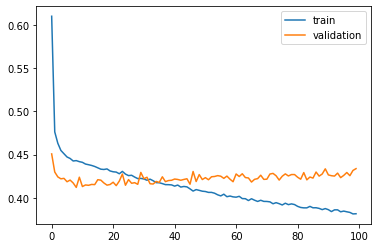

#################################
Number of units: 256
Batch size: 256
Dropout rate 1: 0.39238180748494084
Dropout rate 2: 0.7740081291875598
Fold: 2
Best val loss: 0.4121593419710795
#################################
Time to train MLP:  119.39795517921448
Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 3s - loss: 0.6119 - val_loss: 0.4665

Epoch 00001: val_loss improved from inf to 0.46648, saving model to MLP_val_weights.hdf5
Epoch 2/100
 - 1s - loss: 0.4779 - val_loss: 0.4414

Epoch 00002: val_loss improved from 0.46648 to 0.44140, saving model to MLP_val_weights.hdf5
Epoch 3/100
 - 1s - loss: 0.4629 - val_loss: 0.4234

Epoch 00003: val_loss improved from 0.44140 to 0.42339, saving model to MLP_val_weights.hdf5
Epoch 4/100
 - 1s - loss: 0.4569 - val_loss: 0.4212

Epoch 00004: val_loss improved from 0.42339 to 0.42118, saving model to MLP_val_weights.hdf5
Epoch 5/100
 - 1s - loss: 0.4540 - val_loss: 0.4287

Epoch 00005: val_loss did not improve from 0.42118
Epoch 6/10


Epoch 00073: val_loss did not improve from 0.40655
Epoch 74/100
 - 1s - loss: 0.3947 - val_loss: 0.4192

Epoch 00074: val_loss did not improve from 0.40655
Epoch 75/100
 - 1s - loss: 0.3928 - val_loss: 0.4150

Epoch 00075: val_loss did not improve from 0.40655
Epoch 76/100
 - 1s - loss: 0.3925 - val_loss: 0.4267

Epoch 00076: val_loss did not improve from 0.40655
Epoch 77/100
 - 1s - loss: 0.3934 - val_loss: 0.4178

Epoch 00077: val_loss did not improve from 0.40655
Epoch 78/100
 - 1s - loss: 0.3921 - val_loss: 0.4240

Epoch 00078: val_loss did not improve from 0.40655
Epoch 79/100
 - 1s - loss: 0.3906 - val_loss: 0.4273

Epoch 00079: val_loss did not improve from 0.40655
Epoch 80/100
 - 1s - loss: 0.3911 - val_loss: 0.4169

Epoch 00080: val_loss did not improve from 0.40655
Epoch 81/100
 - 1s - loss: 0.3922 - val_loss: 0.4268

Epoch 00081: val_loss did not improve from 0.40655
Epoch 82/100
 - 1s - loss: 0.3916 - val_loss: 0.4194

Epoch 00082: val_loss did not improve from 0.40655
Epo

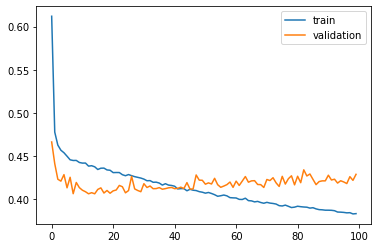

#################################
Number of units: 256
Batch size: 256
Dropout rate 1: 0.39238180748494084
Dropout rate 2: 0.7740081291875598
Fold: 3
Best val loss: 0.4065462808873918
#################################
Time to train MLP:  120.37293267250061
Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 4s - loss: 0.6146 - val_loss: 0.4538

Epoch 00001: val_loss improved from inf to 0.45383, saving model to MLP_val_weights.hdf5
Epoch 2/100
 - 1s - loss: 0.4772 - val_loss: 0.4247

Epoch 00002: val_loss improved from 0.45383 to 0.42466, saving model to MLP_val_weights.hdf5
Epoch 3/100
 - 1s - loss: 0.4644 - val_loss: 0.4181

Epoch 00003: val_loss improved from 0.42466 to 0.41808, saving model to MLP_val_weights.hdf5
Epoch 4/100
 - 1s - loss: 0.4573 - val_loss: 0.4160

Epoch 00004: val_loss improved from 0.41808 to 0.41599, saving model to MLP_val_weights.hdf5
Epoch 5/100
 - 1s - loss: 0.4515 - val_loss: 0.4133

Epoch 00005: val_loss improved from 0.41599 to 0.41327, savin


Epoch 00073: val_loss did not improve from 0.40584
Epoch 74/100
 - 1s - loss: 0.3928 - val_loss: 0.4215

Epoch 00074: val_loss did not improve from 0.40584
Epoch 75/100
 - 1s - loss: 0.3925 - val_loss: 0.4204

Epoch 00075: val_loss did not improve from 0.40584
Epoch 76/100
 - 1s - loss: 0.3939 - val_loss: 0.4197

Epoch 00076: val_loss did not improve from 0.40584
Epoch 77/100
 - 1s - loss: 0.3928 - val_loss: 0.4239

Epoch 00077: val_loss did not improve from 0.40584
Epoch 78/100
 - 1s - loss: 0.3930 - val_loss: 0.4274

Epoch 00078: val_loss did not improve from 0.40584
Epoch 79/100
 - 1s - loss: 0.3914 - val_loss: 0.4166

Epoch 00079: val_loss did not improve from 0.40584
Epoch 80/100
 - 1s - loss: 0.3923 - val_loss: 0.4231

Epoch 00080: val_loss did not improve from 0.40584
Epoch 81/100
 - 1s - loss: 0.3915 - val_loss: 0.4240

Epoch 00081: val_loss did not improve from 0.40584
Epoch 82/100
 - 1s - loss: 0.3919 - val_loss: 0.4218

Epoch 00082: val_loss did not improve from 0.40584
Epo

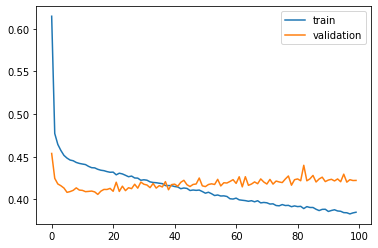

#################################
Number of units: 256
Batch size: 256
Dropout rate 1: 0.39238180748494084
Dropout rate 2: 0.7740081291875598
Fold: 4
Best val loss: 0.40583894046147667
#################################
[[256, 256, 0.17249149804310943, 0.7745143587906921, 0, 0.41004832951227826], [256, 256, 0.17249149804310943, 0.7745143587906921, 1, 0.4080996023548974], [256, 256, 0.17249149804310943, 0.7745143587906921, 2, 0.4125597271919251], [256, 256, 0.17249149804310943, 0.7745143587906921, 3, 0.40099650237295364], [256, 256, 0.17249149804310943, 0.7745143587906921, 4, 0.4064964518547058], [256, 256, 0.1892722289026565, 0.7884498762400916, 0, 0.4117125610775418], [256, 256, 0.1892722289026565, 0.7884498762400916, 1, 0.4103484870592753], [256, 256, 0.1892722289026565, 0.7884498762400916, 2, 0.4109499293963114], [256, 256, 0.1892722289026565, 0.7884498762400916, 3, 0.40154000367058645], [256, 256, 0.1892722289026565, 0.7884498762400916, 4, 0.40713567855623034], [256, 256, 0.39238180

 - 1s - loss: 0.3085 - val_loss: 0.4404

Epoch 00063: val_loss did not improve from 0.40787
Epoch 64/100
 - 1s - loss: 0.3063 - val_loss: 0.4405

Epoch 00064: val_loss did not improve from 0.40787
Epoch 65/100
 - 1s - loss: 0.3055 - val_loss: 0.4439

Epoch 00065: val_loss did not improve from 0.40787
Epoch 66/100
 - 1s - loss: 0.3073 - val_loss: 0.4372

Epoch 00066: val_loss did not improve from 0.40787
Epoch 67/100
 - 1s - loss: 0.3044 - val_loss: 0.4435

Epoch 00067: val_loss did not improve from 0.40787
Epoch 68/100
 - 1s - loss: 0.3035 - val_loss: 0.4400

Epoch 00068: val_loss did not improve from 0.40787
Epoch 69/100
 - 1s - loss: 0.3041 - val_loss: 0.4408

Epoch 00069: val_loss did not improve from 0.40787
Epoch 70/100
 - 1s - loss: 0.3016 - val_loss: 0.4396

Epoch 00070: val_loss did not improve from 0.40787
Epoch 71/100
 - 1s - loss: 0.3025 - val_loss: 0.4385

Epoch 00071: val_loss did not improve from 0.40787
Epoch 72/100
 - 1s - loss: 0.3009 - val_loss: 0.4420

Epoch 00072: v

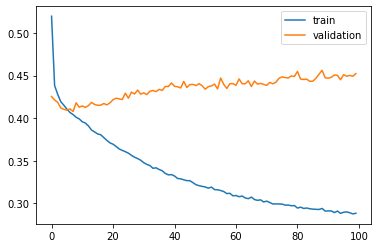

#################################
Number of units: 256
Batch size: 256
Dropout rate 1: 0.04311575651871297
Dropout rate 2: 0.5774557497867832
Fold: 0
Best val loss: 0.40786671386824713
#################################
Time to train MLP:  123.08719420433044
Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 5s - loss: 0.5086 - val_loss: 0.4349

Epoch 00001: val_loss improved from inf to 0.43493, saving model to MLP_val_weights.hdf5
Epoch 2/100
 - 1s - loss: 0.4387 - val_loss: 0.4160

Epoch 00002: val_loss improved from 0.43493 to 0.41603, saving model to MLP_val_weights.hdf5
Epoch 3/100
 - 1s - loss: 0.4269 - val_loss: 0.4206

Epoch 00003: val_loss did not improve from 0.41603
Epoch 4/100
 - 1s - loss: 0.4204 - val_loss: 0.4190

Epoch 00004: val_loss did not improve from 0.41603
Epoch 5/100
 - 1s - loss: 0.4153 - val_loss: 0.4146

Epoch 00005: val_loss improved from 0.41603 to 0.41455, saving model to MLP_val_weights.hdf5
Epoch 6/100
 - 1s - loss: 0.4106 - val_loss: 0.4066

 - 1s - loss: 0.3007 - val_loss: 0.4387

Epoch 00075: val_loss did not improve from 0.40662
Epoch 76/100
 - 1s - loss: 0.3014 - val_loss: 0.4441

Epoch 00076: val_loss did not improve from 0.40662
Epoch 77/100
 - 1s - loss: 0.3024 - val_loss: 0.4426

Epoch 00077: val_loss did not improve from 0.40662
Epoch 78/100
 - 1s - loss: 0.2999 - val_loss: 0.4389

Epoch 00078: val_loss did not improve from 0.40662
Epoch 79/100
 - 1s - loss: 0.2981 - val_loss: 0.4405

Epoch 00079: val_loss did not improve from 0.40662
Epoch 80/100
 - 1s - loss: 0.3005 - val_loss: 0.4477

Epoch 00080: val_loss did not improve from 0.40662
Epoch 81/100
 - 1s - loss: 0.2998 - val_loss: 0.4416

Epoch 00081: val_loss did not improve from 0.40662
Epoch 82/100
 - 1s - loss: 0.2991 - val_loss: 0.4399

Epoch 00082: val_loss did not improve from 0.40662
Epoch 83/100
 - 1s - loss: 0.2965 - val_loss: 0.4407

Epoch 00083: val_loss did not improve from 0.40662
Epoch 84/100
 - 1s - loss: 0.2953 - val_loss: 0.4397

Epoch 00084: v

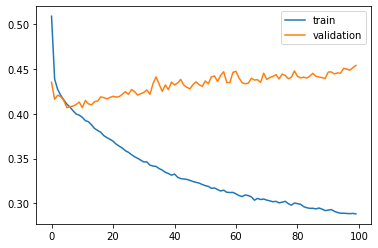

#################################
Number of units: 256
Batch size: 256
Dropout rate 1: 0.04311575651871297
Dropout rate 2: 0.5774557497867832
Fold: 1
Best val loss: 0.4066161558363173
#################################
Time to train MLP:  123.50971722602844
Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 4s - loss: 0.5092 - val_loss: 0.4251

Epoch 00001: val_loss improved from inf to 0.42508, saving model to MLP_val_weights.hdf5
Epoch 2/100
 - 1s - loss: 0.4387 - val_loss: 0.4158

Epoch 00002: val_loss improved from 0.42508 to 0.41577, saving model to MLP_val_weights.hdf5
Epoch 3/100
 - 1s - loss: 0.4257 - val_loss: 0.4146

Epoch 00003: val_loss improved from 0.41577 to 0.41460, saving model to MLP_val_weights.hdf5
Epoch 4/100
 - 1s - loss: 0.4193 - val_loss: 0.4111

Epoch 00004: val_loss improved from 0.41460 to 0.41107, saving model to MLP_val_weights.hdf5
Epoch 5/100
 - 1s - loss: 0.4151 - val_loss: 0.4112

Epoch 00005: val_loss did not improve from 0.41107
Epoch 6/10


Epoch 00074: val_loss did not improve from 0.40876
Epoch 75/100
 - 1s - loss: 0.3000 - val_loss: 0.4588

Epoch 00075: val_loss did not improve from 0.40876
Epoch 76/100
 - 1s - loss: 0.2979 - val_loss: 0.4494

Epoch 00076: val_loss did not improve from 0.40876
Epoch 77/100
 - 1s - loss: 0.2971 - val_loss: 0.4624

Epoch 00077: val_loss did not improve from 0.40876
Epoch 78/100
 - 1s - loss: 0.2974 - val_loss: 0.4806

Epoch 00078: val_loss did not improve from 0.40876
Epoch 79/100
 - 1s - loss: 0.2976 - val_loss: 0.4590

Epoch 00079: val_loss did not improve from 0.40876
Epoch 80/100
 - 1s - loss: 0.2963 - val_loss: 0.4501

Epoch 00080: val_loss did not improve from 0.40876
Epoch 81/100
 - 1s - loss: 0.2959 - val_loss: 0.4540

Epoch 00081: val_loss did not improve from 0.40876
Epoch 82/100
 - 1s - loss: 0.2944 - val_loss: 0.4475

Epoch 00082: val_loss did not improve from 0.40876
Epoch 83/100
 - 1s - loss: 0.2940 - val_loss: 0.4478

Epoch 00083: val_loss did not improve from 0.40876
Epo

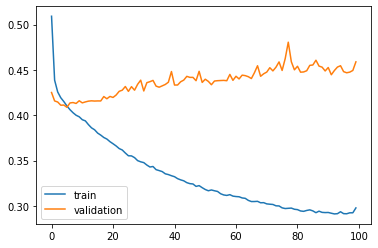

#################################
Number of units: 256
Batch size: 256
Dropout rate 1: 0.04311575651871297
Dropout rate 2: 0.5774557497867832
Fold: 2
Best val loss: 0.40876284109221567
#################################
Time to train MLP:  124.83982610702515
Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 5s - loss: 0.5107 - val_loss: 0.4273

Epoch 00001: val_loss improved from inf to 0.42734, saving model to MLP_val_weights.hdf5
Epoch 2/100
 - 1s - loss: 0.4393 - val_loss: 0.4055

Epoch 00002: val_loss improved from 0.42734 to 0.40554, saving model to MLP_val_weights.hdf5
Epoch 3/100
 - 1s - loss: 0.4253 - val_loss: 0.4037

Epoch 00003: val_loss improved from 0.40554 to 0.40369, saving model to MLP_val_weights.hdf5
Epoch 4/100
 - 1s - loss: 0.4197 - val_loss: 0.4110

Epoch 00004: val_loss did not improve from 0.40369
Epoch 5/100
 - 1s - loss: 0.4160 - val_loss: 0.3996

Epoch 00005: val_loss improved from 0.40369 to 0.39955, saving model to MLP_val_weights.hdf5
Epoch 6/1


Epoch 00074: val_loss did not improve from 0.39910
Epoch 75/100
 - 1s - loss: 0.3035 - val_loss: 0.4370

Epoch 00075: val_loss did not improve from 0.39910
Epoch 76/100
 - 1s - loss: 0.3027 - val_loss: 0.4408

Epoch 00076: val_loss did not improve from 0.39910
Epoch 77/100
 - 1s - loss: 0.3017 - val_loss: 0.4396

Epoch 00077: val_loss did not improve from 0.39910
Epoch 78/100
 - 1s - loss: 0.3016 - val_loss: 0.4424

Epoch 00078: val_loss did not improve from 0.39910
Epoch 79/100
 - 1s - loss: 0.3000 - val_loss: 0.4387

Epoch 00079: val_loss did not improve from 0.39910
Epoch 80/100
 - 1s - loss: 0.3002 - val_loss: 0.4405

Epoch 00080: val_loss did not improve from 0.39910
Epoch 81/100
 - 1s - loss: 0.2985 - val_loss: 0.4412

Epoch 00081: val_loss did not improve from 0.39910
Epoch 82/100
 - 1s - loss: 0.2957 - val_loss: 0.4393

Epoch 00082: val_loss did not improve from 0.39910
Epoch 83/100
 - 1s - loss: 0.2972 - val_loss: 0.4373

Epoch 00083: val_loss did not improve from 0.39910
Epo

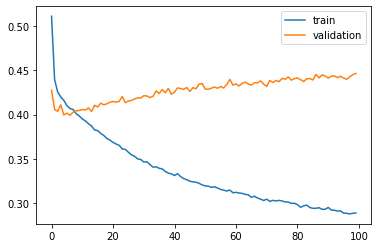

#################################
Number of units: 256
Batch size: 256
Dropout rate 1: 0.04311575651871297
Dropout rate 2: 0.5774557497867832
Fold: 3
Best val loss: 0.3991015560891893
#################################
Time to train MLP:  126.06342148780823
Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 5s - loss: 0.5076 - val_loss: 0.4249

Epoch 00001: val_loss improved from inf to 0.42495, saving model to MLP_val_weights.hdf5
Epoch 2/100
 - 1s - loss: 0.4374 - val_loss: 0.4118

Epoch 00002: val_loss improved from 0.42495 to 0.41180, saving model to MLP_val_weights.hdf5
Epoch 3/100
 - 1s - loss: 0.4267 - val_loss: 0.4088

Epoch 00003: val_loss improved from 0.41180 to 0.40879, saving model to MLP_val_weights.hdf5
Epoch 4/100
 - 1s - loss: 0.4200 - val_loss: 0.4084

Epoch 00004: val_loss improved from 0.40879 to 0.40838, saving model to MLP_val_weights.hdf5
Epoch 5/100
 - 1s - loss: 0.4140 - val_loss: 0.4078

Epoch 00005: val_loss improved from 0.40838 to 0.40783, savin


Epoch 00074: val_loss did not improve from 0.40783
Epoch 75/100
 - 1s - loss: 0.3024 - val_loss: 0.4478

Epoch 00075: val_loss did not improve from 0.40783
Epoch 76/100
 - 1s - loss: 0.3022 - val_loss: 0.4466

Epoch 00076: val_loss did not improve from 0.40783
Epoch 77/100
 - 1s - loss: 0.3014 - val_loss: 0.4470

Epoch 00077: val_loss did not improve from 0.40783
Epoch 78/100
 - 1s - loss: 0.3011 - val_loss: 0.4468

Epoch 00078: val_loss did not improve from 0.40783
Epoch 79/100
 - 1s - loss: 0.2998 - val_loss: 0.4451

Epoch 00079: val_loss did not improve from 0.40783
Epoch 80/100
 - 1s - loss: 0.2989 - val_loss: 0.4450

Epoch 00080: val_loss did not improve from 0.40783
Epoch 81/100
 - 1s - loss: 0.2989 - val_loss: 0.4509

Epoch 00081: val_loss did not improve from 0.40783
Epoch 82/100
 - 1s - loss: 0.2980 - val_loss: 0.4502

Epoch 00082: val_loss did not improve from 0.40783
Epoch 83/100
 - 1s - loss: 0.2983 - val_loss: 0.4514

Epoch 00083: val_loss did not improve from 0.40783
Epo

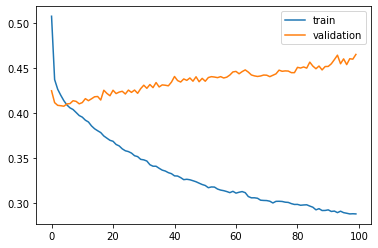

#################################
Number of units: 256
Batch size: 256
Dropout rate 1: 0.04311575651871297
Dropout rate 2: 0.5774557497867832
Fold: 4
Best val loss: 0.40783275429407756
#################################
[[256, 256, 0.17249149804310943, 0.7745143587906921, 0, 0.41004832951227826], [256, 256, 0.17249149804310943, 0.7745143587906921, 1, 0.4080996023548974], [256, 256, 0.17249149804310943, 0.7745143587906921, 2, 0.4125597271919251], [256, 256, 0.17249149804310943, 0.7745143587906921, 3, 0.40099650237295364], [256, 256, 0.17249149804310943, 0.7745143587906921, 4, 0.4064964518547058], [256, 256, 0.1892722289026565, 0.7884498762400916, 0, 0.4117125610775418], [256, 256, 0.1892722289026565, 0.7884498762400916, 1, 0.4103484870592753], [256, 256, 0.1892722289026565, 0.7884498762400916, 2, 0.4109499293963114], [256, 256, 0.1892722289026565, 0.7884498762400916, 3, 0.40154000367058645], [256, 256, 0.1892722289026565, 0.7884498762400916, 4, 0.40713567855623034], [256, 256, 0.39238180

 - 1s - loss: 0.3940 - val_loss: 0.4281

Epoch 00058: val_loss did not improve from 0.41219
Epoch 59/100
 - 1s - loss: 0.3960 - val_loss: 0.4248

Epoch 00059: val_loss did not improve from 0.41219
Epoch 60/100
 - 1s - loss: 0.3938 - val_loss: 0.4327

Epoch 00060: val_loss did not improve from 0.41219
Epoch 61/100
 - 1s - loss: 0.3934 - val_loss: 0.4241

Epoch 00061: val_loss did not improve from 0.41219
Epoch 62/100
 - 1s - loss: 0.3922 - val_loss: 0.4287

Epoch 00062: val_loss did not improve from 0.41219
Epoch 63/100
 - 1s - loss: 0.3924 - val_loss: 0.4308

Epoch 00063: val_loss did not improve from 0.41219
Epoch 64/100
 - 1s - loss: 0.3921 - val_loss: 0.4253

Epoch 00064: val_loss did not improve from 0.41219
Epoch 65/100
 - 1s - loss: 0.3917 - val_loss: 0.4332

Epoch 00065: val_loss did not improve from 0.41219
Epoch 66/100
 - 1s - loss: 0.3917 - val_loss: 0.4284

Epoch 00066: val_loss did not improve from 0.41219
Epoch 67/100
 - 1s - loss: 0.3902 - val_loss: 0.4285

Epoch 00067: v

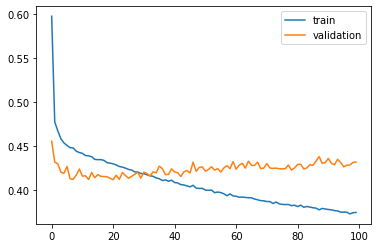

#################################
Number of units: 256
Batch size: 256
Dropout rate 1: 0.27303696890041906
Dropout rate 2: 0.8162807405267526
Fold: 0
Best val loss: 0.4121928439670139
#################################
Time to train MLP:  127.91624855995178
Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 5s - loss: 0.6038 - val_loss: 0.4350

Epoch 00001: val_loss improved from inf to 0.43504, saving model to MLP_val_weights.hdf5
Epoch 2/100
 - 1s - loss: 0.4801 - val_loss: 0.4309

Epoch 00002: val_loss improved from 0.43504 to 0.43094, saving model to MLP_val_weights.hdf5
Epoch 3/100
 - 1s - loss: 0.4678 - val_loss: 0.4230

Epoch 00003: val_loss improved from 0.43094 to 0.42301, saving model to MLP_val_weights.hdf5
Epoch 4/100
 - 1s - loss: 0.4609 - val_loss: 0.4226

Epoch 00004: val_loss improved from 0.42301 to 0.42258, saving model to MLP_val_weights.hdf5
Epoch 5/100
 - 1s - loss: 0.4550 - val_loss: 0.4178

Epoch 00005: val_loss improved from 0.42258 to 0.41782, savin

 - 1s - loss: 0.3867 - val_loss: 0.4220

Epoch 00073: val_loss did not improve from 0.40918
Epoch 74/100
 - 1s - loss: 0.3856 - val_loss: 0.4189

Epoch 00074: val_loss did not improve from 0.40918
Epoch 75/100
 - 1s - loss: 0.3858 - val_loss: 0.4196

Epoch 00075: val_loss did not improve from 0.40918
Epoch 76/100
 - 1s - loss: 0.3869 - val_loss: 0.4189

Epoch 00076: val_loss did not improve from 0.40918
Epoch 77/100
 - 1s - loss: 0.3844 - val_loss: 0.4211

Epoch 00077: val_loss did not improve from 0.40918
Epoch 78/100
 - 1s - loss: 0.3841 - val_loss: 0.4235

Epoch 00078: val_loss did not improve from 0.40918
Epoch 79/100
 - 1s - loss: 0.3825 - val_loss: 0.4237

Epoch 00079: val_loss did not improve from 0.40918
Epoch 80/100
 - 1s - loss: 0.3831 - val_loss: 0.4233

Epoch 00080: val_loss did not improve from 0.40918
Epoch 81/100
 - 1s - loss: 0.3832 - val_loss: 0.4251

Epoch 00081: val_loss did not improve from 0.40918
Epoch 82/100
 - 1s - loss: 0.3814 - val_loss: 0.4243

Epoch 00082: v

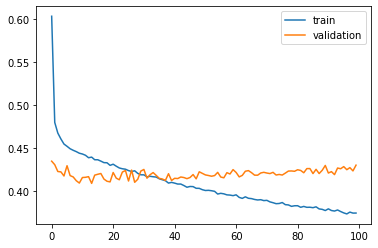

#################################
Number of units: 256
Batch size: 256
Dropout rate 1: 0.27303696890041906
Dropout rate 2: 0.8162807405267526
Fold: 1
Best val loss: 0.40918299118677776
#################################
Time to train MLP:  128.27187848091125
Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 5s - loss: 0.6026 - val_loss: 0.4433

Epoch 00001: val_loss improved from inf to 0.44334, saving model to MLP_val_weights.hdf5
Epoch 2/100
 - 1s - loss: 0.4791 - val_loss: 0.4333

Epoch 00002: val_loss improved from 0.44334 to 0.43327, saving model to MLP_val_weights.hdf5
Epoch 3/100
 - 1s - loss: 0.4661 - val_loss: 0.4208

Epoch 00003: val_loss improved from 0.43327 to 0.42080, saving model to MLP_val_weights.hdf5
Epoch 4/100
 - 1s - loss: 0.4579 - val_loss: 0.4220

Epoch 00004: val_loss did not improve from 0.42080
Epoch 5/100
 - 1s - loss: 0.4553 - val_loss: 0.4285

Epoch 00005: val_loss did not improve from 0.42080
Epoch 6/100
 - 1s - loss: 0.4499 - val_loss: 0.4191


Epoch 00073: val_loss did not improve from 0.41200
Epoch 74/100
 - 1s - loss: 0.3862 - val_loss: 0.4250

Epoch 00074: val_loss did not improve from 0.41200
Epoch 75/100
 - 1s - loss: 0.3850 - val_loss: 0.4284

Epoch 00075: val_loss did not improve from 0.41200
Epoch 76/100
 - 1s - loss: 0.3861 - val_loss: 0.4288

Epoch 00076: val_loss did not improve from 0.41200
Epoch 77/100
 - 1s - loss: 0.3836 - val_loss: 0.4332

Epoch 00077: val_loss did not improve from 0.41200
Epoch 78/100
 - 1s - loss: 0.3837 - val_loss: 0.4290

Epoch 00078: val_loss did not improve from 0.41200
Epoch 79/100
 - 1s - loss: 0.3840 - val_loss: 0.4310

Epoch 00079: val_loss did not improve from 0.41200
Epoch 80/100
 - 1s - loss: 0.3833 - val_loss: 0.4297

Epoch 00080: val_loss did not improve from 0.41200
Epoch 81/100
 - 1s - loss: 0.3841 - val_loss: 0.4295

Epoch 00081: val_loss did not improve from 0.41200
Epoch 82/100
 - 1s - loss: 0.3819 - val_loss: 0.4261

Epoch 00082: val_loss did not improve from 0.41200
Epo

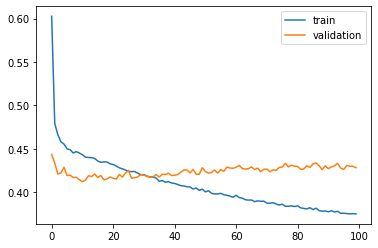

#################################
Number of units: 256
Batch size: 256
Dropout rate 1: 0.27303696890041906
Dropout rate 2: 0.8162807405267526
Fold: 2
Best val loss: 0.4119953238434262
#################################
Time to train MLP:  129.9670820236206
Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 5s - loss: 0.6011 - val_loss: 0.4432

Epoch 00001: val_loss improved from inf to 0.44323, saving model to MLP_val_weights.hdf5
Epoch 2/100
 - 1s - loss: 0.4834 - val_loss: 0.4377

Epoch 00002: val_loss improved from 0.44323 to 0.43769, saving model to MLP_val_weights.hdf5
Epoch 3/100
 - 1s - loss: 0.4665 - val_loss: 0.4220

Epoch 00003: val_loss improved from 0.43769 to 0.42201, saving model to MLP_val_weights.hdf5
Epoch 4/100
 - 1s - loss: 0.4597 - val_loss: 0.4236

Epoch 00004: val_loss did not improve from 0.42201
Epoch 5/100
 - 1s - loss: 0.4561 - val_loss: 0.4205

Epoch 00005: val_loss improved from 0.42201 to 0.42050, saving model to MLP_val_weights.hdf5
Epoch 6/100

 - 1s - loss: 0.3872 - val_loss: 0.4197

Epoch 00073: val_loss did not improve from 0.40366
Epoch 74/100
 - 1s - loss: 0.3873 - val_loss: 0.4237

Epoch 00074: val_loss did not improve from 0.40366
Epoch 75/100
 - 1s - loss: 0.3835 - val_loss: 0.4208

Epoch 00075: val_loss did not improve from 0.40366
Epoch 76/100
 - 1s - loss: 0.3849 - val_loss: 0.4211

Epoch 00076: val_loss did not improve from 0.40366
Epoch 77/100
 - 1s - loss: 0.3842 - val_loss: 0.4318

Epoch 00077: val_loss did not improve from 0.40366
Epoch 78/100
 - 1s - loss: 0.3846 - val_loss: 0.4248

Epoch 00078: val_loss did not improve from 0.40366
Epoch 79/100
 - 1s - loss: 0.3828 - val_loss: 0.4247

Epoch 00079: val_loss did not improve from 0.40366
Epoch 80/100
 - 1s - loss: 0.3827 - val_loss: 0.4269

Epoch 00080: val_loss did not improve from 0.40366
Epoch 81/100
 - 1s - loss: 0.3839 - val_loss: 0.4271

Epoch 00081: val_loss did not improve from 0.40366
Epoch 82/100
 - 1s - loss: 0.3828 - val_loss: 0.4213

Epoch 00082: v

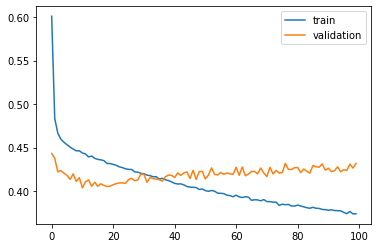

#################################
Number of units: 256
Batch size: 256
Dropout rate 1: 0.27303696890041906
Dropout rate 2: 0.8162807405267526
Fold: 3
Best val loss: 0.4036607729064094
#################################
Time to train MLP:  129.77927803993225
Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 6s - loss: 0.6040 - val_loss: 0.4405

Epoch 00001: val_loss improved from inf to 0.44049, saving model to MLP_val_weights.hdf5
Epoch 2/100
 - 1s - loss: 0.4795 - val_loss: 0.4213

Epoch 00002: val_loss improved from 0.44049 to 0.42129, saving model to MLP_val_weights.hdf5
Epoch 3/100
 - 1s - loss: 0.4657 - val_loss: 0.4141

Epoch 00003: val_loss improved from 0.42129 to 0.41413, saving model to MLP_val_weights.hdf5
Epoch 4/100
 - 1s - loss: 0.4601 - val_loss: 0.4107

Epoch 00004: val_loss improved from 0.41413 to 0.41068, saving model to MLP_val_weights.hdf5
Epoch 5/100
 - 1s - loss: 0.4552 - val_loss: 0.4121

Epoch 00005: val_loss did not improve from 0.41068
Epoch 6/10


Epoch 00074: val_loss did not improve from 0.40715
Epoch 75/100
 - 1s - loss: 0.3856 - val_loss: 0.4241

Epoch 00075: val_loss did not improve from 0.40715
Epoch 76/100
 - 1s - loss: 0.3847 - val_loss: 0.4253

Epoch 00076: val_loss did not improve from 0.40715
Epoch 77/100
 - 1s - loss: 0.3852 - val_loss: 0.4213

Epoch 00077: val_loss did not improve from 0.40715
Epoch 78/100
 - 1s - loss: 0.3848 - val_loss: 0.4238

Epoch 00078: val_loss did not improve from 0.40715
Epoch 79/100
 - 1s - loss: 0.3829 - val_loss: 0.4249

Epoch 00079: val_loss did not improve from 0.40715
Epoch 80/100
 - 1s - loss: 0.3842 - val_loss: 0.4240

Epoch 00080: val_loss did not improve from 0.40715
Epoch 81/100
 - 1s - loss: 0.3852 - val_loss: 0.4249

Epoch 00081: val_loss did not improve from 0.40715
Epoch 82/100
 - 1s - loss: 0.3841 - val_loss: 0.4233

Epoch 00082: val_loss did not improve from 0.40715
Epoch 83/100
 - 1s - loss: 0.3813 - val_loss: 0.4284

Epoch 00083: val_loss did not improve from 0.40715
Epo

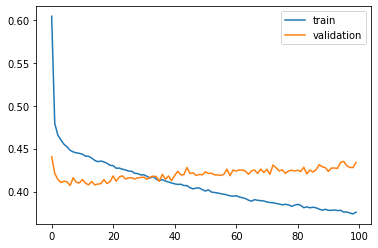

#################################
Number of units: 256
Batch size: 256
Dropout rate 1: 0.27303696890041906
Dropout rate 2: 0.8162807405267526
Fold: 4
Best val loss: 0.40715030993355644
#################################
[[256, 256, 0.17249149804310943, 0.7745143587906921, 0, 0.41004832951227826], [256, 256, 0.17249149804310943, 0.7745143587906921, 1, 0.4080996023548974], [256, 256, 0.17249149804310943, 0.7745143587906921, 2, 0.4125597271919251], [256, 256, 0.17249149804310943, 0.7745143587906921, 3, 0.40099650237295364], [256, 256, 0.17249149804310943, 0.7745143587906921, 4, 0.4064964518547058], [256, 256, 0.1892722289026565, 0.7884498762400916, 0, 0.4117125610775418], [256, 256, 0.1892722289026565, 0.7884498762400916, 1, 0.4103484870592753], [256, 256, 0.1892722289026565, 0.7884498762400916, 2, 0.4109499293963114], [256, 256, 0.1892722289026565, 0.7884498762400916, 3, 0.40154000367058645], [256, 256, 0.1892722289026565, 0.7884498762400916, 4, 0.40713567855623034], [256, 256, 0.39238180


Epoch 00056: val_loss did not improve from 0.40798
Epoch 57/100
 - 1s - loss: 0.3207 - val_loss: 0.4361

Epoch 00057: val_loss did not improve from 0.40798
Epoch 58/100
 - 1s - loss: 0.3182 - val_loss: 0.4339

Epoch 00058: val_loss did not improve from 0.40798
Epoch 59/100
 - 1s - loss: 0.3184 - val_loss: 0.4381

Epoch 00059: val_loss did not improve from 0.40798
Epoch 60/100
 - 1s - loss: 0.3165 - val_loss: 0.4334

Epoch 00060: val_loss did not improve from 0.40798
Epoch 61/100
 - 1s - loss: 0.3162 - val_loss: 0.4351

Epoch 00061: val_loss did not improve from 0.40798
Epoch 62/100
 - 1s - loss: 0.3154 - val_loss: 0.4410

Epoch 00062: val_loss did not improve from 0.40798
Epoch 63/100
 - 1s - loss: 0.3153 - val_loss: 0.4361

Epoch 00063: val_loss did not improve from 0.40798
Epoch 64/100
 - 1s - loss: 0.3133 - val_loss: 0.4352

Epoch 00064: val_loss did not improve from 0.40798
Epoch 65/100
 - 1s - loss: 0.3138 - val_loss: 0.4337

Epoch 00065: val_loss did not improve from 0.40798
Epo

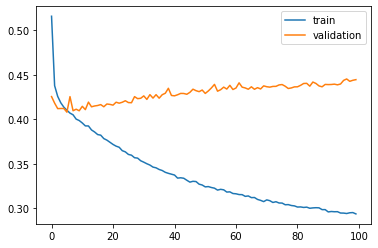

#################################
Number of units: 256
Batch size: 256
Dropout rate 1: 0.08111301014441535
Dropout rate 2: 0.5545717087158022
Fold: 0
Best val loss: 0.40798354636298284
#################################
Time to train MLP:  132.09314107894897
Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 6s - loss: 0.5105 - val_loss: 0.4331

Epoch 00001: val_loss improved from inf to 0.43312, saving model to MLP_val_weights.hdf5
Epoch 2/100
 - 1s - loss: 0.4387 - val_loss: 0.4236

Epoch 00002: val_loss improved from 0.43312 to 0.42362, saving model to MLP_val_weights.hdf5
Epoch 3/100
 - 1s - loss: 0.4268 - val_loss: 0.4199

Epoch 00003: val_loss improved from 0.42362 to 0.41988, saving model to MLP_val_weights.hdf5
Epoch 4/100
 - 1s - loss: 0.4201 - val_loss: 0.4133

Epoch 00004: val_loss improved from 0.41988 to 0.41325, saving model to MLP_val_weights.hdf5
Epoch 5/100
 - 1s - loss: 0.4162 - val_loss: 0.4060

Epoch 00005: val_loss improved from 0.41325 to 0.40595, savi


Epoch 00074: val_loss did not improve from 0.40595
Epoch 75/100
 - 1s - loss: 0.3059 - val_loss: 0.4428

Epoch 00075: val_loss did not improve from 0.40595
Epoch 76/100
 - 1s - loss: 0.3040 - val_loss: 0.4472

Epoch 00076: val_loss did not improve from 0.40595
Epoch 77/100
 - 1s - loss: 0.3043 - val_loss: 0.4376

Epoch 00077: val_loss did not improve from 0.40595
Epoch 78/100
 - 1s - loss: 0.3044 - val_loss: 0.4355

Epoch 00078: val_loss did not improve from 0.40595
Epoch 79/100
 - 1s - loss: 0.3038 - val_loss: 0.4362

Epoch 00079: val_loss did not improve from 0.40595
Epoch 80/100
 - 1s - loss: 0.3041 - val_loss: 0.4372

Epoch 00080: val_loss did not improve from 0.40595
Epoch 81/100
 - 1s - loss: 0.3028 - val_loss: 0.4449

Epoch 00081: val_loss did not improve from 0.40595
Epoch 82/100
 - 1s - loss: 0.3022 - val_loss: 0.4409

Epoch 00082: val_loss did not improve from 0.40595
Epoch 83/100
 - 1s - loss: 0.3006 - val_loss: 0.4461

Epoch 00083: val_loss did not improve from 0.40595
Epo

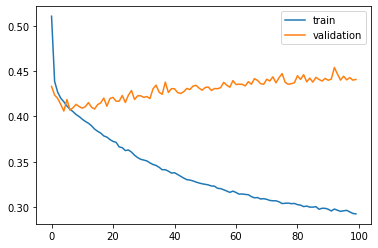

#################################
Number of units: 256
Batch size: 256
Dropout rate 1: 0.08111301014441535
Dropout rate 2: 0.5545717087158022
Fold: 1
Best val loss: 0.4059524764749739
#################################
Time to train MLP:  132.59978652000427
Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 14s - loss: 0.5116 - val_loss: 0.4283

Epoch 00001: val_loss improved from inf to 0.42832, saving model to MLP_val_weights.hdf5
Epoch 2/100
 - 1s - loss: 0.4381 - val_loss: 0.4177

Epoch 00002: val_loss improved from 0.42832 to 0.41772, saving model to MLP_val_weights.hdf5
Epoch 3/100
 - 1s - loss: 0.4255 - val_loss: 0.4152

Epoch 00003: val_loss improved from 0.41772 to 0.41523, saving model to MLP_val_weights.hdf5
Epoch 4/100
 - 1s - loss: 0.4186 - val_loss: 0.4112

Epoch 00004: val_loss improved from 0.41523 to 0.41116, saving model to MLP_val_weights.hdf5
Epoch 5/100
 - 1s - loss: 0.4148 - val_loss: 0.4139

Epoch 00005: val_loss did not improve from 0.41116
Epoch 6/1


Epoch 00074: val_loss did not improve from 0.41106
Epoch 75/100
 - 1s - loss: 0.3073 - val_loss: 0.4413

Epoch 00075: val_loss did not improve from 0.41106
Epoch 76/100
 - 1s - loss: 0.3067 - val_loss: 0.4455

Epoch 00076: val_loss did not improve from 0.41106
Epoch 77/100
 - 1s - loss: 0.3056 - val_loss: 0.4400

Epoch 00077: val_loss did not improve from 0.41106
Epoch 78/100
 - 1s - loss: 0.3050 - val_loss: 0.4451

Epoch 00078: val_loss did not improve from 0.41106
Epoch 79/100
 - 1s - loss: 0.3047 - val_loss: 0.4406

Epoch 00079: val_loss did not improve from 0.41106
Epoch 80/100
 - 1s - loss: 0.3039 - val_loss: 0.4383

Epoch 00080: val_loss did not improve from 0.41106
Epoch 81/100
 - 1s - loss: 0.3030 - val_loss: 0.4438

Epoch 00081: val_loss did not improve from 0.41106
Epoch 82/100
 - 1s - loss: 0.3028 - val_loss: 0.4380

Epoch 00082: val_loss did not improve from 0.41106
Epoch 83/100
 - 1s - loss: 0.3026 - val_loss: 0.4417

Epoch 00083: val_loss did not improve from 0.41106
Epo

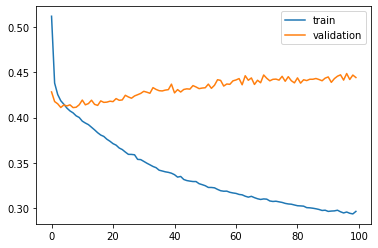

#################################
Number of units: 256
Batch size: 256
Dropout rate 1: 0.08111301014441535
Dropout rate 2: 0.5545717087158022
Fold: 2
Best val loss: 0.41105759233898587
#################################
Time to train MLP:  143.19427514076233
Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 6s - loss: 0.5101 - val_loss: 0.4186

Epoch 00001: val_loss improved from inf to 0.41860, saving model to MLP_val_weights.hdf5
Epoch 2/100
 - 1s - loss: 0.4378 - val_loss: 0.4050

Epoch 00002: val_loss improved from 0.41860 to 0.40496, saving model to MLP_val_weights.hdf5
Epoch 3/100
 - 1s - loss: 0.4246 - val_loss: 0.4031

Epoch 00003: val_loss improved from 0.40496 to 0.40305, saving model to MLP_val_weights.hdf5
Epoch 4/100
 - 1s - loss: 0.4204 - val_loss: 0.4060

Epoch 00004: val_loss did not improve from 0.40305
Epoch 5/100
 - 1s - loss: 0.4158 - val_loss: 0.3991

Epoch 00005: val_loss improved from 0.40305 to 0.39912, saving model to MLP_val_weights.hdf5
Epoch 6/1

 - 1s - loss: 0.3065 - val_loss: 0.4254

Epoch 00075: val_loss did not improve from 0.39912
Epoch 76/100
 - 1s - loss: 0.3059 - val_loss: 0.4284

Epoch 00076: val_loss did not improve from 0.39912
Epoch 77/100
 - 1s - loss: 0.3046 - val_loss: 0.4262

Epoch 00077: val_loss did not improve from 0.39912
Epoch 78/100
 - 1s - loss: 0.3055 - val_loss: 0.4253

Epoch 00078: val_loss did not improve from 0.39912
Epoch 79/100
 - 1s - loss: 0.3032 - val_loss: 0.4255

Epoch 00079: val_loss did not improve from 0.39912
Epoch 80/100
 - 1s - loss: 0.3036 - val_loss: 0.4254

Epoch 00080: val_loss did not improve from 0.39912
Epoch 81/100
 - 1s - loss: 0.3033 - val_loss: 0.4256

Epoch 00081: val_loss did not improve from 0.39912
Epoch 82/100
 - 1s - loss: 0.3031 - val_loss: 0.4294

Epoch 00082: val_loss did not improve from 0.39912
Epoch 83/100
 - 1s - loss: 0.3024 - val_loss: 0.4265

Epoch 00083: val_loss did not improve from 0.39912
Epoch 84/100
 - 1s - loss: 0.3014 - val_loss: 0.4267

Epoch 00084: v

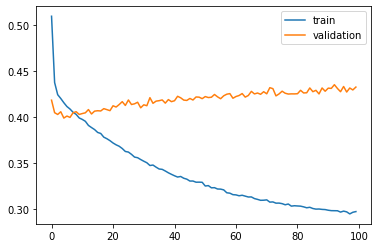

#################################
Number of units: 256
Batch size: 256
Dropout rate 1: 0.08111301014441535
Dropout rate 2: 0.5545717087158022
Fold: 3
Best val loss: 0.39911841877301535
#################################
Time to train MLP:  135.74300622940063
Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 6s - loss: 0.5093 - val_loss: 0.4225

Epoch 00001: val_loss improved from inf to 0.42250, saving model to MLP_val_weights.hdf5
Epoch 2/100
 - 1s - loss: 0.4376 - val_loss: 0.4106

Epoch 00002: val_loss improved from 0.42250 to 0.41060, saving model to MLP_val_weights.hdf5
Epoch 3/100
 - 1s - loss: 0.4268 - val_loss: 0.4087

Epoch 00003: val_loss improved from 0.41060 to 0.40875, saving model to MLP_val_weights.hdf5
Epoch 4/100
 - 1s - loss: 0.4192 - val_loss: 0.4093

Epoch 00004: val_loss did not improve from 0.40875
Epoch 5/100
 - 1s - loss: 0.4150 - val_loss: 0.4095

Epoch 00005: val_loss did not improve from 0.40875
Epoch 6/100
 - 1s - loss: 0.4115 - val_loss: 0.4087


Epoch 00074: val_loss did not improve from 0.40724
Epoch 75/100
 - 1s - loss: 0.3061 - val_loss: 0.4357

Epoch 00075: val_loss did not improve from 0.40724
Epoch 76/100
 - 1s - loss: 0.3067 - val_loss: 0.4446

Epoch 00076: val_loss did not improve from 0.40724
Epoch 77/100
 - 1s - loss: 0.3039 - val_loss: 0.4400

Epoch 00077: val_loss did not improve from 0.40724
Epoch 78/100
 - 1s - loss: 0.3058 - val_loss: 0.4374

Epoch 00078: val_loss did not improve from 0.40724
Epoch 79/100
 - 1s - loss: 0.3047 - val_loss: 0.4378

Epoch 00079: val_loss did not improve from 0.40724
Epoch 80/100
 - 1s - loss: 0.3011 - val_loss: 0.4360

Epoch 00080: val_loss did not improve from 0.40724
Epoch 81/100
 - 1s - loss: 0.3019 - val_loss: 0.4378

Epoch 00081: val_loss did not improve from 0.40724
Epoch 82/100
 - 1s - loss: 0.3013 - val_loss: 0.4400

Epoch 00082: val_loss did not improve from 0.40724
Epoch 83/100
 - 1s - loss: 0.3010 - val_loss: 0.4377

Epoch 00083: val_loss did not improve from 0.40724
Epo

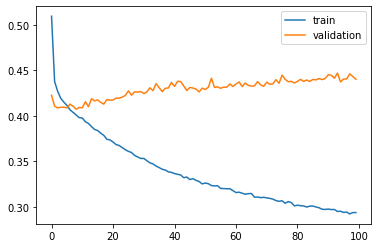

#################################
Number of units: 256
Batch size: 256
Dropout rate 1: 0.08111301014441535
Dropout rate 2: 0.5545717087158022
Fold: 4
Best val loss: 0.40723730134963987
#################################
[[256, 256, 0.17249149804310943, 0.7745143587906921, 0, 0.41004832951227826], [256, 256, 0.17249149804310943, 0.7745143587906921, 1, 0.4080996023548974], [256, 256, 0.17249149804310943, 0.7745143587906921, 2, 0.4125597271919251], [256, 256, 0.17249149804310943, 0.7745143587906921, 3, 0.40099650237295364], [256, 256, 0.17249149804310943, 0.7745143587906921, 4, 0.4064964518547058], [256, 256, 0.1892722289026565, 0.7884498762400916, 0, 0.4117125610775418], [256, 256, 0.1892722289026565, 0.7884498762400916, 1, 0.4103484870592753], [256, 256, 0.1892722289026565, 0.7884498762400916, 2, 0.4109499293963114], [256, 256, 0.1892722289026565, 0.7884498762400916, 3, 0.40154000367058645], [256, 256, 0.1892722289026565, 0.7884498762400916, 4, 0.40713567855623034], [256, 256, 0.39238180

In [16]:
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(1)


num_per_fold = x_train.shape[0]//10
print(num_per_fold)

start_time = time.time()

n_units = 256
b_size = 256

exp_record = []

for i in range(len(dropout_rate_1_list)):
    dropout_rate_1 = dropout_rate_1_list[i]
    dropout_rate_2 = dropout_rate_2_list[i]

    for f in range(5):#10
        #start = f*num_per_fold
        end = (f+1)*num_per_fold
        train1_x = x_train[:end, ]
        train2_x = x_train[end:, ]
        train_x_mlp = np.append(train2_x, train1_x, axis=0) #new obj
        train1_y = y_train[:end, ]
        train2_y = y_train[end:, ]
        train_y_mlp = np.append(train2_y, train1_y, axis=0)

        start_time_inner = time.time()
        with tf.Session(config = tf.ConfigProto(log_device_placement = True)):
            seed(1)
            set_random_seed(1)
            model = setup_model(n_units, 
                                 dropout_rate_1, 
                                 dropout_rate_2)
            v_loss = fit_model(model, train_x_mlp, 
                               train_y_mlp, b_size)
            print("#################################")
            print("Number of units:", n_units)
            print("Batch size:", b_size)
            print("Dropout rate 1:", dropout_rate_1)
            print("Dropout rate 2:", dropout_rate_2)
            print("Fold:", f)
            print("Best val loss:", v_loss)
            exp_record.append([n_units, b_size, 
                               dropout_rate_1, 
                               dropout_rate_2, 
                               f, v_loss])
            print("#################################")
            if(f==4):
                print(exp_record)
        print("Time to train MLP: ", time.time() - start_time_inner)
print("Entire process took: ", time.time() - start_time)

print("Experiment record:")
print(exp_record)

In [17]:
exp_record = [[256, 256, 0.18752856443664256, 0.6450348628460724, 0, 0.40912841582298276], [256, 256, 0.18752856443664256, 0.6450348628460724, 1, 0.40699472218089633], [256, 256, 0.18752856443664256, 0.6450348628460724, 2, 0.41076548189587064], [256, 256, 0.18752856443664256, 0.6450348628460724, 3, 0.40138634300231935], [256, 256, 0.18752856443664256, 0.6450348628460724, 4, 0.4053572289148967], [256, 256, 0.3201523099613221, 0.5225040861638903, 0, 0.4081863819493188], [256, 256, 0.3201523099613221, 0.5225040861638903, 1, 0.4071585290167067], [256, 256, 0.3201523099613221, 0.5225040861638903, 2, 0.4095375011761983], [256, 256, 0.3201523099613221, 0.5225040861638903, 3, 0.40084875528017677], [256, 256, 0.3201523099613221, 0.5225040861638903, 4, 0.40540508455700347], [256, 256, 0.4750082897025835, 0.6660938786649698, 0, 0.4143706063694424], [256, 256, 0.4750082897025835, 0.6660938786649698, 1, 0.41771020489268834], [256, 256, 0.4750082897025835, 0.6660938786649698, 2, 0.4154919159942203], [256, 256, 0.4750082897025835, 0.6660938786649698, 3, 0.40483485900031196], [256, 256, 0.4750082897025835, 0.6660938786649698, 4, 0.40973626867930096], [256, 256, 0.03783860235103076, 0.868266608120274, 0, 0.4142524787320031], [256, 256, 0.03783860235103076, 0.868266608120274, 1, 0.406865710761812], [256, 256, 0.03783860235103076, 0.868266608120274, 2, 0.41426599274741277], [256, 256, 0.03783860235103076, 0.868266608120274, 3, 0.4058568104373084], [256, 256, 0.03783860235103076, 0.868266608120274, 4, 0.40918046850628326], [256, 256, 0.38846482935906024, 0.9196057426053866, 0, 0.4233880034287771], [256, 256, 0.38846482935906024, 0.9196057426053866, 1, 0.41771368130048114], [256, 256, 0.38846482935906024, 0.9196057426053866, 2, 0.420548604355918], [256, 256, 0.38846482935906024, 0.9196057426053866, 3, 0.41659277809990775], [256, 256, 0.38846482935906024, 0.9196057426053866, 4, 0.41703971089257136], [256, 256, 0.41637288128092964, 0.8546808073064938, 0, 0.41677316726578606], [256, 256, 0.41637288128092964, 0.8546808073064938, 1, 0.41250183998213874], [256, 256, 0.41637288128092964, 0.8546808073064938, 2, 0.4149830216831631], [256, 256, 0.41637288128092964, 0.8546808073064938, 3, 0.4068524711926778], [256, 256, 0.41637288128092964, 0.8546808073064938, 4, 0.41159589603212143], [256, 256, 0.027402870141204128, 0.5942005583054051, 0, 0.41044401205910575], [256, 256, 0.027402870141204128, 0.5942005583054051, 1, 0.41065487247043186], [256, 256, 0.027402870141204128, 0.5942005583054051, 2, 0.41111131813791063], [256, 256, 0.027402870141204128, 0.5942005583054051, 3, 0.3993677942223019], [256, 256, 0.027402870141204128, 0.5942005583054051, 4, 0.4065965084499783], [256, 256, 0.4088386910876341, 0.9928342799563638, 0, 0.6735534612602658], [256, 256, 0.4088386910876341, 0.9928342799563638, 1, 0.6277657361560398], [256, 256, 0.4088386910876341, 0.9928342799563638, 2, 0.6175912636121114], [256, 256, 0.4088386910876341, 0.9928342799563638, 3, 0.6382062026659647], [256, 256, 0.4088386910876341, 0.9928342799563638, 4, 0.6232270593643189], [256, 256, 0.44267572903638336, 0.6940016540227223, 0, 0.4169774356948005], [256, 256, 0.44267572903638336, 0.6940016540227223, 1, 0.4134041331079271], [256, 256, 0.44267572903638336, 0.6940016540227223, 2, 0.41390107149548], [256, 256, 0.44267572903638336, 0.6940016540227223, 3, 0.4028040182855394], [256, 256, 0.44267572903638336, 0.6940016540227223, 4, 0.4070650036599901], [256, 256, 0.3611732554036228, 0.7515772409619305, 0, 0.41163387319776745], [256, 256, 0.3611732554036228, 0.7515772409619305, 1, 0.40657025872336494], [256, 256, 0.3611732554036228, 0.7515772409619305, 2, 0.4114999614291721], [256, 256, 0.3611732554036228, 0.7515772409619305, 3, 0.4043301054901547], [256, 256, 0.3611732554036228, 0.7515772409619305, 4, 0.40623159567515055], [256, 256, 0.0012780158616721993, 0.881765162651011, 0, 0.4136824802292718], [256, 256, 0.0012780158616721993, 0.881765162651011, 1, 0.4115426218774584], [256, 256, 0.0012780158616721993, 0.881765162651011, 2, 0.4116508805486891], [256, 256, 0.0012780158616721993, 0.881765162651011, 3, 0.4061632017294566], [256, 256, 0.0012780158616721993, 0.881765162651011, 4, 0.4097021827697754], [256, 256, 0.4905996388603758, 0.8418662247501874, 0, 0.42071755981445313], [256, 256, 0.4905996388603758, 0.8418662247501874, 1, 0.41158762929174636], [256, 256, 0.4905996388603758, 0.8418662247501874, 2, 0.41696411728858945], [256, 256, 0.4905996388603758, 0.8418662247501874, 3, 0.40660022989908856], [256, 256, 0.4905996388603758, 0.8418662247501874, 4, 0.41438625817828706], [256, 256, 0.17170992538358082, 0.8609786907012036, 0, 0.4130083338684506], [256, 256, 0.17170992538358082, 0.8609786907012036, 1, 0.40867658633655973], [256, 256, 0.17170992538358082, 0.8609786907012036, 2, 0.41211318816079034], [256, 256, 0.17170992538358082, 0.8609786907012036, 3, 0.4039812039004432], [256, 256, 0.17170992538358082, 0.8609786907012036, 4, 0.40923325390285914], [256, 256, 0.047379944088102144, 0.6070760453819448, 0, 0.40916463340653314], [256, 256, 0.047379944088102144, 0.6070760453819448, 1, 0.4076281818813748], [256, 256, 0.047379944088102144, 0.6070760453819448, 2, 0.41153265998098587], [256, 256, 0.047379944088102144, 0.6070760453819448, 3, 0.4009933106634352], [256, 256, 0.047379944088102144, 0.6070760453819448, 4, 0.4070513277053833], [256, 256, 0.19732129434741763, 0.8815462894869308, 0, 0.41481980668173896], [256, 256, 0.19732129434741763, 0.8815462894869308, 1, 0.41045315278900996], [256, 256, 0.19732129434741763, 0.8815462894869308, 2, 0.4117762852774726], [256, 256, 0.19732129434741763, 0.8815462894869308, 3, 0.40289610301123724], [256, 256, 0.19732129434741763, 0.8815462894869308, 4, 0.4102609283129374], [256, 256, 0.002472462405860354, 0.5376080776907113, 0, 0.41216151444117227], [256, 256, 0.002472462405860354, 0.5376080776907113, 1, 0.4107906519042121], [256, 256, 0.002472462405860354, 0.5376080776907113, 2, 0.41142323003874887], [256, 256, 0.002472462405860354, 0.5376080776907113, 3, 0.3999700931708018], [256, 256, 0.002472462405860354, 0.5376080776907113, 4, 0.40701174661848283], [256, 256, 0.36835341513363445, 0.8054453508528189, 0, 0.4125755413638221], [256, 256, 0.36835341513363445, 0.8054453508528189, 1, 0.40808548776308695], [256, 256, 0.36835341513363445, 0.8054453508528189, 2, 0.41270503128899466], [256, 256, 0.36835341513363445, 0.8054453508528189, 3, 0.40602659900983173], [256, 256, 0.36835341513363445, 0.8054453508528189, 4, 0.40818902836905585], [256, 256, 0.47790343474278035, 0.7128152123280982, 0, 0.41847595402929516], [256, 256, 0.47790343474278035, 0.7128152123280982, 1, 0.4156321260399289], [256, 256, 0.47790343474278035, 0.7128152123280982, 2, 0.4159873982535468], [256, 256, 0.47790343474278035, 0.7128152123280982, 3, 0.40650846905178495], [256, 256, 0.47790343474278035, 0.7128152123280982, 4, 0.4079340387450324], [256, 256, 0.4103046856572887, 0.6171755435019305, 0, 0.4099765938917796], [256, 256, 0.4103046856572887, 0.6171755435019305, 1, 0.41268919661309983], [256, 256, 0.4103046856572887, 0.6171755435019305, 2, 0.41217875626352096], [256, 256, 0.4103046856572887, 0.6171755435019305, 3, 0.40347125901116265], [256, 256, 0.4103046856572887, 0.6171755435019305, 4, 0.4059882445865207], [256, 256, 0.17249149804310943, 0.7745143587906921, 0, 0.41004832951227826], [256, 256, 0.17249149804310943, 0.7745143587906921, 1, 0.4080996023548974], [256, 256, 0.17249149804310943, 0.7745143587906921, 2, 0.4125597271919251], [256, 256, 0.17249149804310943, 0.7745143587906921, 3, 0.40099650237295364], [256, 256, 0.17249149804310943, 0.7745143587906921, 4, 0.4064964518547058], [256, 256, 0.1892722289026565, 0.7884498762400916, 0, 0.4117125610775418], [256, 256, 0.1892722289026565, 0.7884498762400916, 1, 0.4103484870592753], [256, 256, 0.1892722289026565, 0.7884498762400916, 2, 0.4109499293963114], [256, 256, 0.1892722289026565, 0.7884498762400916, 3, 0.40154000367058645], [256, 256, 0.1892722289026565, 0.7884498762400916, 4, 0.40713567855623034], [256, 256, 0.39238180748494084, 0.7740081291875598, 0, 0.411446877890163], [256, 256, 0.39238180748494084, 0.7740081291875598, 1, 0.4129042013221317], [256, 256, 0.39238180748494084, 0.7740081291875598, 2, 0.4121593419710795], [256, 256, 0.39238180748494084, 0.7740081291875598, 3, 0.4065462808873918], [256, 256, 0.39238180748494084, 0.7740081291875598, 4, 0.40583894046147667], [256, 256, 0.04311575651871297, 0.5774557497867832, 0, 0.40786671386824713], [256, 256, 0.04311575651871297, 0.5774557497867832, 1, 0.4066161558363173], [256, 256, 0.04311575651871297, 0.5774557497867832, 2, 0.40876284109221567], [256, 256, 0.04311575651871297, 0.5774557497867832, 3, 0.3991015560891893], [256, 256, 0.04311575651871297, 0.5774557497867832, 4, 0.40783275429407756], [256, 256, 0.27303696890041906, 0.8162807405267526, 0, 0.4121928439670139], [256, 256, 0.27303696890041906, 0.8162807405267526, 1, 0.40918299118677776], [256, 256, 0.27303696890041906, 0.8162807405267526, 2, 0.4119953238434262], [256, 256, 0.27303696890041906, 0.8162807405267526, 3, 0.4036607729064094], [256, 256, 0.27303696890041906, 0.8162807405267526, 4, 0.40715030993355644], [256, 256, 0.08111301014441535, 0.5545717087158022, 0, 0.40798354636298284], [256, 256, 0.08111301014441535, 0.5545717087158022, 1, 0.4059524764749739], [256, 256, 0.08111301014441535, 0.5545717087158022, 2, 0.41105759233898587], [256, 256, 0.08111301014441535, 0.5545717087158022, 3, 0.39911841877301535], [256, 256, 0.08111301014441535, 0.5545717087158022, 4, 0.40723730134963987]]
complete_v = np.array(exp_record)
print(complete_v.shape)

val_loss_list = []
for i in range(25):
    model_v = complete_v[(i*5):((i+1)*5), :]
    print("#######################")
    print("Units:\t\t", model_v[0, 0])
    print("Batch size:\t", model_v[0, 1])
    print("Dropout rate 1:\t", model_v[0, 2])
    print("Dropout rate 2:\t", model_v[0, 3])
    print("Val loss (mean):", np.mean(model_v[:, 5]))
    print("Val loss (Std): ", np.std(model_v[:, 5]))
    print("#######################")
    val_loss_list.append(np.mean(model_v[:, 5]))
print(min(val_loss_list))

(125, 6)
#######################
Units:		 256.0
Batch size:	 256.0
Dropout rate 1:	 0.18752856443664256
Dropout rate 2:	 0.6450348628460724
Val loss (mean): 0.4067264383633932
Val loss (Std):  0.0032418111468613623
#######################
#######################
Units:		 256.0
Batch size:	 256.0
Dropout rate 1:	 0.3201523099613221
Dropout rate 2:	 0.5225040861638903
Val loss (mean): 0.4062272503958808
Val loss (Std):  0.0030089002282609923
#######################
#######################
Units:		 256.0
Batch size:	 256.0
Dropout rate 1:	 0.4750082897025835
Dropout rate 2:	 0.6660938786649698
Val loss (mean): 0.4124287709871928
Val loss (Std):  0.004603568051554081
#######################
#######################
Units:		 256.0
Batch size:	 256.0
Dropout rate 1:	 0.03783860235103076
Dropout rate 2:	 0.868266608120274
Val loss (mean): 0.41008429223696397
Val loss (Std):  0.003575140954739165
#######################
#######################
Units:		 256.0
Batch size:	 256.0
Dropout rate 1:	 